# Grammatical Error Correction

### Table of Contents

1. Introduction
2. Problem Definition
3. Data Acquisition
4. Data processing
5. Data preparation
6. Baseline Models
7. Perturbation Analysis

### 1. Introduction

With millions of people trying to move abroad every year, it has become more and more difficult to achieve it. One of the most important skills required for it is **good English** Communication. Since majority of the people in this category come from countries where English isn't the first language, they are already at a disadvantage. 
Automated **Grammatical Error Correction (GEC)** can be an essential and useful tool for millions of people who learn English as a second language. It can either be used to improve their grammatical knowledge or used on a daily basis to communicate with other people efficiently.

### 2. Problem Definition

The basic idea behind this project is that people who aren't native to English language tend to make more grammatical mistakes while communicating with others. This might affect their own performance and self-esteem. **GEC** would try to help such people identify the errors they have made and provide the optimal sentence as output.
People can use this as a tool to improve their own English Knowledge or use it to  cross verify the mails, messages or texts they send to their colleagues or friends.

For this project we will utilize **Cornell Movie-Dialogs Corpus**, which contains over 300k lines from movie scripts, and **Tatoeba English Data**. The dataset being relatively small, we would be required to come up with ways to either get more data or augment the current data corpus by introducing various different kinds of grammatical errors. By utlizing the more common types of errors made by people, we would be able to better simulate our Deep learning models. 

Attention mechanism has improved the seq2seq models a lot by a simple concept of mimicking the human way of understanding a sentence. Therefore, we could focus more on the type of Attention model architecture. 

### 3. Data Acquisition 

The data and their respective sources are given below :

1. **movie_lines.txt** :
    This file was taken from https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html, This corpus contains a large metadata-rich collection of fictional conversations extracted from raw movie scripts
  - 220,579 conversational exchanges between 10,292 pairs of movie characters
  - Involves 9,035 characters from 617 movies
  - In total 304,713 utterances
  - movie metadata included:
    -   **Line_Num** : A character string that denotes the order of Line spoken 
    -   **Actor_ID** : Character ID of Actor who spoke the Line
    -   **Movie_ID** : Charactor ID of Movie from which the Line is taken
    -   **Actor_Name** : Name of the Actor who spoke the Line
    -   **Line** : Character String of Dialogue spoken

  
2. **Tatoeba English Data Corpus** :
    This file was taken from https://tatoeba.org/en/. This corpus contains over 1.5 million senetnces in English Language associated with a unique ISO ID. It has the following features:
    -   **ISO ID** : Unique ID of the Sentence given
    -   **Lang** : Character ID of the Language the sentence is present in
    -   **Line** : Character String of the sentence
    

### 4. Data processing

#### 4.1 Importing the required libraries

In [5]:
import pandas as pd #
import numpy as np
from tqdm import tqdm
import random
import re
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction 
smoothie = SmoothingFunction().method4
import pickle
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import datetime
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable 

#### 4.21 Loading the movie_lines.txt data corpus

In [180]:
movie = pd.read_csv("movie_lines.txt",sep =' \+\+\+\$\+\+\+\ ', engine='python')
movie.columns=['Line_Num','Actor_ID','Movie_ID','Actor_Name','Line']
movie

Line_Num Actor_ID Movie_ID Actor_Name  \
0         L1044       u2       m0    CAMERON   
1          L985       u0       m0     BIANCA   
2          L984       u2       m0    CAMERON   
3          L925       u0       m0     BIANCA   
4          L924       u2       m0    CAMERON   
...         ...      ...      ...        ...   
304707  L666371    u9030     m616   DURNFORD   
304708  L666370    u9034     m616    VEREKER   
304709  L666369    u9030     m616   DURNFORD   
304710  L666257    u9030     m616   DURNFORD   
304711  L666256    u9034     m616    VEREKER   

                                                     Line  
0                                             They do to!  
1                                              I hope so.  
2                                               She okay?  
3                                               Let's go.  
4                                                     Wow  
...                                                   ...  
304707  Lord Chelmsford seems to want me to stay back ...  
304708  I'm to take the Sikali with the main column to...  
304709                           Your orders, Mr Vereker?  
304710  Good ones, yes, Mr Vereker. Gentlemen who can ...  
304711  Colonel Durnford... William Vereker. I hear yo...  

[304712 rows x 5 columns]

#### 4.22 Observations

-  We have over **300k** data points in this corpus.
-  Looking at the features, other than **Line** none of them are of any use for us in this project.
-  Some of the sentences are made up just 2 or 1 words. Such kind of sentences might not be useful for our analysis.

#### 4.23 Removing Unwanted Features and Lines

In [20]:
# We defined a function called remove which took the Dataframe as input
# We define a empty list m to store the Lines 
# We loop through the "Line" feature in the dataframe and check if its empty or not
# For every non empty sentence we check if the length is less than or equal to 2
# We store every sentence which does not satisfy the above condition in m
# We convert m to a dataframe movie and return it.


def remove(DataFrame):
    m=[]
    for line in DataFrame.Line.values:
        if line!=None:
            word = line.split()
            if len(word)<=2:
                continue
            elif  len(word)>=50:
                continue
            else:
                m.append(line)
        else:
            continue
    movie = pd.DataFrame(m,columns=['Line'])
    return movie

In [45]:
movie.drop(columns=['Line_Num','Actor_ID','Movie_ID'],inplace=True)
movie = remove(movie)
movie.shape

(254027, 1)

#### 4.24 Observations

-  We have removed the unwanted features and now have only 1.
-  After removing the Lines which were **empty** or had less than **2 words** and greater than **50 words**, we are now left with **254k data points**.
-  Using this corpus, we can now focus on making **Perturbations** 

#### 4.25 Perturbations for movie lines

In [21]:
# We define a function perturbations which would take the dataframe along with the words we would want to remove or replace
# We define 2 lists inp and out
# We loop through every line in the dataframe and split them based on space
# For every perturbation and its respective replacement, we check if the word is present in the list of words for a particular sentence
# If it is present, we replace the word according to the user and store the original and updated one in inp and out
# We are removing any dupicates that were appended for both inp and out
# We return the inp and out list


def perturbations(Dataframe,word,replacement):
    inp = []
    out=[]
    for line in tqdm(Dataframe['Line'].values):
        temp = line.split()
        Changed_sentence=line
        for w,r in zip(word,replacement):
            wo = w+'\\'
            reg = r"\b"+wo+"b"
            if w in temp:
                Changed_sentence = (re.sub(reg, r, Changed_sentence)).replace("  ", " ")
                inp.append(Changed_sentence)
                out.append(line)
    mapp={}            
    inp_f = []
    out_f =[]
    for index,changed_sentence in enumerate(tqdm(inp)):  #https://www.geeksforgeeks.org/python-ways-to-remove-duplicates-from-list/
        if changed_sentence not in mapp:
            mapp[changed_sentence]=True
            inp_f.append(changed_sentence)
            out_f.append(out[index])
    return inp_f,out_f

In [47]:
inp_article,out_article = perturbations(movie,["a",'an','the',"a",'an','the'],['an','the','a','','','']) #Article
inp_article[0],out_article[0],len(inp_article)

100%|█████████████████████████████████████████████████████████████████████████| 224180/224180 [04:14<00:00, 881.32it/s]


("I figured you'd get to a good stuff eventually.",
 "I figured you'd get to the good stuff eventually.",
 124310)

In [48]:
inp_VT,out_VT = perturbations(movie,["is",'was','have','had',"is",'was','have','had'],['was','is','had','have','','','','']) #Verb_Tense
inp_VT[500],out_VT[500],len(inp_VT)

100%|████████████████████████████████████████████████████████████████████████| 108870/108870 [00:39<00:00, 2729.82it/s]


("Don't worry, Sir. I had the perfect one.",
 "Don't worry, Sir. I have the perfect one.",
 54338)

In [49]:
inp_prep,out_prep = perturbations(movie,["in",'like','at','as',"by","on",'on','in'],['','','','','','','in','on']) #Prepositions
inp_prep[5],out_prep[5],len(inp_prep)

100%|████████████████████████████████████████████████████████████████████████| 100028/100028 [00:44<00:00, 2246.07it/s]


("I'm workin' it. But she doesn't seem to be goin' for him.",
 "I'm workin' on it. But she doesn't seem to be goin' for him.",
 62624)

In [50]:
inp_pro,out_pro = perturbations(movie,['they','he','she','her','his','him'],['the','they','they','his','her','her']) #Pronoun
inp_pro[220],out_pro[220],len(inp_pro)

100%|██████████████████████████████████████████████████████████████████████████| 32254/32254 [00:06<00:00, 5340.00it/s]


("I'm tellin' you the man's in love... they wants to be a hero for his girl.",
 "I'm tellin' you the man's in love... he wants to be a hero for his girl.",
 31716)

In [51]:
inp_mis,out_mis = perturbations(movie,['will','then','than','their','there'],['wll','than','then','there','their']) #Mis-spelling
inp_mis[220],out_mis[220],len(inp_mis)

100%|█████████████████████████████████████████████████████████████████████████| 13306/13306 [00:00<00:00, 14056.46it/s]


('Fuck. Turn it off. All you heard was their was some kinda accident?',
 'Fuck. Turn it off.  All you heard was there was some kinda accident?',
 13204)

In [52]:
inp_VC,out_VC = perturbations(movie,["you've","you'd","there's","isn't","they'll"],['you','you','there','is','they']) #Verb_contraction
inp_VC[220],out_VC[220],len(inp_VC)

100%|███████████████████████████████████████████████████████████████████████████| 5933/5933 [00:00<00:00, 31475.53it/s]


("Congratulations, you penetrated a bastion of male privilege. I guessed you weren't a stickler for Tradition, doctor.",
 "Congratulations, you've penetrated a bastion of male privilege. I guessed you weren't a stickler for Tradition, doctor.",
 5887)

In [54]:
inp = list(itertools.chain(inp_article,inp_VT,inp_prep,inp_pro,inp_mis,inp_VC))
out = list(itertools.chain(out_article,out_VT,out_prep,out_pro,out_mis,out_VC))
movie = pd.DataFrame({'encoder_input':inp, 'output':out})
print(movie.shape)
movie.to_csv('movie.csv')
movie.tail()

(292079, 2)


encoder_input  \
292074  But there a genius inside that body -- crying ...   
292075  He only died two weeks ago -- I'm sure they st...   
292076                 Why is it Frodereck Fronkon steen?   
292077                       I think you done it, master.   
292078  Yes. I see you issued each of them with a Mart...   

                                                   output  
292074  But there's a genius inside that body -- cryin...  
292075  He only died two weeks ago -- I'm sure they'll...  
292076              Why isn't it Frodereck Fronkon steen?  
292077                    I think you've done it, master.  
292078  Yes. I see you've issued each of them with a M...

#### 4.25 Observations

-  Using the function **perturbations** we were able to create our final dataset.
-  We used **6** different types of perturbations namely, **Article, Verb_Tense, Verb_Contraction, Prepositions, Pronouns, Mis-spellings**.
-  We got **124k** points from **Article Perturbations**, **54K** from **Verb_Tense**, **62K** from **Prepositions**, **31K** from **Pronouns**, **13K** from **Mis-spellings** and **5.8K** from **Verb_Correction**
-  Our Dataset-1 contains **292K** datapoints of sentenses that we can use in our models.

#### 4.31 Loading the Tatoeba English Data Corpus

In [37]:
tsv = pd.read_csv('eng_sentences.tsv',sep='\t')
tsv.columns=['ID','Lang','Line']
tsv

ID Lang                                               Line
0            1277  eng                             I have to go to sleep.
1            1280  eng   Today is June 18th and it is Muiriel's birthday!
2            1282  eng                                 Muiriel is 20 now.
3            1283  eng                         The password is "Muiriel".
4            1284  eng                               I will be back soon.
...           ...  ...                                                ...
1578224  10749880  eng  You think those languages don't promote your r...
1578225  10749891  eng                        How often do you use taxis?
1578226  10749894  eng                                  Tom is a flutist.
1578227  10749902  eng              My shoulder hurts when I lift my arm.
1578228  10749928  eng                      I think I'll stay right here.

[1578229 rows x 3 columns]

#### 4.32 Observations

-  We have over **1.57 million** data points in this corpus.
-  Looking at the features, other than **Line** none of them are of any use for us in this project.
-  Some of the sentences are made up just 2 or 1 words. Such kind of sentences might not be useful for our analysis.

#### 4.33 Removing Unwanted Features and Lines

In [38]:
tsv.drop(columns=['ID','Lang'],inplace=True)
tsv = remove(tsv)
tsv.shape

(1566974, 1)

#### 4.34 Observations

-  We have removed the unwanted features and now have only 1.
-  After removing the Lines which were **empty** or had less than **2 words**, only **10k** points got removed. This shows that this dataset is more robust than the previous one
-  Using this corpus, we can now focus on making **Perturbations**

#### 4.25 Perturbations for Tatoeba English Data Corpus

In [28]:
inp_article,out_article = perturbations(tsv,["a",'an','the',"a",'an','the'],['an','the','a','','','']) #Article
inp_article[0],out_article[0],len(inp_article)

100%|█████████████████████████████████████████████████████████████████████| 1070308/1070308 [1:07:14<00:00, 265.30it/s]


("I'm at an loss for words.", "I'm at a loss for words.", 568687)

In [29]:
inp_VT,out_VT = perturbations(tsv,["is",'was','have','had',"is",'was','have','had'],['was','is','had','have','','','','']) #Verb_Tense
inp_VT[500],out_VT[500],len(inp_VT)

100%|█████████████████████████████████████████████████████████████████████████| 829634/829634 [37:12<00:00, 371.55it/s]


('You have better go.', 'You had better go.', 417873)

In [30]:
inp_prep,out_prep = perturbations(tsv,["in",'like','at','as',"by","on",'on','in'],['','','','','','','in','on']) #Prepositions
inp_prep[5],out_prep[5],len(inp_prep)

100%|█████████████████████████████████████████████████████████████████████████| 525073/525073 [19:24<00:00, 450.95it/s]


("If the world weren't the shape it is now, I could trust anyone.",
 "If the world weren't in the shape it is now, I could trust anyone.",
 333544)

In [31]:
inp_pro,out_pro = perturbations(tsv,['they','he','she','her','his','him'],['the','they','they','his','her','her']) #Pronoun
inp_pro[220],out_pro[220],len(inp_pro)

100%|█████████████████████████████████████████████████████████████████████████| 254702/254702 [06:59<00:00, 607.45it/s]


('Judging from what you say, they must be a great scholar.',
 'Judging from what you say, he must be a great scholar.',
 252962)

In [32]:
inp_mis,out_mis = perturbations(tsv,['will','then','than','their','there'],['wll','than','then','there','their']) #Mis-spelling
inp_mis[220],out_mis[220],len(inp_mis)

100%|██████████████████████████████████████████████████████████████████████████| 82069/82069 [00:46<00:00, 1769.89it/s]


('I wll tell you a secret.', 'I will tell you a secret.', 82069)

In [39]:
inp_VC,out_VC = perturbations(tsv,["you've","you'd","there's","isn't","they'll"],['you','you','there','isn','they']) #Verb_contraction
inp_VC[220],out_VC[220],len(inp_VC)

100%|██████████████████████████████████████████████████████████████████████████| 35199/35199 [00:06<00:00, 5456.23it/s]


('Is it the first time you been here? "Yes, it\'s my first visit."',
 'Is it the first time you\'ve been here? "Yes, it\'s my first visit."',
 35196)

In [40]:
inp = list(itertools.chain(inp_article,inp_VT,inp_prep,inp_pro,inp_mis,inp_VC))
out = list(itertools.chain(out_article,out_VT,out_prep,out_pro,out_mis,out_VC))
tsv = pd.DataFrame({'encoder_input':inp, 'output':out})
print(tsv.shape)
tsv.to_csv('Tatoeba.csv')
tsv.tail()

(1690331, 2)


encoder_input  \
1690326       Tom needs to know Mary isn going to do that.   
1690327  Wealth isn just money. If you know many langua...   
1690328                       What you're saying isn true.   
1690329  Money isn everything in life, as there is the ...   
1690330  Some people think that communication isn impor...   

                                                    output  
1690326     Tom needs to know Mary isn't going to do that.  
1690327  Wealth isn't just money. If you know many lang...  
1690328                     What you're saying isn't true.  
1690329  Money isn't everything in life, as there is th...  
1690330  Some people think that communication isn't imp...

#### 4.35 Observations

-  Using the function **perturbations** we were able to create our final dataset.
-  We used **6** different types of perturbations namely, **Article, Verb_Tense, Verb_Contraction, Prepositions, Pronouns, Mis-spellings**.
-  We got **568k** points from **Article Perturbations**, **417K** from **Verb_Tense**, **333K** from **Prepositions**, **253K** from **Pronouns**, **85K** from **Mis-spellings** and **35K** from **Verb_Correction**
-  Our Dataset-2 contains **1.69 million** datapoints of sentenses that we can use in our models.
-  We would now make seperate models on both the dataset and analyse the results.

### 5. Data Preparation

In [133]:
movie = pd.read_csv('movie.csv')
movie.drop(columns=['Unnamed: 0'],inplace=True)

In [22]:
# We define a function percentile which takes a dataframe with feature as input
# We create a list length which contains the length of each sentence in that feature
# We print 0 to 100th percentile for the same

def percentile(dataframe):
    length = dataframe.str.split().apply(len)
    for percentage in range(0,101,10):
        print('The {}th Percentile value is {}'.format(percentage,np.percentile(length, percentage)))
    for percentage in range(90,101):
        print('The {}th Percentile value is {}'.format(percentage,np.percentile(length, percentage)))
    for percentage in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
        print('The {}th Percentile value is {}'.format(percentage,np.percentile(length, percentage)))
    print("*"*100)

In [135]:
percentile(movie.encoder_input)

The 0th Percentile value is 2.0
The 10th Percentile value is 6.0
The 20th Percentile value is 8.0
The 30th Percentile value is 11.0
The 40th Percentile value is 13.0
The 50th Percentile value is 16.0
The 60th Percentile value is 19.0
The 70th Percentile value is 23.0
The 80th Percentile value is 28.0
The 90th Percentile value is 35.0
The 100th Percentile value is 49.0
The 90th Percentile value is 35.0
The 91th Percentile value is 36.0
The 92th Percentile value is 37.0
The 93th Percentile value is 39.0
The 94th Percentile value is 40.0
The 95th Percentile value is 41.0
The 96th Percentile value is 42.0
The 97th Percentile value is 44.0
The 98th Percentile value is 45.0
The 99th Percentile value is 47.0
The 100th Percentile value is 49.0
The 99.1th Percentile value is 47.0
The 99.2th Percentile value is 48.0
The 99.3th Percentile value is 48.0
The 99.4th Percentile value is 48.0
The 99.5th Percentile value is 48.0
The 99.6th Percentile value is 48.0
The 99.7th Percentile value is 49.0
Th

In [136]:
percentile(movie.output)

The 0th Percentile value is 3.0
The 10th Percentile value is 6.0
The 20th Percentile value is 9.0
The 30th Percentile value is 11.0
The 40th Percentile value is 13.0
The 50th Percentile value is 16.0
The 60th Percentile value is 19.0
The 70th Percentile value is 23.0
The 80th Percentile value is 28.0
The 90th Percentile value is 36.0
The 100th Percentile value is 49.0
The 90th Percentile value is 36.0
The 91th Percentile value is 37.0
The 92th Percentile value is 38.0
The 93th Percentile value is 39.0
The 94th Percentile value is 40.0
The 95th Percentile value is 41.0
The 96th Percentile value is 43.0
The 97th Percentile value is 44.0
The 98th Percentile value is 46.0
The 99th Percentile value is 48.0
The 100th Percentile value is 49.0
The 99.1th Percentile value is 48.0
The 99.2th Percentile value is 48.0
The 99.3th Percentile value is 48.0
The 99.4th Percentile value is 48.0
The 99.5th Percentile value is 49.0
The 99.6th Percentile value is 49.0
The 99.7th Percentile value is 49.0
Th

#### 5.1 Observations:

-  We plotted the percentiles of length of both encoder_input and output from our dataframe.
-  As we can observe the max len of our sentence is 49 in both the cases.
-  80th percentile value is less than 30 but 100th is 49, this shows that there are a lot of outliers.
-  We need to decide a common ground for our maxlen which we can use further. We have decided to go with 40.

In [23]:
# We define a function preparation which would take dataframe and maxlen as input.
# We calculate the length of each sentence for encoder_input and output.
# We store the len in the same dataframe corrosponding to the sentence
# We keep the sentences which have a len less than maxlen
# We create 2 new features decoder_input and decoder_output using output
# We add <start> infront of output sentence for decoder_input and <end> after the sentence for decoder_output
# We remove the len and output feature  from the dataframe
# We use this updated dataframe to split our data into train and validation

def preparation(df, maxlen):
    df['encoder_input_len'] = df['encoder_input'].str.split().apply(len)
    df = df[df['encoder_input_len'] < maxlen]

    df['output_len'] = df['output'].str.split().apply(len)
    df = df[df['output_len'] < maxlen]

    df['decoder_input'] = '<start> ' + df['output'].astype(str)
    df['decoder_output'] = df['output'].astype(str) + ' <end>'

    df = df.drop(['output','encoder_input_len','output_len'], axis=1)
    # only for the first sentance add a toke <end> so that we will have <end> in tokenizer
    
    train, validation = train_test_split(df, test_size=0.2)
    
    # for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
    # with this we can use only one tokenizer for both encoder output and decoder output
    
    train.iloc[0]['decoder_input']= str(train.iloc[0]['decoder_input'])+' <end>'
    train.iloc[0]['decoder_output']= str(train.iloc[0]['decoder_output'])+' <end>'
    
    return train, validation

In [138]:
train, validation = preparation(movie,40)
print(train.shape, validation.shape)
train.head()

C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(218110, 3) (54528, 3)


encoder_input  \
154945  Well, that speech she gave -- it is pretty, yo...   
74165   Could be worse. A woman could cut off your pen...   
161638  Please go away, Thel...I...I just had to be by...   
121102  Tonight. Well, you've started an Tempest in an...   
235158  Well, it wasn't me. Mister Dudley had to clean...   

                                            decoder_input  \
154945  <start> Well, that speech she gave -- it was p...   
74165   <start> Could be worse.  A woman could cut off...   
161638  <start> Please go away, Thel...I...I just have...   
121102  <start> Tonight.  Well, you've started a Tempe...   
235158  <start> Well, it wasn't me.  Mister Dudley had...   

                                           decoder_output  
154945  Well, that speech she gave -- it was pretty, y...  
74165   Could be worse.  A woman could cut off your pe...  
161638  Please go away, Thel...I...I just have to be b...  
121102  Tonight.  Well, you've started a Tempest in a ...  
235158  Well, it wasn't me.  Mister Dudley had to clea...

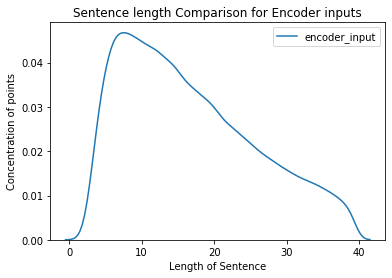

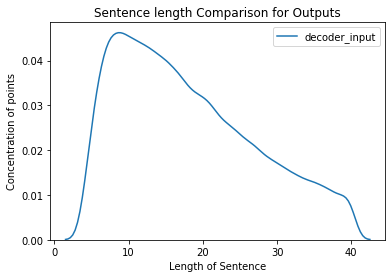

In [139]:
encoder_lengths = train['encoder_input'].str.split().apply(len)
decoder_lengths = train['decoder_input'].str.split().apply(len)
sns.kdeplot(encoder_lengths)
plt.title("Sentence length Comparison for Encoder inputs")
plt.xlabel("Length of Sentence")
plt.ylabel("Concentration of points")
plt.show()
sns.kdeplot(decoder_lengths)
plt.title("Sentence length Comparison for Outputs")
plt.xlabel("Length of Sentence")
plt.ylabel("Concentration of points")

plt.show()

#### 5.2 Observations:

-  We have splitted our data into train and validation dataframes.
-  Our training dataset has 218k points and validation has 54k points. This was obtained using the preparation function with maxlen of 40 for sentences.
-  As we can observe from the above graph, the max len is 40, but still majoriry of the points have a len of 10-20
-  Using this train dataset, we create our tokenizers using the tonkenization function

In [138]:
# We define a function tokenization which would take the train dataset as input
# We create 2 tokenizers perturbation and correct using encoder_input and decoder_input
# We calculate the len of these tokenizers and return all 4 data structures.


def tokenization(train):
    
    token_perturbation = Tokenizer(filters='"#$%&()*+-./:;=@[\\]^_`{|}~\t\n?,!')
    token_perturbation.fit_on_texts(train['encoder_input'].values)
    
    token_correct = Tokenizer(filters='"#$%&()*+-./:;=@[\\]^_`{|}~\t\n?,!')
    token_correct.fit_on_texts(train['decoder_input'].values)
    
    v_perturbation = len(token_perturbation.word_index.keys()) +1
    v_correct=len(token_correct.word_index.keys()) +1
    
    return token_perturbation,token_correct,v_perturbation,v_correct

In [104]:
token_perturbation,token_correct,v_perturbation,v_correct = tokenization(train)

### 6. Baseline Models

Based on the data preparations done till now, we are ready to start building our models. Initially, we would like to build a very basic model to verify some of the parameters in our dataset. Parameters like maxlen of sentences need to be confirmed before making complicated models.

For this purpose, we are going to start with an Encoder-Decoder Model with LSTMs using Teacher forcing Mechanism to predict our output.

#### 6.1 Baseline Encoder-Decoder Model-1

In [2]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size= lstm_size
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
        

    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedd                           = self.embedding(input_sequence)
        self.lstm_output, self.state_h,self.state_c = self.lstm(input_embedd)
        return  self.lstm_output, self.state_h,self.state_c

    
    def initialize_states(self,batch_size):
        '''
          Given a batch size it will return intial hidden state and intial cell state.
          If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        self.state_h=tf.zeros((batch_size,self.lstm_size))
        self.state_c=tf.zeros((batch_size,self.lstm_size))
        return self.state_h,self.state_c


In [3]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Decoder LSTM layer
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.embedding = Embedding(input_dim=self.out_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder")
        self.lstm = LSTM(self.lstm_size, return_sequences=True, return_state=True, name="Encoder_LSTM")

    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        target_embedd           = self.embedding(input_sequence)
        lstm_output,decoder_final_state_h,decoder_final_state_c        = self.lstm(target_embedd, initial_state=initial_states)
        return lstm_output,decoder_final_state_h,decoder_final_state_c


In [30]:
class Dataset:
    def __init__(self, data, token_perturbation, token_correct, max_len):
        self.encoder_inps = data['encoder_input'].values
        self.decoder_inps = data['decoder_input'].values
        self.decoder_outs = data['decoder_output'].values
        self.token_correct = token_correct
        self.token_perturbation = token_perturbation
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.token_perturbation.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.token_correct.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.token_correct.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

In [32]:
class Dataloader(tf.keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        
        # we are creating data like ([encoder_input, decoder_input], decoder_output) these are already converted into seq
        
        return [batch[0],batch[1]],batch[2]

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [75]:
train_dataset = Dataset(train, token_perturbation, token_correct, 40)
test_dataset  = Dataset(validation, token_perturbation, token_correct, 40)

train_dataloader = Dataloader(train_dataset, batch_size=64)
test_dataloader = Dataloader(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 40) (64, 40) (64, 40)


In [6]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size,batch_size):
        
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(inp_vocab_size=v_perturbation+1, embedding_size=50, input_length=encoder_inputs_length, lstm_size=128)
        self.initial_state= self.encoder.initialize_states(batch_size)
        self.decoder = Decoder(out_vocab_size=v_correct+1, embedding_size=50, input_length=decoder_inputs_length, lstm_size=128)
        self.dense   = Dense(output_vocab_size, activation='softmax')
        
    def call(self, data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        input,output = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input,self.initial_state)
        decoder_output,decoder_h,decoder_c  = self.decoder(output, [encoder_h, encoder_c])
        output                               = self.dense(decoder_output)
        return output
        

In [90]:
model  = Encoder_decoder(encoder_inputs_length=40,decoder_inputs_length=40,output_vocab_size=v_correct,batch_size=64)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//256
valid_steps=validation.shape[0]//256
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
callback_list = [reduce_lr, tensorboard_callback, earlystop]
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model.summary()

Epoch 1/30
912/912 [==============================] - 2280s 2s/step - loss: 3.1564 - val_loss: 2.9176
Epoch 2/30
912/912 [==============================] - 2312s 3s/step - loss: 2.8113 - val_loss: 2.7149
Epoch 3/30
912/912 [==============================] - 2264s 2s/step - loss: 2.6693 - val_loss: 2.5912
Epoch 4/30
912/912 [==============================] - 2254s 2s/step - loss: 2.5287 - val_loss: 2.4665
Epoch 5/30
912/912 [==============================] - 2252s 2s/step - loss: 2.4013 - val_loss: 2.3569
Epoch 6/30
912/912 [==============================] - 2252s 2s/step - loss: 2.2883 - val_loss: 2.2568
Epoch 7/30
912/912 [==============================] - 2253s 2s/step - loss: 2.1856 - val_loss: 2.1638
Epoch 8/30
912/912 [==============================] - 2256s 2s/step - loss: 2.0945 - val_loss: 2.0831
Epoch 9/30
912/912 [==============================] - 2252s 2s/step - loss: 2.0149 - val_loss: 2.0126
Epoch 10/30
912/912 [==============================] - 2250s 2s/step - loss: 1.940

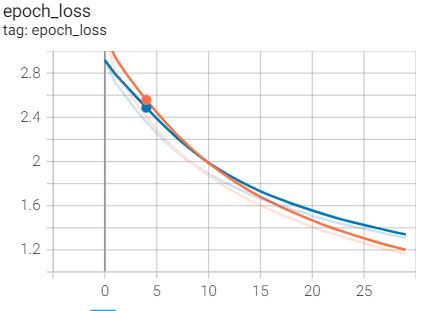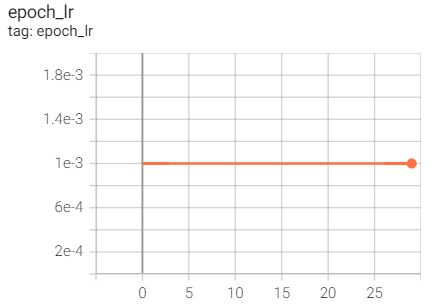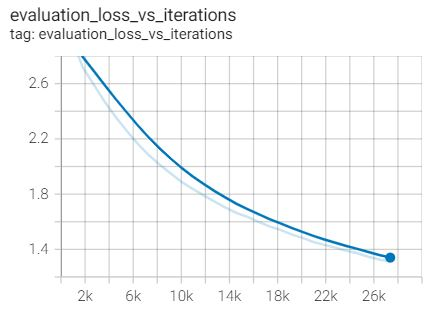

In [142]:
#%tensorboard --logdir logs/20220408-161558

#### 6.2 Observations:

-  We ran our model 1 for the movie dataset with maxlen of 40.
-  The other main parameters were as following:
    -  Embedding Vector size = 50
    -  Number of LSTMs = 128
    -  Batch Size = 64
    -  Optimizer = Adam with 0.001 lr
-  The time taken for the model to run per epoch was very high and there was not much improvement per epoch.
-  The model even after running for 30 epoch was able to reduce the val_loss to 1.1318, this value is still very high and not at all viable for our analysis.
-  As we can observe from the plot taken from tensorboard, the training and validation loss per epoch had started to deviate. This tells us that our model had already started to overfit and would have learnt very less and very slowly.
-  As a result of all this, we didnt run more epochs on this model.

In [91]:
model.save_weights("Movie_Model_1.h5")
print("Saved model to disk")

Saved model to disk


In [65]:
# We define a function called predict which we would use to predict any input sentence given using the input model and maxlen of the sentence
# We print the input sentence which has perturbations
# We take the input sentence and using the encoder of the trained model, we calculate the state values of encoder
# We initialize a list called pred
# We store the tokenization value of <start> in cur_vec
# We start a while loop with a boolean expression
# We convert the tokenization value of cur_vec to a emb_vec using the embedding layer in our trained model
# We pass the cur_emb along with the initial state values of encoder to our lstm layer in the model
# We obtain updated state values along with decoder output
# We pass the decoder output through a dense layer and update the state values
# We convert the output value to the tokenization one using np.argmax
# Using the tokenizer trained for the model, we predict the word and store it in pred
# Using pred we start formulating a str sentence k
# We continue this process till our model produces the word <end> or len of the prediction exceeds maxlen
# We return the predicted sentence

def predict(input_sentence,output_sentence,maxlen,model):
    print('Perturbation Text : {}'.format(input_sentence))
    max_len=maxlen
    encoder_inp = input_sentence
    encoder_seq = token_perturbation.texts_to_sequences([encoder_inp])
    encoder_seq = pad_sequences(encoder_seq, maxlen=max_len, dtype='int32', padding='post')
    states_values=model.layers[0].initialize_states(1)
    enc_output, enc_state_h, enc_state_c = model.layers[0](encoder_seq,states_values)
    states_values = [enc_state_h, enc_state_c]
    pred = []
    cur_vec = tf.expand_dims([token_correct.word_index['<start>']], axis=0)
    stop_condition = False
    while not stop_condition:
        cur_emb = model.layers[1].embedding(cur_vec)
        [infe_output, state_h, state_c] = model.layers[1].lstm(cur_emb, initial_state=states_values)
        infe_output=model.layers[2](infe_output)
        states_values = [state_h, state_c]
        # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
        # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
        cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
        x=cur_vec[0].tolist()[0]
        #print("at time step 0 the word is ", tknizer_eng.index_word[x])
        pred.append(token_correct.index_word[x])
        k = ' '.join(pred)
        if (token_correct.index_word[x] == '<end>'):
            stop_condition = True
    print('Corrected Text: {}'.format(k))
    return k

In [96]:
test = validation[:1000]
bleu_score = 0
for i,j in zip(test['encoder_input'],test['decoder_output']):
    bleu_score = bleu_score + predict(i,j,40,model)
bleu_score = bleu_score/1000

Perturbation Text : Bob was a champion bodybuilder. You know that chest expansion program you see on TV? That was her idea.
Corrected Text: bob is a red trial you
Bleu Score for Correction : 1.0657698175929717e-231
----------------------------------------------------------------------
Perturbation Text : It's amazing, you know, that a drug could change things that, destroy a life and then give it back. It's hard to believe that the world could be so hellish day and heaven the next.


C:\Users\Kaushal\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Kaushal\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Kaushal\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  

Corrected Text: then get it easy to me
Bleu Score for Correction : 9.027975378249823e-232
----------------------------------------------------------------------
Perturbation Text : He wants to know if you'd like a cube of sugar your tea.
Corrected Text: he wants to know if it
Bleu Score for Correction : 1.1684984904806157e-231
----------------------------------------------------------------------
Perturbation Text : Then I put him to bed and pour talcum powder on him like an baby. He gets his jollies off.
Corrected Text: and i put him up here
Bleu Score for Correction : 1.0861073026020398e-231
----------------------------------------------------------------------
Perturbation Text : "I is a posthumous child. My father's eyes had closed upon the light of this world six months, when mine opened on it."
Corrected Text: never be another girl—
Bleu Score for Correction : 9.902933405946996e-232
----------------------------------------------------------------------
Perturbation Text : She was

Corrected Text: no i hope not i can't
Bleu Score for Correction : 1.1083517428455008e-231
----------------------------------------------------------------------
Perturbation Text : I'll find her, Bruce, if I have to put every detective the city the job. Tell you what -- go over to the Missing Persons Bureau and describe your mother. What does she look like?
Corrected Text: tell me i'm gonna go to
Bleu Score for Correction : 8.936513064562053e-232
----------------------------------------------------------------------
Perturbation Text : She's got bondage burns on her wrists. There's blow all over room, Moore looks like he went at it with an mountain lion. This room looks like Manson Family stayed here an month. Micheal goes down, we all go down.
Corrected Text: a 's like this a movie
Bleu Score for Correction : 8.941948351249749e-232
----------------------------------------------------------------------
Perturbation Text : No thank you. Seek and ye shall find, work and ye shall prosper 

Corrected Text: no wait a sec i don't
Bleu Score for Correction : 9.097337521348634e-232
----------------------------------------------------------------------
Perturbation Text : I can't get Rae on the phone. She's not at home... none of his friends seen his anywhere.
Corrected Text: i can't get away on the
Bleu Score for Correction : 1.1080599561299475e-231
----------------------------------------------------------------------
Perturbation Text : Thanks an lot, Ted.
Corrected Text: thanks a lot like jesus
Bleu Score for Correction : 1.4637115948630222e-231
----------------------------------------------------------------------
Perturbation Text : I wonder how long it takes to get someone you're stuck on out of your system? If they'd only invent some kind of an pump for that --
Corrected Text: get someone you're out
Bleu Score for Correction : 9.911137317717096e-232
----------------------------------------------------------------------
Perturbation Text : My mother always told me, if G

Bleu Score for Correction : 1.1045881851389632e-231
----------------------------------------------------------------------
Perturbation Text : Oh they've probably gone to a canteen, cup of tea, like.
Corrected Text: oh she sent you'll been
Bleu Score for Correction : 1.1730364340805698e-231
----------------------------------------------------------------------
Perturbation Text : You said a woman couldn't had done it.
Corrected Text: you said a woman couldn't
Bleu Score for Correction : 1.360621107775913e-231
----------------------------------------------------------------------
Perturbation Text : No. Nobody wll find us.
Corrected Text: no whatever will stay
Bleu Score for Correction : 1.3483065280626046e-231
----------------------------------------------------------------------
Perturbation Text : Don't they had enough for you to do at the castle?
Corrected Text: don't have enough for
Bleu Score for Correction : 1.28254206644474e-231
--------------------------------------------------

Corrected Text: if everybody says he is
Bleu Score for Correction : 1.1200407237786664e-231
----------------------------------------------------------------------
Perturbation Text : It acts as an drug on body?
Corrected Text: it means in the power
Bleu Score for Correction : 1.2882297539194154e-231
----------------------------------------------------------------------
Perturbation Text : This unaccountable specimen was found the south wing corridor.
Corrected Text: this unaccountable found
Bleu Score for Correction : 1.2351410368543584e-231
----------------------------------------------------------------------
Perturbation Text : This is a unified field! All a forces of a universe tied together-- perfectly!
Corrected Text: this is the third day
Bleu Score for Correction : 1.0216652050829071e-231
----------------------------------------------------------------------
Perturbation Text : As peculiar as a struggle between a 235 pound man, and an assailant strong enough to subdue him...tha

Corrected Text: anyone doctor prescott
Bleu Score for Correction : 9.822715125092595e-232
----------------------------------------------------------------------
Perturbation Text : I drove to St. Cloud to show Mark and Vanessa ultrasound. And I wound up staying for an couple of hours.
Corrected Text: to put to sell three months
Bleu Score for Correction : 1.0176229291719042e-231
----------------------------------------------------------------------
Perturbation Text : This time he did it to an kid who's simple enough to believe him. Why don't you dump the mother, Henry? He creates more work than he gets done.
Corrected Text: great enough to me even
Bleu Score for Correction : 9.72161026064145e-232
----------------------------------------------------------------------
Perturbation Text : Damn right I did it. Went back and set the house fire, his little floozy testified court - and I ended up doing ten years Rikers, got my teeth knocked out Mike the Dyke.
Corrected Text: total exercise r

Corrected Text: while yesterday i checked
Bleu Score for Correction : 9.354783909912307e-232
----------------------------------------------------------------------
Perturbation Text : Chicken feed. If Gus Gorman can push a right buttons ---
Corrected Text: promise ahead of police
Bleu Score for Correction : 1.2183324802375697e-231
----------------------------------------------------------------------
Perturbation Text : Let me tell you an few things about you Dad, okay? He's very very very clever, very very brave, and he loves you ever very much.
Corrected Text: good you see i'm not very
Bleu Score for Correction : 1.0557673522539066e-231
----------------------------------------------------------------------
Perturbation Text : It isn't that she hasn't got any sense, Doll. Her basic intelligence is probably above average, maybe quite an bit above average.
Corrected Text: that she hasn't heard
Bleu Score for Correction : 9.52208653546315e-232
--------------------------------------------

Corrected Text: never underestimate a
Bleu Score for Correction : 1.0948551819675659e-231
----------------------------------------------------------------------
Perturbation Text : Now don't get excited, Mr. Alexander. They'll scatter a covey of quail.
Corrected Text: now don't see henry herr
Bleu Score for Correction : 1.1268086493920282e-231
----------------------------------------------------------------------
Perturbation Text : I gotta leave first thing the morning.
Corrected Text: i gotta live at last night
Bleu Score for Correction : 1.295028036139838e-231
----------------------------------------------------------------------
Perturbation Text : My dear, it will hardly enhance your reputation to be celebrated throughout Vienna as an singing prostitute for an Turk.
Corrected Text: my dear it will not be
Bleu Score for Correction : 1.0366657262732162e-231
----------------------------------------------------------------------
Perturbation Text : Tomorrow, after 4:00. Stay inside, I

Corrected Text: okay that'll be here a
Bleu Score for Correction : 1.0288051586793896e-231
----------------------------------------------------------------------
Perturbation Text : Anyone this office lives their wits... I'm going to be with you a second. What you're hired for is to help us--does that seem clear to you?
Corrected Text: one with you you're a
Bleu Score for Correction : 9.788429383461836e-232
----------------------------------------------------------------------
Perturbation Text : Oh, I thought their was something funny... You see, Bruce, you don't mind if I call you Bruce, do you? After all, we're practically related --
Corrected Text: being funny you see it
Bleu Score for Correction : 9.512421065519574e-232
----------------------------------------------------------------------
Perturbation Text : I sure the glad they let Scraps ride up here with us.
Corrected Text: i sure they let the kid
Bleu Score for Correction : 1.2022630406526483e-231
----------------------------

Bleu Score for Correction : 1.1274341332018836e-231
----------------------------------------------------------------------
Perturbation Text : Yes... I wanted to ask you about some photographs I saw out at a silo. There were three of them... printed on some kind of fabric.
Corrected Text: that's like that night
Bleu Score for Correction : 9.68025333900459e-232
----------------------------------------------------------------------
Perturbation Text : You'll be better off without me. I ain't fit to live with no more. It's just like a lynchin'. Maybe the don't use a knife on you, but the got other ways.
Corrected Text: no more it's just a shame
Bleu Score for Correction : 9.893133360884868e-232
----------------------------------------------------------------------
Perturbation Text : You got something the coke?
Corrected Text: you got something in a
Bleu Score for Correction : 1.3545058019712e-231
----------------------------------------------------------------------
Perturbation Text : -

Corrected Text: she knows her you love
Bleu Score for Correction : 1.2702917842806164e-231
----------------------------------------------------------------------
Perturbation Text : Remind me to tell you about when I looked into the heart of the artichoke.
Corrected Text: to me tell you about i
Bleu Score for Correction : 1.1128835475779667e-231
----------------------------------------------------------------------
Perturbation Text : Then get over on my side. Oh shit, cowtipping was the fucking greatest.
Corrected Text: then get over on my pocket
Bleu Score for Correction : 1.1935398790363042e-231
----------------------------------------------------------------------
Perturbation Text : I had a book report.
Corrected Text: i have a book on television
Bleu Score for Correction : 1.421239870917185e-231
----------------------------------------------------------------------
Perturbation Text : Come the New Orleans then. There's the opera on tonight. A real french opera! We can dine in spl

Corrected Text: that's very much of the
Bleu Score for Correction : 1.1640469867513693e-231
----------------------------------------------------------------------
Perturbation Text : Does they know that?
Corrected Text: does he know that <end>
Bleu Score for Correction : 1.5629365634398644e-231
----------------------------------------------------------------------
Perturbation Text : You _are_ Two-Face, you would need to face both rivers, both uptown and downtown simultaneously. Only one spot Gotham serves these bi- zonal, bi-coastal needs...
Corrected Text: keep hand to assassinate
Bleu Score for Correction : 9.1884924856864e-232
----------------------------------------------------------------------
Perturbation Text : Only thing you'll get from that clown is an faster way to die. LAO To the contrary...
Corrected Text: only you'll talk is there
Bleu Score for Correction : 1.1441414120472538e-231
----------------------------------------------------------------------
Perturbation Text :

Corrected Text: how we brought out my
Bleu Score for Correction : 1.0003688322288243e-231
----------------------------------------------------------------------
Perturbation Text : I recognize him now. Is he as imprudent as his father is at his age?
Corrected Text: i read him now he is in
Bleu Score for Correction : 1.1484186507842885e-231
----------------------------------------------------------------------
Perturbation Text : You knew this man didn't die at a bomb site before we got here.
Corrected Text: you knew it was once in
Bleu Score for Correction : 1.1429886232668031e-231
----------------------------------------------------------------------
Perturbation Text : This can't be confirmed at this time, but we do believe it to be true. We have reason to believe it was the youngest brother Richard, and they was shot in the vicinity of his neck and shoulders by the store's clerk.
Corrected Text: the roman george and the
Bleu Score for Correction : 8.624729164146422e-232
------------

Corrected Text: then don't have a drink
Bleu Score for Correction : 1.47813414027758e-231
----------------------------------------------------------------------
Perturbation Text : You're the drunk and the idiot.
Corrected Text: you're the drunk and the
Bleu Score for Correction : 1.374000103973205e-231
----------------------------------------------------------------------
Perturbation Text : It's never too soon! Girls decide how far to let you go the first five minutes.
Corrected Text: it's never too fast mrs
Bleu Score for Correction : 1.1294668623639398e-231
----------------------------------------------------------------------
Perturbation Text : I'm her, amigo. No worries. Gotta jam.
Corrected Text: i'm in his state no excuse
Bleu Score for Correction : 1.2605096809963652e-231
----------------------------------------------------------------------
Perturbation Text : Objection! This is ri...expect us to accept an photocopy, we have original right...
Corrected Text: objection this i

Corrected Text: sure how much do you lock
Bleu Score for Correction : 9.745212304340916e-232
----------------------------------------------------------------------
Perturbation Text : Hey, idiot -- I've got stolen wheels and an stolen radio in a car.
Corrected Text: hey karla i've got drunk
Bleu Score for Correction : 1.2265928344754895e-231
----------------------------------------------------------------------
Perturbation Text : That's right. The murders in the eighties were never solved. But... there were teenaged witnesses who said Krueger had the ability to appear in your dreams... and that if they killed you in a dream, it would kill you in the real world.
Corrected Text: in the old and that will
Bleu Score for Correction : 8.42953628495304e-232
----------------------------------------------------------------------
Perturbation Text : I'd like an word with you, Jack.
Corrected Text: i'd like a word with you
Bleu Score for Correction : 1.4537198054758483e-231
---------------------

Perturbation Text : In middle of jungle -- an goddamn light.
Corrected Text: in front of the building
Bleu Score for Correction : 1.2567088331824486e-231
----------------------------------------------------------------------
Perturbation Text : Alright then, Me, I,... I read a book, I woke him up and I intend to stop him.
Corrected Text: alright alright me i woke
Bleu Score for Correction : 1.1359770273922502e-231
----------------------------------------------------------------------
Perturbation Text : I must find the means to save him, then. I was hoping I could ask you for an little magic help, but if it makes you so tired...
Corrected Text: then i was hoping i thought
Bleu Score for Correction : 1.0205885198429529e-231
----------------------------------------------------------------------
Perturbation Text : Is MOM... there?
Corrected Text: is mom in there <end>
Bleu Score for Correction : 1.4837867640225538e-231
---------------------------------------------------------------------

Corrected Text: i'm amazed but you won't
Bleu Score for Correction : 1.2097822504111573e-231
----------------------------------------------------------------------
Perturbation Text : Tell him -- if he uncovers our whereabouts -- you'll slit your wrists with an razor, and I'll plunge an hat- pin through my heart.
Corrected Text: he suspects your passport
Bleu Score for Correction : 9.966150368347767e-232
----------------------------------------------------------------------
Perturbation Text : Why not show Dr. Furtwängler a evidence. It may refresh his memory?
Corrected Text: why not work our own doctor
Bleu Score for Correction : 1.1274341332018836e-231
----------------------------------------------------------------------
Perturbation Text : Well, I don't think we had a whole lot to say to each other, Ben. I do think you should know the consequences of what you've done. I do think you should know that my wife and I are getting a divorce soon.
Corrected Text: good idea you did i want


Corrected Text: watch meet you not the
Bleu Score for Correction : 9.563995505062079e-232
----------------------------------------------------------------------
Perturbation Text : See, we're about out... been driving all night. Actually, I don't even had time to explain it to you.
Corrected Text: see he was right now over
Bleu Score for Correction : 1.0518351895246305e-231
----------------------------------------------------------------------
Perturbation Text : Look -- we got a little trouble -- they rudely took our helicopter for MedEvac work on this -- uh Operation Brute Force -- They just brought it back this morning.
Corrected Text: shut down there before
Bleu Score for Correction : 9.566325062049814e-232
----------------------------------------------------------------------
Perturbation Text : He wants us to move out, says there could be fifty more mines in the building. He thinks I'm mad because I laughed at him. He's Indian, they wears a turban.
Corrected Text: more in the bui

Corrected Text: no they will not i know
Bleu Score for Correction : 1.1872004050154218e-231
----------------------------------------------------------------------
Perturbation Text : Of course, boys know you too well to mark you down for an cheese-eater.
Corrected Text: of course mr kirkeby you
Bleu Score for Correction : 1.1337861261109773e-231
----------------------------------------------------------------------
Perturbation Text : It was at that.
Corrected Text: it was at that <end>
Bleu Score for Correction : 1.568913485350841e-231
----------------------------------------------------------------------
Perturbation Text : I'm beginning to... be aware of that, John. Listen, I'm not gonna do nothing heroic here, you can trust me on that, buddy. Whaddaya say we just sit down for an while. I don't have no tricks, I'm not that smart. You could, like, rest up for a jump.
Corrected Text: for a while i can not
Bleu Score for Correction : 8.639943069034788e-232
-----------------------------

Corrected Text: a joke for a book you
Bleu Score for Correction : 9.93662070938242e-232
----------------------------------------------------------------------
Perturbation Text : I can't think of anything at the moment... I'd you to write me out a slip, though, proving I came down here.
Corrected Text: not to me at the idea
Bleu Score for Correction : 9.808928824281052e-232
----------------------------------------------------------------------
Perturbation Text : No, that could not be done, Mr. Ruby. There are a good many things involved that.
Corrected Text: no not would have anything
Bleu Score for Correction : 1.1441414120472538e-231
----------------------------------------------------------------------
Perturbation Text : Forget it. One false move, and they toss us off the train - there'll be the police, and the papers, and the mob in Chicago...
Corrected Text: let us and bring her on
Bleu Score for Correction : 1.0518351895246305e-231
----------------------------------------------

Corrected Text: it's all you mind about
Bleu Score for Correction : 1.1061933066191038e-231
----------------------------------------------------------------------
Perturbation Text : Mr. President, we are in a revolutionary situation. We are under siege -- Black Panthers, Weathermen; The State Department under Rogers was leaking like a sieve. And now this insignificant little shit Ellsberg publishing all the diplomatic secrets of this country will destroy our ability to conduct foreign policy.
Corrected Text: little shit yes evil is
Bleu Score for Correction : 7.449120214230466e-232
----------------------------------------------------------------------
Perturbation Text : Hey, do you mind if I talk an little? I feel like, I don't know, talking I guess.
Corrected Text: hey do you mind i talk
Bleu Score for Correction : 1.1326985602301802e-231
----------------------------------------------------------------------
Perturbation Text : --all non-denial denials--we're dirty guys and the doub

Corrected Text: not if you take the order
Bleu Score for Correction : 1.2821097245439388e-231
----------------------------------------------------------------------
Perturbation Text : Wait! Ask her if they'd give me some money now. Tell her if they would, that would help me finish it.
Corrected Text: me ask her if her money
Bleu Score for Correction : 1.0643741755154884e-231
----------------------------------------------------------------------
Perturbation Text : How's Granma since we got her the tent?
Corrected Text: how's granma since we
Bleu Score for Correction : 1.3388441433044314e-231
----------------------------------------------------------------------
Perturbation Text : George, I'm afraid if you go through with this madness I must tender my resignation as your aide. I see where we're headed, you're putting your trust in a likes of Hamilton and Arnold...
Corrected Text: got your mother we can't
Bleu Score for Correction : 9.442563193709009e-232
------------------------------

Corrected Text: in shit in hell and they
Bleu Score for Correction : 8.800729090715649e-232
----------------------------------------------------------------------
Perturbation Text : You're absolutely right. You forgot to mention there nuclear subs. But it wouldn't matter. Sure we wouldn't get off without getting our hair mussed, but we'd prevail. I don't think we'd lose more then fifty million people, tops.
Corrected Text: into some out here and
Bleu Score for Correction : 8.816720535482148e-232
----------------------------------------------------------------------
Perturbation Text : The Queen will be in my charge till a champion steps forward to fight on his behalf.
Corrected Text: the will be in the state
Bleu Score for Correction : 1.0771988162528382e-231
----------------------------------------------------------------------
Perturbation Text : Her name is Kimberly Jane Emberg, she was just ID'd. I met her on an slab in West Virginia. And sometime tomorrow, or tomorrow night, he's

Corrected Text: to keep her in <end>
Bleu Score for Correction : 1.4637115948630222e-231
----------------------------------------------------------------------
Perturbation Text : Annette, why don't you just see if there's any beer left that can and relax a bit.
Corrected Text: why don't worry you see
Bleu Score for Correction : 1.1200407237786664e-231
----------------------------------------------------------------------
Perturbation Text : You mentioned an guy from L.A.P.D., but you didn't mention Federal.
Corrected Text: you was a clerk's attack
Bleu Score for Correction : 1.0972483223249561e-231
----------------------------------------------------------------------
Perturbation Text : You're not my attorney yet, Mr. Cedar. Not till I find out what's your mind. Suppose you get the books straightened out quick so I can have a look them.
Corrected Text: see how many kids is something
Bleu Score for Correction : 1.00189031013383e-231
----------------------------------------------------

Bleu Score for Correction : 1.2794358628081968e-231
----------------------------------------------------------------------
Perturbation Text : That's what you got me here for at three o'clock in the morning, 'cause there a spider in the bathroom?
Corrected Text: that's what you got my
Bleu Score for Correction : 1.0446550074992694e-231
----------------------------------------------------------------------
Perturbation Text : Now, you listen to me. You ain't gonna do an goddamn fucking thing, you hear me! Nobody cares what you think, I'm running this show, I make decisions.
Corrected Text: call a little boy you
Bleu Score for Correction : 9.343448878907464e-232
----------------------------------------------------------------------
Perturbation Text : Was he an good detective?
Corrected Text: is he a good kid <end>
Bleu Score for Correction : 1.4488496539373276e-231
----------------------------------------------------------------------
Perturbation Text : I have to check the upper lines.

Bleu Score for Correction : 1.4488496539373276e-231
----------------------------------------------------------------------
Perturbation Text : This is a complete disaster. I wanted her to find a wife, but he's got the wrong one --
Corrected Text: this is a shame to the
Bleu Score for Correction : 1.0134142050624664e-231
----------------------------------------------------------------------
Perturbation Text : The safe's an Simpson 71. Last time I played the game, Simpson only had an 40.
Corrected Text: the safe's a simpson 71
Bleu Score for Correction : 1.187850036123079e-231
----------------------------------------------------------------------
Perturbation Text : Five hundred wars... Arms... Drugs... Money... Everything you create was used to destroy...
Corrected Text: five thirty fifty places
Bleu Score for Correction : 1.0599580721425215e-231
----------------------------------------------------------------------
Perturbation Text : What are a terms?
Corrected Text: what are the cas

Corrected Text: jim jones thomas he's
Bleu Score for Correction : 9.480553210441019e-232
----------------------------------------------------------------------
Perturbation Text : I was acting a Private Citizen. Nothing that I've done should be construed reflecting the orders or intentions of anyone with whom you may have reason to believe I am connected with. Or whose <u>employ</u>...
Corrected Text: for them from the contrary
Bleu Score for Correction : 8.726094729337945e-232
----------------------------------------------------------------------
Perturbation Text : French? Damn it, I want my own man on this case. Somebody I trust. Somebody who doesn't mind breaking up a furniture!
Corrected Text: it i like my job on one
Bleu Score for Correction : 9.650668398586197e-232
----------------------------------------------------------------------
Perturbation Text : My son, there was something dreadful on your soul. Unburden it to me. I'm here only for you. Please talk to me.
Corrected Text

Corrected Text: the world is not a dozen
Bleu Score for Correction : 1.091223771477441e-231
----------------------------------------------------------------------
Perturbation Text : That's why I can tell you, straight out, you think too much about Irena -- blame yourself for his death. And its your thinking and brooding about his that makes you so unnaturally concerned about Amy.
Corrected Text: forget her for instance
Bleu Score for Correction : 9.120141474033543e-232
----------------------------------------------------------------------
Perturbation Text : You bust some small-time pimps, whores and dime-bag junkies, like the world's an better place because you're in it. And for what, Kittle... two hundred and fifty dollars an week? Tell me, how does anyone get so self-rightious when they can barely afford to pay their rent?
Corrected Text: a job could everything
Bleu Score for Correction : 9.067772416390865e-232
----------------------------------------------------------------------


Corrected Text: packs hour the d an hour
Bleu Score for Correction : 8.912256911982778e-232
----------------------------------------------------------------------
Perturbation Text : Name is Clyde Reilly. Hardware specialist. LETAC surveillance cameras got a picture of the perp as he left the building.
Corrected Text: name is six tons of big
Bleu Score for Correction : 1.0080942617254966e-231
----------------------------------------------------------------------
Perturbation Text : Timeless. When she comes into a room you'd think that the Bolsheviks had taken over Paris. She wears her cheap miserable blouse as though it were the latest model by Schiaparelli. What a woman! What a woman! There is a Russian snowstorm each of her eyes.
Corrected Text: the old pope knows a woman
Bleu Score for Correction : 8.750873288417359e-232
----------------------------------------------------------------------
Perturbation Text : Look, the only way I can get permission to fly is if I agree to help them

Corrected Text: say hello dear your name
Bleu Score for Correction : 9.72161026064145e-232
----------------------------------------------------------------------
Perturbation Text : Mr. Shaw, have you ever been an contract agent with Central Intelligence Agency?
Corrected Text: mr chang you've been in
Bleu Score for Correction : 1.1473418388635738e-231
----------------------------------------------------------------------
Perturbation Text : Just the name of this hospital, St. Severin. He repeated it a few times than he lost consciousness.
Corrected Text: just the name of this
Bleu Score for Correction : 1.0592691162555667e-231
----------------------------------------------------------------------
Perturbation Text : Are you crazy? You throw down with The Carpenter? You got an grudge against your life?
Corrected Text: are you you wanna learn
Bleu Score for Correction : 1.0489335475684504e-231
----------------------------------------------------------------------
Perturbation Text : You

Corrected Text: there's a great part about
Bleu Score for Correction : 1.035450101419401e-231
----------------------------------------------------------------------
Perturbation Text : They exchanged fire with a Pinkerton Guards, killing several of them. Then they raided a payroll office and blew a tracks for half an mile.
Corrected Text: victor kennedy of course
Bleu Score for Correction : 1.0244914152188952e-231
----------------------------------------------------------------------
Perturbation Text : I was the Army too. And I'm good with crowds.
Corrected Text: i was in the second with
Bleu Score for Correction : 1.245125027495129e-231
----------------------------------------------------------------------
Perturbation Text : I got news for you, Horrace got his ass out of their before you did.
Corrected Text: i got enough for you high
Bleu Score for Correction : 1.156100809123877e-231
----------------------------------------------------------------------
Perturbation Text : Hi, uh. H

Corrected Text: in my dark manager was
Bleu Score for Correction : 1.1059493561563175e-231
----------------------------------------------------------------------
Perturbation Text : What happened? That needle sank a rock.
Corrected Text: what happened that sells
Bleu Score for Correction : 1.2183324802375697e-231
----------------------------------------------------------------------
Perturbation Text : The word is that soon they is to be king of the middle empire. He is doing multiple runs right now and using the island as a jump-off point.
Corrected Text: the middle of the thing
Bleu Score for Correction : 9.771508958265237e-232
----------------------------------------------------------------------
Perturbation Text : And you wouldn't want to explode the basis of false data, would you?
Corrected Text: and you want to see the
Bleu Score for Correction : 1.1446717210712768e-231
----------------------------------------------------------------------
Perturbation Text : Captain, this is a 

Corrected Text: i'd like to believe that
Bleu Score for Correction : 1.0832677820940877e-231
----------------------------------------------------------------------
Perturbation Text : But for Catherine Martin, it all comes down to you and Lecter. You're a one he talks to.
Corrected Text: but in washington she's
Bleu Score for Correction : 1.0832677820940877e-231
----------------------------------------------------------------------
Perturbation Text : You ever reflect how this big explosion dead women coincides with the flowering of women's lib?
Corrected Text: you ever big how many
Bleu Score for Correction : 1.1035245457879284e-231
----------------------------------------------------------------------
Perturbation Text : Hold on, Ramon! Is their time to make another trip?
Corrected Text: hold on is in there any
Bleu Score for Correction : 1.2340561512781763e-231
----------------------------------------------------------------------
Perturbation Text : I... I got back a stack today. S

#### 6.3 Observations:

-  We took the first 1000 sentences from the validation list and tried to predict their corrected form using the predict function.
-  As we can observe from the output, it is very bad as none of the sentences are even close to being accurate. The model has failed badly. This was in line with the model having a very high val_loss as seen earlier.
- Looking at some of the major errors made during the prediction, we can observe that our model performs particularly bad with sentences of high len
- We have decided to reduce the maxlen of sentences and try this model once again to oberve the difference.

#### 6.4 Baseline Encoder-Decoder Model-2

Here we have reduced the maxlen of sentences from 40 to 20. Reducing the max len has reduced our dataset. Now, our dataset has 140k points in training anf 35k in validation set.

Using this dataset, we follow similar process as above.

In [107]:
train, validation = preparation(movie,20)
print(train.shape, validation.shape)
train.head()

C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(140375, 3) (35094, 3)


encoder_input  \
261153  I know. I said that, but... they said it was s...   
122721  It's Celine. He's okay. He had an pretty good ...   
163874  "...and behold he will come that walks as a ma...   
262725  Can you describe the relationship between Mr. ...   
33446   Now what on earth would give you the idea like...   

                                            decoder_input  \
261153  <start> I know.  I said that, but...  he said ...   
122721  <start> It's Celine.  He's okay.  He had a pre...   
163874  <start> "...and behold he will come that walks...   
262725  <start> Can you describe the relationship betw...   
33446   <start> Now what on earth would give you an id...   

                                           decoder_output  
261153  I know.  I said that, but...  he said it was s...  
122721  It's Celine.  He's okay.  He had a pretty good...  
163874  "...and behold he will come that walks as a ma...  
262725  Can you describe the relationship between Mr. ...  
33446   Now what on earth would give you an idea like ...

In [108]:
token_perturbation,token_correct,v_perturbation,v_correct = tokenization(train)

In [55]:
train_dataset = Dataset(train, token_perturbation, token_correct, 20)
test_dataset  = Dataset(validation, token_perturbation, token_correct, 20)

train_dataloader = Dataloader(train_dataset, batch_size=64)
test_dataloader = Dataloader(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 20) (64, 20) (64, 20)


In [56]:
model  = Encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=v_correct,batch_size=64)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//256
valid_steps=validation.shape[0]//256
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
callback_list = [reduce_lr, tensorboard_callback, earlystop]
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=64, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model.summary()

Epoch 1/64
548/548 [==============================] - 414s 747ms/step - loss: 3.9000 - val_loss: 3.5525
Epoch 2/64
548/548 [==============================] - 414s 756ms/step - loss: 3.4969 - val_loss: 3.3544
Epoch 3/64
548/548 [==============================] - 415s 758ms/step - loss: 3.2948 - val_loss: 3.1589
Epoch 4/64
548/548 [==============================] - 416s 758ms/step - loss: 3.1010 - val_loss: 2.9835
Epoch 5/64
548/548 [==============================] - 415s 758ms/step - loss: 2.9356 - val_loss: 2.8266
Epoch 6/64
548/548 [==============================] - 415s 758ms/step - loss: 2.7813 - val_loss: 2.6891
Epoch 7/64
548/548 [==============================] - 415s 758ms/step - loss: 2.6477 - val_loss: 2.5713
Epoch 8/64
548/548 [==============================] - 416s 759ms/step - loss: 2.5255 - val_loss: 2.4685
Epoch 9/64
548/548 [==============================] - 415s 758ms/step - loss: 2.4130 - val_loss: 2.3696
Epoch 10/64
548/548 [==============================] - 416s 759m

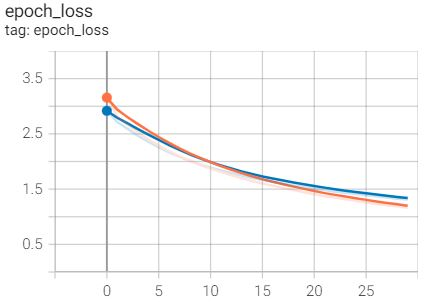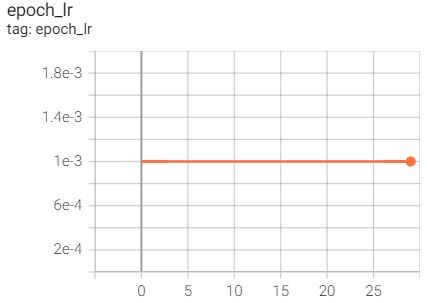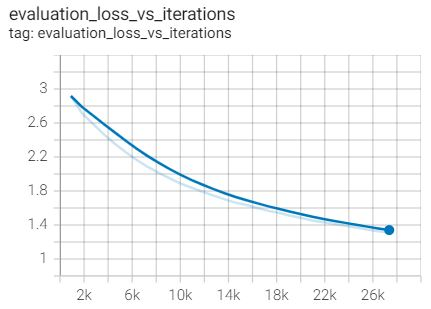

In [143]:
#%tensorboard --logdir logs/20220410-092543

#### 6.5 Observations:

-  We ran our model 2 for the movie dataset with maxlen of 20.
-  The other main parameters were as following:
    -  Embedding Vector size = 50
    -  Number of LSTMs = 128
    -  Batch Size = 64
    -  Optimizer = Adam with 0.001 lr
-  The time taken for the model to run per epoch was significantly less as compared to model 1 and there appears to be some improvement in val_loss per epoch.
-  The model was run for 58 epochs after which the val_loss reduced to 0.9481, this value is still very high and not at all viable for our analysis.
-  As we can observe from the plot taken from tensorboard, the training and validation loss per epoch had started to deviate. This tells us that our model had already started to overfit and would have learnt very less and very slowly. This model started to overfit more than the previous one.
-  This tells that, even though there was an improvement in speed and performance of model for smaller sentences, the dataset has reduced and therefore the model has started to overfit badly. 
-  As a result of all this, we didnt run more epochs on this model.
-  Looking at the drawback from this analysis, we have now decided to follow similar paramenters to build a model on Tatoeba dataset which is almost 5 times bigger than our movie dataset.

In [57]:
model.save_weights("Movie_Model_2.h5")
print("Saved model to disk")

Saved model to disk


In [61]:
test = validation[:1000]
total_bleu=0
for i,j in zip(test['encoder_input'],test['decoder_output']):
    pred = predict(i,j,20,model_2)
    correct = j.split()
    pred = pred.split()
    bleu_score = sentence_bleu([correct],pred,smoothing_function=smoothie)
    print('Real Output : {}'.format(j))
    print('Bleu Score for Correction : {}'.format(bleu_score))
    print("-"*70)
    total_bleu = total_bleu + (bleu_score)

Perturbation Text : There is any more to tell.
Corrected Text: are is don't
Real Output : There isn't any more to tell. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : It's got to be going better then this..
Corrected Text: at the who's
Real Output : It's got to be going better than this.. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Well, I was just down my luck and it seemed somethin' I was good so I...
Corrected Text: longer was pirate
Real Output : Well, I was just down on my luck and it seemed like somethin' I was good at so I... <end>
Bleu Score for Correction : 0.0006457090763956939
----------------------------------------------------------------------
Perturbation Text : George is an fucking burnout case. I didn't want him on the stand anyway. Get more names from Billy.
Corrected Text: one your the
Real Output : George 

Corrected Text: take you'd got
Real Output : We didn't talk about this.  They took the little boy, Cobb. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : What do you think the were after, Miss...?
Corrected Text: was don't you
Real Output : What do you think they were after, Miss...? <end>
Bleu Score for Correction : 0.025260968157861163
----------------------------------------------------------------------
Perturbation Text : Yeah, I was wondering why they should do that.
Corrected Text: there's i have
Real Output : Yeah, I was wondering why he should do that. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : -- than we never would have met.
Corrected Text: sure he like
Real Output : -- then we never would have met. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbatio

Corrected Text: it what bed
Real Output : I have met her.  What is your business with me? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : --there had to be an White House overseer--
Corrected Text: are he it a
Real Output : --there had to be a White House overseer-- <end>
Bleu Score for Correction : 0.05605239946478907
----------------------------------------------------------------------
Perturbation Text : Mr. Cardenas, I suggest you move to another line of questioning.
Corrected Text: no suggest i
Real Output : Mr. Cardenas, I suggest you move on to another line of questioning. <end>
Bleu Score for Correction : 0.006658718912444707
----------------------------------------------------------------------
Perturbation Text : Yeah... if I knew what it looked . There's probably five hundred ways to design a valve this...
Corrected Text: meet we've hundred
Real Output : Yeah... if I knew what it looked like. The

Real Output : Gee, boy, what do you have? You have plague? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Well, since Leo's name was the passenger list...
Corrected Text: think since
Real Output : Well, since Leo's name was on the passenger list... <end>
Bleu Score for Correction : 0.002921013628817601
----------------------------------------------------------------------
Perturbation Text : Let her go or I will deliver you, right now.
Corrected Text: how men did
Real Output : Let him go or I will deliver you, right now. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Land of a free.
Corrected Text: give know a
Real Output : Land of the free. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : I thought you be up with the sun.
Corrected Text: it what's you

Real Output : You knew it was me all along? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : I'm at an payphone in Vegas. What's up?
Corrected Text: do ten a leaves
Real Output : I'm at a payphone in Vegas.  What's up? <end>
Bleu Score for Correction : 0.05605239946478907
----------------------------------------------------------------------
Perturbation Text : I guess I'm an little screwy. Maybe I could believe it. Should I try?
Corrected Text: us nicely than
Real Output : I guess I'm a little screwy.  Maybe I could believe it.  Should I try? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : It's quite safe, the are managing...
Corrected Text: with actually
Real Output : It's quite safe, they are managing... <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text :

Corrected Text: are men have
Real Output : There is yet time.  Don't you want your own pleasure? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Yes...What was it?
Corrected Text: i've in i'm
Real Output : Yes...What is it? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : They're killing everyone. The Lady Minister! The UN soldiers. They're the gate.
Corrected Text: sound this the
Real Output : They're killing everyone. The Lady Minister! The UN soldiers. They're at the gate. <end>
Bleu Score for Correction : 0.004771180589076479
----------------------------------------------------------------------
Perturbation Text : This was our first "date" date.
Corrected Text: in have night
Real Output : This is our first "date" date. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Pe

Real Output : You caught me on an "up" day.  How about you? How did you end up in San Francisco? <end>
Bleu Score for Correction : 0.004601061132933437
----------------------------------------------------------------------
Perturbation Text : Wait... give me an minute.
Corrected Text: let's over a
Real Output : Wait... give me a minute. <end>
Bleu Score for Correction : 0.06866643071279656
----------------------------------------------------------------------
Perturbation Text : I thought bridesmaids have to wear the same dress.
Corrected Text: i what's tilled
Real Output : I thought bridesmaids had to wear the same dress. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : I got it. Listen, there something else I have to tell you.
Corrected Text: to without to
Real Output : I got it. Listen, there's something else I have to tell you. <end>
Bleu Score for Correction : 0.006658718912444707
-----------------------

Corrected Text: to do look sometime
Real Output : Of course they'll notice it. But look--  This is a good place for something. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Give me a address!!
Corrected Text: says me the
Real Output : Give me the address!! <end>
Bleu Score for Correction : 0.14709772079514616
----------------------------------------------------------------------
Perturbation Text : Go to Jim Morrison's grave Pere Lachaise. It's overrun with American tourists. I have to work.
Corrected Text: with pornography
Real Output : Go to Jim Morrison's grave at Pere Lachaise. It's overrun with American tourists. I have to work. <end>
Bleu Score for Correction : 5.3500230814494206e-05
----------------------------------------------------------------------
Perturbation Text : Well, technically "yes", but this was only the prototype.
Corrected Text: think know expect
Real Output : Well, technically "yes"

Real Output : Stay in the car. I'll only take a second. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : As fast I can.
Corrected Text: i'll could i
Real Output : As fast as I can. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : No. I gotta tell him a address, so he doesn't go in.
Corrected Text: take the down
Real Output : No.  I gotta tell him the address, so he doesn't go in. <end>
Bleu Score for Correction : 0.006658718912444707
----------------------------------------------------------------------
Perturbation Text : Mr. Gittes, sorry to keep you waiting. These staff meetings, they just go and .
Corrected Text: believe you
Real Output : Mr. Gittes, sorry to keep you waiting. These staff meetings, they just go on and on. <end>
Bleu Score for Correction : 8.820696853122304e-05
----------------------------------------------------

Corrected Text: i'm caught i'll
Real Output : He wasn't drinking. Ray fell asleep at the wheel. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Well, I would like to sit front today.
Corrected Text: think for it
Real Output : Well, I would like to sit in front today. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : I think of you and a "boy" all a time.
Corrected Text: it of don't
Real Output : I think of you and the "boy" all the time. <end>
Bleu Score for Correction : 0.012969413495583122
----------------------------------------------------------------------
Perturbation Text : But why would an guy would do that? Paint black teardrops on his face?
Corrected Text: should from
Real Output : But why would a guy would do that? Paint black teardrops on his face? <end>
Bleu Score for Correction : 0
-------------------------------------

Corrected Text: gone try he
Real Output : Wait, the pig lizard is gone. Why are they still chanting for the pig lizard? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : To the fact of my retirement, not only a diplomat but also a father.
Corrected Text: just dead that
Real Output : To the fact of my retirement, not only as a diplomat but also as a father. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : I like a colors.
Corrected Text: it you're the
Real Output : I like the colors. <end>
Bleu Score for Correction : 0.09583172388909193
----------------------------------------------------------------------
Perturbation Text : Joey, you want to get sucked out by an giant fucking mutated squid?
Corrected Text: i out hers we
Real Output : Joey, you want to get sucked out by a giant fucking mutated squid? <end>
Bleu Score for Correction :

Corrected Text: the ago in came
Real Output : You're aware that this woman was party to the so-called exorcism. <end>
Bleu Score for Correction : 0.026477278708044717
----------------------------------------------------------------------
Perturbation Text : You need an bass and an sax, don't you?
Corrected Text: you really a
Real Output : You need a bass and a sax, don't you? <end>
Bleu Score for Correction : 0.018100274620515014
----------------------------------------------------------------------
Perturbation Text : They GOTTA believe me, Charlie! They gotta had mercy!
Corrected Text: what matter
Real Output : They GOTTA believe me, Charlie! They gotta have mercy! <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Which one was that?
Corrected Text: call i have
Real Output : Which one is that? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbat

Corrected Text: just use maybe
Real Output : My son ... what's the matter? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Whah was dissdee?
Corrected Text: don't have came
Real Output : Whah is dissdee? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : I'm not sure. We had no launch protocol; the entry of the passenger was supposed to initiate activation.
Corrected Text: the yours matter
Real Output : I'm not sure.  We have no launch protocol; the entry of the passenger is supposed to initiate activation. <end>
Bleu Score for Correction : 0.000901159610008694
----------------------------------------------------------------------
Perturbation Text : It is very convenient to place all a blame on an dead man.
Corrected Text: convenient i
Real Output : It is very convenient to place all the blame on a dead man. <end>
Bleu Score for Cor

Corrected Text: night he everyone
Real Output : There is no dog in the first scene, Will Kempe, thank you. How goes it Will? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : But Vince has contacts all over the place! This was San Francisco! They'll be looking for me!
Corrected Text: that's miss
Real Output : But Vince has contacts all over the place!  This is San Francisco!  They'll be looking for me! <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : And when is a countdown supposed to expire?
Corrected Text: be here you
Real Output : And when is the countdown supposed to expire? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Shelly, would you give Laura an quick hand with a "Meals on Wheels"?
Corrected Text: over standing
Real Output : Shelly, would you 

Corrected Text: is consider
Real Output : After the outside alarm is off we go in through the bedroom window. <end>
Bleu Score for Correction : 0.00039531620679403594
----------------------------------------------------------------------
Perturbation Text : Here they comes right now.
Corrected Text: his in if ah
Real Output : Here he comes right now. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : You're gonna get hit tonight, bad -- an whole regiment of NVA regulars.
Corrected Text: out friends
Real Output : You're gonna get hit tonight, bad -- a whole regiment of NVA regulars. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : No, I just happen to take a Captain's advice and look at a bright side of things.
Corrected Text: need don't been
Real Output : No, I just happen to take the Captain's advice and look at the bright side of th

Corrected Text: i cause make
Real Output : We sure don't aim to cause any trouble... Yeah, she seems to grow on you. <end>
Bleu Score for Correction : 0.002449605792427873
----------------------------------------------------------------------
Perturbation Text : When Mayflowers find out we have Codex, they're going to want to make an deal...
Corrected Text: that does time
Real Output : When the Mayflowers find out we have the Codex, they're going to want to make a deal... <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : They treating you right over at a Bodwins?
Corrected Text: what treating
Real Output : They treating you right over at the Bodwins? <end>
Bleu Score for Correction : 0.004815937301836548
----------------------------------------------------------------------
Perturbation Text : No, I mean, what was it FOR? What are you selling?
Corrected Text: it you the door
Real Output : No, I mean, what is i

Corrected Text: in what mrs
Real Output : No, he lost the house after the stock market crash. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : What about an bee...?
Corrected Text: was i know no
Real Output : What about a bee...? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : That's all they said.
Corrected Text: will people
Real Output : That's all he said. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : I have an question for you, Mr. Stephens.
Corrected Text: it what a today
Real Output : I have a question for you, Mr. Stephens. <end>
Bleu Score for Correction : 0.05605239946478907
----------------------------------------------------------------------
Perturbation Text : I wish I were you. Look my staff, they won't work, they listen to no one.
Correc

Real Output : I am as well as can be expected. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : I found a way to re-route through the program. I'm turning the cars around the rest area loop.
Corrected Text: cup do take
Real Output : I found a way to re-route through the program.  I'm turning the cars around in the rest area loop. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : The night storms will start before you can reach a first marker.
Corrected Text: joints say aren't
Real Output : The night storms will start before you can reach the first marker. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Here we are... it's mocha mint from Lickety Splits. Oh, is that photograph just heart-rending?
Corrected Text: with the smarter
Real Output : Here we are...

Corrected Text: like find might
Real Output : No. If anything happened, you'd be stuck in there like he was. <end>
Bleu Score for Correction : 0.006658718912444707
----------------------------------------------------------------------
Perturbation Text : Off a record. No cameras.
Corrected Text: thought don't
Real Output : Off the record. No cameras. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : There was an recipe on the back --
Corrected Text: are have a steal
Real Output : There was a recipe on the back  -- <end>
Bleu Score for Correction : 0.05605239946478907
----------------------------------------------------------------------
Perturbation Text : It's nice is it?
Corrected Text: with the feel
Real Output : It's nice isn't it? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : That’s not true. We checked for leaks an few years

Corrected Text: since on i made
Real Output : This'll be great in my report, my mother was suspended for smoking. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Nah, I just throw that because I enjoy it.
Corrected Text: nah i there
Real Output : Nah, I just throw that in because I enjoy it. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : The kids school said this is a haunted house -- that a bad man used to live here.
Corrected Text: yelled dear
Real Output : The kids at school said this is a haunted house -- that a bad man used to live here. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Goddamit! Where is he getting a money to fight?
Corrected Text: do some don't
Real Output : Goddamit!  Where is he getting the money to fight? <end>
Bleu Score for C

Corrected Text: know already
Real Output : A Sandman can get as sick of his face as anyone else. Where's the doctor? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Do they have a report? Have you discussed it with them?
Corrected Text: what what the
Real Output : Do they have the report? Have you discussed it with them? <end>
Bleu Score for Correction : 0.009292990849363563
----------------------------------------------------------------------
Perturbation Text : As long as there's an pile-up, we can do our bit to encourage his permanent withdrawal from the contest.
Corrected Text: two bit i perfect
Real Output : As long as there's a pile-up, we can do our bit to encourage his permanent withdrawal from the contest. <end>
Bleu Score for Correction : 0.0035833100132879655
----------------------------------------------------------------------
Perturbation Text : You realize that you've brought an killer into t

Corrected Text: guys i'll tested
Real Output : Not revealing information doesn't necessarily make someone a liar. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : I've talked to Doctor Emlee, and they says...
Corrected Text: can't talked
Real Output : I've talked to Doctor Emlee, and he says... <end>
Bleu Score for Correction : 0.004815937301836548
----------------------------------------------------------------------
Perturbation Text : It's just that I left my asshole decoder ring home, so how do I know not to worry?
Corrected Text: soon you i plays
Real Output : It's just that I left my asshole decoder ring at home, so how do I know not to worry? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : I can use an smart guy like you.
Corrected Text: it that's listen
Real Output : I can use a smart guy like you. <end>
Bleu Score for Corr

Corrected Text: could on in
Real Output : If he does come in I'm not here... What were you drinking, Debra? <end>
Bleu Score for Correction : 0.004771180589076479
----------------------------------------------------------------------
Perturbation Text : The colored vote happens to be very important to a Mayor of this town.
Corrected Text: i my need died
Real Output : The colored vote happens to be very important to the Mayor of this town. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : No, no, no. All he wants to do is see the common man get an little representation.
Corrected Text: is don't they
Real Output : No, no, no. All he wants to do is see the common man get a little representation. <end>
Bleu Score for Correction : 0.0012576695487138676
----------------------------------------------------------------------
Perturbation Text : What would we do if an German came into the house?
Corrected Text: from he

Corrected Text: at a hain't
Real Output : Got a handshake like a partially excited penis. <end>
Bleu Score for Correction : 0.025260968157861163
----------------------------------------------------------------------
Perturbation Text : Meet me at 4:01, top of run. That'll give you an minute to freshen up.
Corrected Text: of has car get
Real Output : Meet me at 4:01, top of the run. That'll give you a minute to freshen up. <end>
Bleu Score for Correction : 0.007585867357658987
----------------------------------------------------------------------
Perturbation Text : It's a middle of a night. They're asleep. Phone didn't wake them.
Corrected Text: only of i a
Real Output : It's the middle of the night.  They're asleep.  Phone didn't wake them. <end>
Bleu Score for Correction : 0.020620525391425056
----------------------------------------------------------------------
Perturbation Text : Your Calabrian friend, I wll accept. At least Costello eats pasta like us.
Corrected Text: more i more

Corrected Text: guess i finished
Real Output : Good.  I want you to have a good time. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Yeah, but Roselli wasn't just any gangster. He was a gangster who set up Track 2 in Cuba.
Corrected Text: have the hound
Real Output : Yeah, but Roselli wasn't just any gangster.  He was the gangster who set up Track 2 in Cuba. <end>
Bleu Score for Correction : 0.000901159610008694
----------------------------------------------------------------------
Perturbation Text : Guinan, what are you doing here? I thought you were the Enterprise.
Corrected Text: about you may
Real Output : Guinan, what are you doing here? I thought you were on the Enterprise. <end>
Bleu Score for Correction : 0.004771180589076479
----------------------------------------------------------------------
Perturbation Text : Don't do anything, Linda. I'd rather just forget about it. I don't even the guy.
Cor

Corrected Text: have correct
Real Output : There is no correct resolution. It is a test of character. <end>
Bleu Score for Correction : 0.001074580861423586
----------------------------------------------------------------------
Perturbation Text : This is humiliating. We're being ejected from an prom!
Corrected Text: in the is san
Real Output : This is humiliating. We're being ejected from a prom! <end>
Bleu Score for Correction : 0.043653652596208924
----------------------------------------------------------------------
Perturbation Text : I'm familiar with a lot of breeders in the mid-west. What's her name?
Corrected Text: first of linked
Real Output : I'm familiar with a lot of breeders in the mid-west. What's his name? <end>
Bleu Score for Correction : 0.004771180589076479
----------------------------------------------------------------------
Perturbation Text : -- Kobo... I know. He killed two of my partners. One New York, one at the printing plant.
Corrected Text: just so took
Re

Perturbation Text : We been wantin' to ask you something. Are you a guy on YV?
Corrected Text: help it kept
Real Output : We been wantin' to ask you something. Are you the guy on YV? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Please, Maya. I'm trying to get us into a next century and you insist on this medieval nonsense.
Corrected Text: a mother offer
Real Output : Please, Maya.  I'm trying to get us into the next century and you insist on this medieval nonsense. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : What did they say? What did they say?
Corrected Text: was now little
Real Output : What did he say? What did he say? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : Clarence Norman White, do you understand how serious are a crimes with which 

Corrected Text: enough any for
Real Output : Excuse us.  But do stop by for a visit sometime!  You are welcome anytime. <end>
Bleu Score for Correction : 0.003418700280475194
----------------------------------------------------------------------
Perturbation Text : Did you want to had a cup of coffee or something, Bill?
Corrected Text: good i the huh
Real Output : Did you want to have a cup of coffee or something, Bill? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : ...Will their be somethin' else?
Corrected Text: say my didn't
Real Output : ...Will there be somethin' else? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : You! The girl from a volcano! Kryptonite...
Corrected Text: you don't the
Real Output : You! The girl from the volcano!  Kryptonite... <end>
Bleu Score for Correction : 0.035254521030815104
----------------------

Corrected Text: it he answers
Real Output : I have answers for you. <end>
Bleu Score for Correction : 0.06866643071279656
----------------------------------------------------------------------
Perturbation Text : Everything was not alright. I bring you in, and you slap my fucking face!
Corrected Text: it couple you
Real Output : Everything is not alright.  I bring you in, and you slap my fucking face! <end>
Bleu Score for Correction : 0.003418700280475194
----------------------------------------------------------------------
Perturbation Text : Were a flags for Teddy?
Corrected Text: tell the for
Real Output : Were the flags for Teddy? <end>
Bleu Score for Correction : 0.08165860796549904
----------------------------------------------------------------------
Perturbation Text : This was starting to spook me.
Corrected Text: in have match
Real Output : This is starting to spook me. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------

Real Output : Five o'clock -- Thursday -- the Garden -- it's got to be something around here. <end>
Bleu Score for Correction : 0.002449605792427873
----------------------------------------------------------------------
Perturbation Text : Were you working for her last night?
Corrected Text: tell you in
Real Output : Were you working for him last night? <end>
Bleu Score for Correction : 0.035254521030815104
----------------------------------------------------------------------
Perturbation Text : I don't think I really had a choice in, that. Emily left me.
Corrected Text: it you've a
Real Output : I don't think I really have a choice in, that. Emily left me. <end>
Bleu Score for Correction : 0.004771180589076479
----------------------------------------------------------------------
Perturbation Text : This isn't like playin' winos on the street. You gotta do more then outrun the guy.
Corrected Text: the break you
Real Output : This isn't like playin' winos on the street.  You gotta do 

Corrected Text: soon on pocket
Real Output : Soon then.  I’ll save the last dance for you. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : When is they here?
Corrected Text: when perhaps
Real Output : When was they here? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : We got an party tomorrow night. Can't have the place smelling like shit.
Corrected Text: office know
Real Output : We got a party tomorrow night. Can't have the place smelling like shit. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : You know eavesdropping is an very unattractive habit.
Corrected Text: you she is five
Real Output : You know eavesdropping is a very unattractive habit. <end>
Bleu Score for Correction : 0.05605239946478907
----------------------------------------------------

Corrected Text: away in them
Real Output : I'm looking at you, and the whole time I can't help thinking you had your willie inside her hootchie-kooch. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : We'd appreciate it if the Maharajah would let us stay tonight. We'll be on out way the morning.
Corrected Text: come haven't
Real Output : We'd appreciate it if the Maharajah would let us stay tonight. We'll be on out way in the morning. <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : This is her fiancee. Who's this?
Corrected Text: in the corner
Real Output : This is his fiancee.  Who's this? <end>
Bleu Score for Correction : 0
----------------------------------------------------------------------
Perturbation Text : It might be worth an Martini to you.
Corrected Text: to years i out
Real Output : It might be worth a Martini to you. <

In [62]:
print(total_bleu/1000)

0.009710579523310505


#### 6.6 Observations:

-  We took the first 1000 sentences from the validation list and tried to predict their corrected form using the predict function.
-  As we can observe from the output, it is very bad as none of the sentences are even close to being accurate. The model has failed badly. This was in line with the model having a very high val_loss as seen earlier.
- Looking at some of the major errors made during the prediction, we can observe that our model performs particularly bad with sentences of high len
- We have calculated the average Bleu_score for these 1000 predictions which has come to 0.009.
- As discussed earlier, we are going to built a similar model with same parameters for our bigger dataset in Tatoeba.

In [63]:
train.to_csv("Movie_Training_data.csv")
validation.to_csv("Movie_Validation_data.csv")

In [64]:
with open("Movie_TP", "wb") as f:
    pickle.dump(token_perturbation, f)
with open("Movie_TC", "wb") as f:
    pickle.dump(token_correct, f)

#### 6.7 Baseline Encoder-Decoder Model-3

We will try to built a model with the inferences taken from previous model on the Tatoeba Dataset.

In [150]:
tsv = pd.read_csv('Tatoeba.csv')
tsv.drop(columns=['Unnamed: 0'],inplace=True)
tsv

encoder_input  \
0                                I'm at an loss for words.   
1                                 That was the evil bunny.   
2                                    I was in a mountains.   
3                                 Is it an recent picture?   
4                           I don't know if I have a time.   
...                                                    ...   
1690326       Tom needs to know Mary isn going to do that.   
1690327  Wealth isn just money. If you know many langua...   
1690328                       What you're saying isn true.   
1690329  Money isn everything in life, as there is the ...   
1690330  Some people think that communication isn impor...   

                                                    output  
0                                 I'm at a loss for words.  
1                                  That was an evil bunny.  
2                                  I was in the mountains.  
3                                  Is it a recent picture?  
4                         I don't know if I have the time.  
...                                                    ...  
1690326     Tom needs to know Mary isn't going to do that.  
1690327  Wealth isn't just money. If you know many lang...  
1690328                     What you're saying isn't true.  
1690329  Money isn't everything in life, as there is th...  
1690330  Some people think that communication isn't imp...  

[1690331 rows x 2 columns]

In [151]:
percentile(tsv.encoder_input)

The 0th Percentile value is 2.0
The 10th Percentile value is 5.0
The 20th Percentile value is 6.0
The 30th Percentile value is 6.0
The 40th Percentile value is 7.0
The 50th Percentile value is 8.0
The 60th Percentile value is 9.0
The 70th Percentile value is 10.0
The 80th Percentile value is 12.0
The 90th Percentile value is 15.0
The 100th Percentile value is 3750.0
The 90th Percentile value is 15.0
The 91th Percentile value is 16.0
The 92th Percentile value is 17.0
The 93th Percentile value is 18.0
The 94th Percentile value is 20.0
The 95th Percentile value is 22.0
The 96th Percentile value is 25.0
The 97th Percentile value is 29.0
The 98th Percentile value is 34.0
The 99th Percentile value is 46.0
The 100th Percentile value is 3750.0
The 99.1th Percentile value is 47.0
The 99.2th Percentile value is 49.0
The 99.3th Percentile value is 52.0
The 99.4th Percentile value is 55.0
The 99.5th Percentile value is 59.0
The 99.6th Percentile value is 63.0
The 99.7th Percentile value is 71.0
Th

In [152]:
percentile(tsv.output)

The 0th Percentile value is 3.0
The 10th Percentile value is 5.0
The 20th Percentile value is 6.0
The 30th Percentile value is 7.0
The 40th Percentile value is 7.0
The 50th Percentile value is 8.0
The 60th Percentile value is 9.0
The 70th Percentile value is 10.0
The 80th Percentile value is 12.0
The 90th Percentile value is 16.0
The 100th Percentile value is 3750.0
The 90th Percentile value is 16.0
The 91th Percentile value is 17.0
The 92th Percentile value is 18.0
The 93th Percentile value is 19.0
The 94th Percentile value is 20.0
The 95th Percentile value is 22.0
The 96th Percentile value is 25.0
The 97th Percentile value is 29.0
The 98th Percentile value is 35.0
The 99th Percentile value is 46.0
The 100th Percentile value is 3750.0
The 99.1th Percentile value is 48.0
The 99.2th Percentile value is 50.0
The 99.3th Percentile value is 53.0
The 99.4th Percentile value is 56.0
The 99.5th Percentile value is 59.0
The 99.6th Percentile value is 64.0
The 99.7th Percentile value is 72.0
Th

#### Observations:

-  We plotted the percentiles of length of both encoder_input and output from our dataframe.
-  As we can observe the max len of our sentence is 3750 in both the cases. This is a very big number as we have already seen that our model will not perform well on bigger sentences
-  80th percentile value is less than 12 but 100th is 3750, this shows that there are a lot of outliers.
-  We need to decide a common ground for our maxlen which we can use further. We have decided to go with 10.

In [153]:
train, validation = preparation(tsv,10)
print(train.shape, validation.shape)
train.head()

C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(854892, 3) (213724, 3)


encoder_input  \
722074              I only had butter in the refrigerator.   
1471986  Tom said that they should've stayed in Austral...   
320523             He seemed to be an person of few words.   
850727                 Sami's father is so sweet and nice.   
144374                         I won't tell them an thing.   

                                             decoder_input  \
722074   <start> I only have butter in the refrigerator...   
1471986  <start> Tom said that he should've stayed in A...   
320523      <start> He seemed to be a person of few words.   
850727        <start> Sami's father was so sweet and nice.   
144374                  <start> I won't tell them a thing.   

                                            decoder_output  
722074   I only have butter in the refrigerator. <end> ...  
1471986  Tom said that he should've stayed in Australia...  
320523        He seemed to be a person of few words. <end>  
850727          Sami's father was so sweet and nice. <end>  
144374                    I won't tell them a thing. <end>

In [154]:
token_perturbation,token_correct,v_perturbation,v_correct = tokenization(train)

In [155]:
train_dataset = Dataset(train, token_perturbation, token_correct, 10)
test_dataset  = Dataset(validation, token_perturbation, token_correct, 10)

train_dataloader = Dataloader(train_dataset, batch_size=64)
test_dataloader = Dataloader(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 10) (64, 10) (64, 10)


In [156]:
model_2  = Encoder_decoder(encoder_inputs_length=10,decoder_inputs_length=10,output_vocab_size=v_correct,batch_size=64)
optimizer = tf.keras.optimizers.Adam()
model_2.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callback_list = [reduce_lr, tensorboard_callback, earlystop]
model_2.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=64, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model_2.summary()

C:\Users\Kaushal\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/64
834/834 [==============================] - 417s 493ms/step - loss: 4.3493 - val_loss: 3.8416
Epoch 2/64
834/834 [==============================] - 413s 496ms/step - loss: 3.4679 - val_loss: 3.1044
Epoch 3/64
834/834 [==============================] - 413s 495ms/step - loss: 2.8784 - val_loss: 2.6862
Epoch 4/64
834/834 [==============================] - 413s 495ms/step - loss: 2.5338 - val_loss: 2.3907
Epoch 5/64
834/834 [==============================] - 412s 494ms/step - loss: 2.2796 - val_loss: 2.1768
Epoch 6/64
834/834 [==============================] - 414s 496ms/step - loss: 2.0714 - val_loss: 1.9851
Epoch 7/64
834/834 [==============================] - 413s 495ms/step - loss: 1.8903 - val_loss: 1.8330
Epoch 8/64
834/834 [==============================] - 415s 497ms/step - loss: 1.7415 - val_loss: 1.6708
Epoch 9/64
834/834 [==============================] - 417s 500ms/step - loss: 1.5910 - val_loss: 1.5318
Epoch 10/64
834/834 [==============================] - 414s 496m

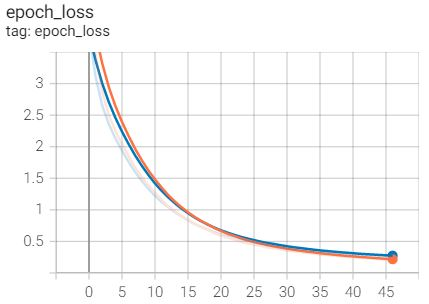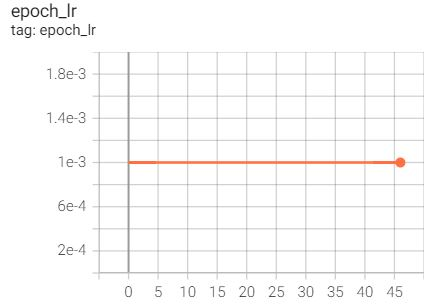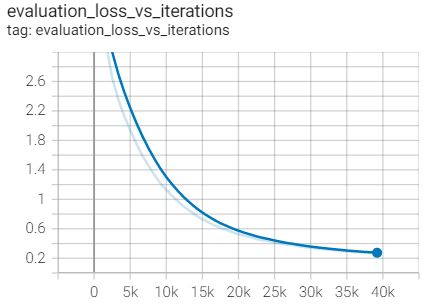

In [147]:
#%tensorboard --logdir logs/20220409-215018

#### 6.8 Observations:

-  We ran our model 3 for the Tatoeba dataset with maxlen of 10.
-  The other main parameters were as following:
    -  Embedding Vector size = 50
    -  Number of LSTMs = 128
    -  Batch Size = 64
    -  Optimizer = Adam with 0.001 lr
-  The time taken for the model to run per epoch was significantly less as compared to model 1 and similar to model 2. There appears to be some improvement in val_loss per epoch.
-  The model was run for 47 epochs after which the val_loss reduced to 0.2659, this value is significantly less as compared to model 2 and 1
-  As we can observe from the plot taken from tensorboard, the training and validation loss per epoch had started to deviate very slightly. The model was stopped early using our callbacks.
-  This tells us that the assumptions that we have made so far are correct. Our model is highly dependent on len of sentences and also on the size of our dataset.

In [157]:
model_2.save_weights("TSV_Model_1.h5")
print("Saved model to disk")

Saved model to disk


In [158]:
test = validation[:1000]

In [167]:
total_bleu=0
for i,j in zip(test['encoder_input'],test['decoder_output']):
    pred = predict(i,j,10,model_2)
    correct = j.split()
    pred = pred.split()
    bleu_score = sentence_bleu([correct],pred,smoothing_function=smoothie)
    print('Real Output : {}'.format(j))
    print('Bleu Score for Correction : {}'.format(bleu_score))
    print("-"*70)
    total_bleu = total_bleu + (bleu_score)

Perturbation Text : She is adopted by an Algerian family.
Corrected Text: she was adopted by an algerian family <end>
Real Output : She was adopted by an Algerian family. <end>
Bleu Score for Correction : 0.3655552228545123
----------------------------------------------------------------------
Perturbation Text : I seem to always had headaches.
Corrected Text: i seem to always have headaches <end>
Real Output : I seem to always have headaches. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : For a last time!
Corrected Text: for the last time <end>
Real Output : For the last time! <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Tom painted a walls light green.
Corrected Text: tom painted the walls light green <end>
Real Output : Tom painted the walls light green. <end>
Bleu Score for Correction : 0

Corrected Text: it is impossible for me to do so <end>
Real Output : It is impossible for me to do so. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : I would rather live alone a village.
Corrected Text: i would rather live alone in the village <end>
Real Output : I would rather live alone in a village. <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Text : If you eat an lot, you will get fat.
Corrected Text: if you eat a lot you will get louder <end>
Real Output : If you eat a lot, you will get fat. <end>
Bleu Score for Correction : 0.35019531335097165
----------------------------------------------------------------------
Perturbation Text : I'm going to give a workshop Algeria.
Corrected Text: i'm going to give a workshop in algeria <end>
Real Output : I'm going to give a workshop in Algeria. <end>
Ble

Corrected Text: tom is at home studying for the exam <end>
Real Output : Tom is at home studying for an exam. <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Text : When is the last time you left work early?
Corrected Text: when was the last time you left dinner early <end>
Real Output : When was the last time you left work early? <end>
Bleu Score for Correction : 0.537284965911771
----------------------------------------------------------------------
Perturbation Text : She said that she is concerned.
Corrected Text: she said that she was concerned <end>
Real Output : She said that she was concerned. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : I had no idea that Mary is your ex-wife.
Corrected Text: i had no idea that mary was your ex wife <end>
Real Output : I had no idea that Mary was your ex-wife

Corrected Text: she's a backpacker <end>
Real Output : She's a musicologist. <end>
Bleu Score for Correction : 0.2326589746035907
----------------------------------------------------------------------
Perturbation Text : Tom wll be impressed.
Corrected Text: tom will be impressed <end>
Real Output : Tom will be impressed. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : We put a world at your fingertips.
Corrected Text: we put the world at your coworkers <end>
Real Output : We put the world at your fingertips. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : I can confirm that he's not an Berber speaker.
Corrected Text: i can confirm that he's not a berber speaker <end>
Real Output : I can confirm that he's not a Berber speaker. <end>
Bleu Score for Correction : 0.537284965911771
------------------

Corrected Text: ziri messaged rima all the time <end>
Real Output : Ziri messaged Rima all the time. <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : Tom was behaving oddly.
Corrected Text: tom is behaving oddly <end>
Real Output : Tom is behaving oddly. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : I is hoping we could talk.
Corrected Text: i was hoping we could talk <end>
Real Output : I was hoping we could talk. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Donald Trump was a famous business person.
Corrected Text: donald trump is a famous business person <end>
Real Output : Donald Trump is a famous business person. <end>
Bleu Score for Correction : 0.3655552228545123
---------------------------

Corrected Text: this is where the accident happened <end>
Real Output : This is where the accident happened. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Sami hit me up an week before his birthday.
Corrected Text: sami hit me some a sandwich open the birthday <end>
Real Output : Sami hit me up a week before his birthday. <end>
Bleu Score for Correction : 0.2130484964540072
----------------------------------------------------------------------
Perturbation Text : Tom's an bright boy. He catches on very quickly.
Corrected Text: tom's a bright boy he catches on very well <end>
Real Output : Tom's a bright boy. He catches on very quickly. <end>
Bleu Score for Correction : 0.26368258593637695
----------------------------------------------------------------------
Perturbation Text : The tip of a knife blade is sharp.
Corrected Text: the tip of the knife branch are excellent <end>
Real Output : 

Corrected Text: i asked him if he had been to mexico <end>
Real Output : I asked her if she had been to Mexico. <end>
Bleu Score for Correction : 0.23826411296913536
----------------------------------------------------------------------
Perturbation Text : The firefighter gave some water to a thirsty koala.
Corrected Text: the couldn't split some water he had a theatre <end>
Real Output : The firefighter gave some water to the thirsty koala. <end>
Bleu Score for Correction : 0.2130484964540072
----------------------------------------------------------------------
Perturbation Text : Sami wll kill Layla.
Corrected Text: sami will kill layla <end>
Real Output : Sami will kill Layla. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : You're an piece of shit.
Corrected Text: you're a piece of shit <end>
Real Output : You're a piece of shit. <end>
Bleu Score for Correction : 0.32756475929865714
---

Real Output : I think you might have a drinking problem. <end>
Bleu Score for Correction : 0.3303164318013807
----------------------------------------------------------------------
Perturbation Text : 2013 is a year I was born.
Corrected Text: 2013 is a year i was born <end>
Real Output : 2013 is the year I was born. <end>
Bleu Score for Correction : 0.24747585322180027
----------------------------------------------------------------------
Perturbation Text : Tom saw Mary sitting by herself in a park.
Corrected Text: tom saw mary sitting by herself in the park <end>
Real Output : Tom saw Mary sitting by herself in the park. <end>
Bleu Score for Correction : 0.42728700639623407
----------------------------------------------------------------------
Perturbation Text : Walking meditatively through the labyrinth is soothing.
Corrected Text: walking in pin the penguin is an employee <end>
Real Output : Walking meditatively through the labyrinth was soothing. <end>
Bleu Score for Correction 

Corrected Text: tom pointed out a few words go a hear <end>
Real Output : Tom pointed out a few mistakes I had made. <end>
Bleu Score for Correction : 0.2777619034011791
----------------------------------------------------------------------
Perturbation Text : She told me she is mad.
Corrected Text: she told me she was mad <end>
Real Output : She told me she was mad. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : He wastes her money.
Corrected Text: he wastes his money <end>
Real Output : He wastes his money. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Mary said she did that 2013.
Corrected Text: mary said she did that in 2013 <end>
Real Output : Mary said she did that in 2013. <end>
Bleu Score for Correction : 0.5410822690539396
--------------------------------------------------------------

Corrected Text: do you have a phobia of spiders <end>
Real Output : Do you have a phobia of spiders? <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : You had to work harder on your Japanese studies.
Corrected Text: you have to work harder on your japanese studies <end>
Real Output : You have to work harder on your Japanese studies. <end>
Bleu Score for Correction : 0.537284965911771
----------------------------------------------------------------------
Perturbation Text : We need more people Tom helping us.
Corrected Text: we need more people in helping tom us <end>
Real Output : We need more people like Tom helping us. <end>
Bleu Score for Correction : 0.24764207868423957
----------------------------------------------------------------------
Perturbation Text : Tom isn't an tailor.
Corrected Text: tom isn't a tailor <end>
Real Output : Tom isn't a tailor. <end>
Bleu Score for Correction : 0.

Corrected Text: she is quite ignorant of cooking <end>
Real Output : She is quite ignorant of cooking. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Tom doesn't really care about a environment.
Corrected Text: tom doesn't really care about the environment <end>
Real Output : Tom doesn't really care about the environment. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : He stretched her legs.
Corrected Text: he stretched his legs <end>
Real Output : He stretched his legs. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Am I the list?
Corrected Text: am i on the list <end>
Real Output : Am I on the list? <end>
Bleu Score for Correction : 0.2450324327954738
-----------------------------------------------

Corrected Text: layla was wearing the hijab <end>
Real Output : Layla was wearing a hijab. <end>
Bleu Score for Correction : 0.2450324327954738
----------------------------------------------------------------------
Perturbation Text : Australia was a wonderful country.
Corrected Text: australia is a wonderful country <end>
Real Output : Australia is a wonderful country. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Could you send me an brochure?
Corrected Text: could you send me a brochure <end>
Real Output : Could you send me a brochure? <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Depression was very common.
Corrected Text: depression is very common <end>
Real Output : Depression is very common. <end>
Bleu Score for Correction : 0.26335227287021584
-----------------------------------------

Corrected Text: did tom tell you where the party was <end>
Real Output : Did Tom tell you where the party is? <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Text : I told him not to beat a dog.
Corrected Text: i told him not to beat the dog <end>
Real Output : I told him not to beat the dog. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Sami is endangering himself.
Corrected Text: sami was in his joke <end>
Real Output : Sami was endangering himself. <end>
Bleu Score for Correction : 0.23728353900810106
----------------------------------------------------------------------
Perturbation Text : Tom's brother looks a lot him.
Corrected Text: tom's brother looks a lot like him <end>
Real Output : Tom's brother looks a lot like him. <end>
Bleu Score for Correction : 0.5410822690539396
---------------------

Corrected Text: tom found tire tracks in the mud <end>
Real Output : Tom found tire tracks in the mud. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : She looks so attractive in an Kabyle dress.
Corrected Text: she looks so attractive in a kabyle dress <end>
Real Output : She looks so attractive in a Kabyle dress. <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Text : It's still a same here.
Corrected Text: it's still the same here <end>
Real Output : It's still the same here. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : He cheated him!
Corrected Text: he cheated on him <end>
Real Output : He cheated on him! <end>
Bleu Score for Correction : 0.26335227287021584
---------------------------------------------

Corrected Text: do you believe in the easter bunny <end>
Real Output : Do you believe in the Easter Bunny? <end>
Bleu Score for Correction : 0.3655552228545123
----------------------------------------------------------------------
Perturbation Text : Sami has also have an affair.
Corrected Text: sami has also had an affair <end>
Real Output : Sami has also had an affair. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : What'll the do to him?
Corrected Text: what'll they do to him <end>
Real Output : What'll they do to him? <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Tom is eating now, isn he?
Corrected Text: tom is eating now isn't he <end>
Real Output : Tom is eating now, isn't he? <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------

Corrected Text: blessed are those who have no talent <end>
Real Output : Blessed are those who have no talent! <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : I am an tennis player.
Corrected Text: i am a tennis player <end>
Real Output : I am a tennis player. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : We're a club.
Corrected Text: we're in the club <end>
Real Output : We're in a club. <end>
Bleu Score for Correction : 0.23640501160890146
----------------------------------------------------------------------
Perturbation Text : Mary was a little weird, isn't she?
Corrected Text: mary is a little weird isn't she <end>
Real Output : Mary is a little weird, isn't she? <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Per

Corrected Text: tom opened the bathroom door without knocking <end>
Real Output : Tom opened the bathroom door without knocking. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : I'll see if they is in.
Corrected Text: i'll see if he is in <end>
Real Output : I'll see if he is in. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Tom saw an flying saucer.
Corrected Text: tom saw a flying saucer <end>
Real Output : Tom saw a flying saucer. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : He didn't get a job.
Corrected Text: he didn't get the job <end>
Real Output : He didn't get the job. <end>
Bleu Score for Correction : 0.32756475929865714
--------------------------------------------------------------------

Corrected Text: tom is partly responsible for what happened <end>
Real Output : Tom is partly responsible for what happened. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Tom isn't here yet, but we expect her soon.
Corrected Text: tom isn't here yet but we wake him isn't <end>
Real Output : Tom isn't here yet, but we expect him soon. <end>
Bleu Score for Correction : 0.2803875896817201
----------------------------------------------------------------------
Perturbation Text : Tom and Mary are asleep in there bedrooms.
Corrected Text: tom and mary are asleep in their bedrooms <end>
Real Output : Tom and Mary are asleep in their bedrooms. <end>
Bleu Score for Correction : 0.3303164318013807
----------------------------------------------------------------------
Perturbation Text : I shouldn't had treated you that way.
Corrected Text: i shouldn't have treated you like that way <end>
Real Output

Corrected Text: they may eat wherever they want <end>
Real Output : They may eat wherever they want. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : He claims they didn't do that.
Corrected Text: he claims he didn't do that <end>
Real Output : He claims he didn't do that. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Mary handed Tom his wallet.
Corrected Text: mary handed tom his wallet <end>
Real Output : Mary handed Tom her wallet. <end>
Bleu Score for Correction : 0.23728353900810106
----------------------------------------------------------------------
Perturbation Text : Tom told me that they doesn't eat meat.
Corrected Text: tom told me that he doesn't eat meat <end>
Real Output : Tom told me that he doesn't eat meat. <end>
Bleu Score for Correction : 0.6104735835807844
-------------------

Corrected Text: sami couldn't hear anything layla was saying <end>
Real Output : Sami couldn't hear anything Layla was saying. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : Yanni had an very strict upbringing.
Corrected Text: yanni had a very strict upbringing <end>
Real Output : Yanni had a very strict upbringing. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Would you care for an taste?
Corrected Text: would you care for a taste <end>
Real Output : Would you care for a taste? <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : She gave blood to save his brother.
Corrected Text: she gave blood to save her brother <end>
Real Output : She gave blood to save her brother. <end>
Bleu Score for Correction :

Corrected Text: layla did the interview with salima <end>
Real Output : Layla did an interview with Euronews. <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : Is a Na'vi language good to learn?
Corrected Text: is the language shares good conversation as particular <end>
Real Output : Is the Na'vi language good to learn? <end>
Bleu Score for Correction : 0.2784931874429588
----------------------------------------------------------------------
Perturbation Text : Tom was often confused with his brother.
Corrected Text: tom is often confused with his brother <end>
Real Output : Tom is often confused with his brother. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : He needed to wash her car.
Corrected Text: he needed to wash his car <end>
Real Output : He needed to wash his car. <end>
Bleu Score for C

Corrected Text: it looks like tom isn't going to do that <end>
Real Output : It looks like Tom isn't going to do that. <end>
Bleu Score for Correction : 0.32466791547509893
----------------------------------------------------------------------
Perturbation Text : She told me they didn't teach French.
Corrected Text: she told me she didn't teach french <end>
Real Output : She told me she didn't teach French. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : You ought to had come to our party.
Corrected Text: you ought to have come to our party <end>
Real Output : You ought to have come to our party. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Mary says they appreciates all your help.
Corrected Text: mary says she remembers all your help <end>
Real Output : Mary says she appreciates all your help.

Real Output : They wash their cars once a week. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Sami was across the street, walking her dog.
Corrected Text: sami was across the street walking his dog <end>
Real Output : Sami was across the street, walking his dog. <end>
Bleu Score for Correction : 0.28684188448849735
----------------------------------------------------------------------
Perturbation Text : Mennad's depression started when they was really young.
Corrected Text: mennad's depression started when he was really young <end>
Real Output : Mennad's depression started when he was really young. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Is a driver at a restaurant?
Corrected Text: is the driver at the restaurant <end>
Real Output : Is the driver at the restaurant? <end>
Bleu Score for 

Corrected Text: please allow us to do the work <end>
Real Output : Please allow us to do the work. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : You are wrong some respects.
Corrected Text: you are wrong in some respects <end>
Real Output : You are wrong in some respects. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Mary said she's not planning doing that.
Corrected Text: mary said she's not planning on doing that <end>
Real Output : Mary said she's not planning on doing that. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : How do you think the campaign was going?
Corrected Text: how do you think the campaign is going <end>
Real Output : How do you think the campaign is going? <end>
Bleu Score for 

Perturbation Text : Tom is a little taller then me.
Corrected Text: tom is a little taller than me <end>
Real Output : Tom is a little taller than me. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : We care about there safety.
Corrected Text: we care about their safety <end>
Real Output : We care about their safety. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Tom was very arrogant, isn't he?
Corrected Text: tom is very arrogant isn't he <end>
Real Output : Tom is very arrogant, isn't he? <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : Yanni was gonna get involved.
Corrected Text: yanni is gonna get involved <end>
Real Output : Yanni is gonna get involved. <end>
Bleu Score for Correction : 0.327564

Corrected Text: i love the sea <end>
Real Output : I love the sea. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : She was an member of Red Army Faction.
Corrected Text: she was a member of the algerian servant <end>
Real Output : She was a member of the Red Army Faction. <end>
Bleu Score for Correction : 0.4180134288483488
----------------------------------------------------------------------
Perturbation Text : There is no choice but to sit and wait.
Corrected Text: there is no choice but to sit and wait <end>
Real Output : There was no choice but to sit and wait. <end>
Bleu Score for Correction : 0.537284965911771
----------------------------------------------------------------------
Perturbation Text : I felt a touch of pain my head.
Corrected Text: i felt in a touch of the audience wouldn't <end>
Real Output : I felt a touch of pain in my head. <end>
Bleu Score for Correction : 0.23826

Corrected Text: sami has done this drive a million times <end>
Real Output : Sami has done this drive a million times. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : I folk songs.
Corrected Text: i like folk songs <end>
Real Output : I like folk songs. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Why had you returned to Algeria?
Corrected Text: why have you returned to algeria <end>
Real Output : Why have you returned to Algeria? <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Stand up when your name was called out.
Corrected Text: stand up when your name is called out <end>
Real Output : Stand up when your name is called out. <end>
Bleu Score for Correction : 0.6104735835807844
-------------------

Corrected Text: i don't like tennis very much <end>
Real Output : I don't like tennis very much. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : The town was to the west of London.
Corrected Text: the town is to the west of london <end>
Real Output : The town is to the west of London. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Tom and Mary yelled loud they could.
Corrected Text: tom and mary yelled at loud as she could <end>
Real Output : Tom and Mary yelled as loud as they could. <end>
Bleu Score for Correction : 0.22527135786968613
----------------------------------------------------------------------
Perturbation Text : Sami is in the bathroom for a long time.
Corrected Text: sami was in the bathroom for a long time <end>
Real Output : Sami was in the bathroom for a long time. <end>
Bleu S

Corrected Text: she's untidy isn't she <end>
Real Output : She's untidy, isn't she? <end>
Bleu Score for Correction : 0.23640501160890146
----------------------------------------------------------------------
Perturbation Text : I can't call them home.
Corrected Text: i can't call them at home <end>
Real Output : I can't call them at home. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : No one wll dance with me.
Corrected Text: no one will dance with me <end>
Real Output : No one will dance with me. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Ziri is sleeping Rima's couch.
Corrected Text: ziri is sleeping on rima's couch <end>
Real Output : Ziri is sleeping on Rima's couch. <end>
Bleu Score for Correction : 0.2875833792374545
--------------------------------------------------------------------

Corrected Text: tom is much better at singing than i am <end>
Real Output : Tom is much better at singing than I am. <end>
Bleu Score for Correction : 0.537284965911771
----------------------------------------------------------------------
Perturbation Text : Mary said that she isn sleepy yet.
Corrected Text: mary said that she isn't sleepy yet <end>
Real Output : Mary said that she isn't sleepy yet. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : She won an free car.
Corrected Text: she won a free car <end>
Real Output : She won a free car. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : It is an object of terror.
Corrected Text: it was a object of terror <end>
Real Output : It was an object of terror. <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------

Corrected Text: he landed in jail for violent democracy <end>
Real Output : He landed in jail for drug possession. <end>
Bleu Score for Correction : 0.3655552228545123
----------------------------------------------------------------------
Perturbation Text : The typhoon is increasing strength.
Corrected Text: the typhoon is increasing in strength <end>
Real Output : The typhoon is increasing in strength. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : I met her while going back home.
Corrected Text: i met her while going back home <end>
Real Output : I met him while going back home. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : I hope they catch a shooter.
Corrected Text: i hope they catch the shooter <end>
Real Output : I hope they catch the shooter. <end>
Bleu Score for Correction : 0.4347208

Real Output : Mary said she wasn't ready to go home yet. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : Tom wll probably be able to fix Mary's car.
Corrected Text: tom will probably be able to fix mary's car <end>
Real Output : Tom will probably be able to fix Mary's car. <end>
Bleu Score for Correction : 0.537284965911771
----------------------------------------------------------------------
Perturbation Text : Tom said I have to do that.
Corrected Text: tom said i had to do that <end>
Real Output : Tom said I had to do that. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : They felt the didn't have a choice.
Corrected Text: they felt they didn't have a choice <end>
Real Output : They felt they didn't have a choice. <end>
Bleu Score for Correction : 0.5410822690539396
---------------------------

In [168]:
print(total_bleu/1000)

0.3850769828290236


#### 6.9 Observations:

-  We took the first 1000 sentences from the validation list and tried to predict their corrected form using the predict function.
-  As we can observe from the output, the model is able to produce corrected text which is quite similar to our target sentence.
-  The only major problem that we can oberve here is that, our model is not able to predict the upper case of some characters and punctuations.
- We have calculated the average Bleu_score for these 1000 predictions which has come to 0.39009, which is a very good improvement over model 2. 
-  The value of Bleu_score could have been higher if the model was able to achieve the punctuations and more case sensitive. One way to achieve that could be by pre processing the output before predictions.
-  In the end, we could summurize by saying that our baseline models works based on our assumptions and we could try to built upon it by making more complicated Models.

In [163]:
train.to_csv("TSV_Training_data.csv")
validation.to_csv("TSV_Validation_data.csv")

In [164]:
with open("TSV_TP", "wb") as f:
    pickle.dump(token_perturbation, f)

In [165]:
with open("TSV_TC", "wb") as f:
    pickle.dump(token_correct, f)

### 7. Perturbations Analysis

After doing the baseline model analysis previously, we have decided to use the best baseline model to analyse the various perturbations that we have added in our dataset.

For this we would take a particular type of perturbation dataset and run it through our best model and compare it with other ones to have a better understanding of our dataset before moving ahead. We would use the following types of perturbations:
-  **Words Removed**: We would remove a set of pronouns, prepositions, verbs and articles from the dataset
-  **Words Mis-spelled**: We would make a dataset with some common mis-spelling of basic verbs, prepositions, pronouns etc.
-  **Wrong Words**: This dataset would contain sentences with common mistakes of using the wrong words or words in the wrong tense.

In [178]:
tsv = pd.read_csv('eng_sentences.tsv',sep='\t')
tsv.columns=['ID','Lang','Line']
tsv

ID Lang                                               Line
0            1277  eng                             I have to go to sleep.
1            1280  eng   Today is June 18th and it is Muiriel's birthday!
2            1282  eng                                 Muiriel is 20 now.
3            1283  eng                         The password is "Muiriel".
4            1284  eng                               I will be back soon.
...           ...  ...                                                ...
1578224  10749880  eng  You think those languages don't promote your r...
1578225  10749891  eng                        How often do you use taxis?
1578226  10749894  eng                                  Tom is a flutist.
1578227  10749902  eng              My shoulder hurts when I lift my arm.
1578228  10749928  eng                      I think I'll stay right here.

[1578229 rows x 3 columns]

In [179]:
tsv.drop(columns=['ID','Lang'],inplace=True)
tsv = remove(tsv)
tsv.shape

(1564971, 1)

#### 7.1 Words Removed:

In [183]:
inp_removed,out_removed = perturbations(tsv,["a",'an','the',"is",'was','have','had',"is",'was','have','had',"in",'like','at','as',"by","on",'on','in','they','he','she','her','his','him','then','than','their','there'],['','','','','','','','','','','','','','','','','','','','','','','','','','']) #Article
inp_removed[0],out_removed[0],len(inp_removed)

100%|███████████████████████████████████████████████████████████████████| 2131355/2131355 [00:01<00:00, 1511756.41it/s]


('I to go to sleep.', 'I have to go to sleep.', 2131355)

In [185]:
pr = pd.DataFrame({'encoder_input':inp_removed, 'output':out_removed})
print(pr.shape)
pr.to_csv('Perturbations_removed.csv')
pr.tail()

(2131355, 2)


encoder_input  \
2131350              We all lived together one-room cabin.   
2131351  How will people hundred years from now define ...   
2131352                                    Tom is flutist.   
2131353                                       Tom flutist.   
2131354                                       Tom flutist.   

                                                    output  
2131350         We all lived together in a one-room cabin.  
2131351  How will people a hundred years from now defin...  
2131352                                  Tom is a flutist.  
2131353                                  Tom is a flutist.  
2131354                                  Tom is a flutist.

In [186]:
percentile(pr.encoder_input)

The 0th Percentile value is 2.0
The 10th Percentile value is 4.0
The 20th Percentile value is 4.0
The 30th Percentile value is 5.0
The 40th Percentile value is 6.0
The 50th Percentile value is 7.0
The 60th Percentile value is 7.0
The 70th Percentile value is 8.0
The 80th Percentile value is 10.0
The 90th Percentile value is 13.0
The 100th Percentile value is 48.0
The 90th Percentile value is 13.0
The 91th Percentile value is 13.0
The 92th Percentile value is 14.0
The 93th Percentile value is 15.0
The 94th Percentile value is 16.0
The 95th Percentile value is 17.0
The 96th Percentile value is 19.0
The 97th Percentile value is 21.0
The 98th Percentile value is 25.0
The 99th Percentile value is 31.0
The 100th Percentile value is 48.0
The 99.1th Percentile value is 32.0
The 99.2th Percentile value is 33.0
The 99.3th Percentile value is 34.0
The 99.4th Percentile value is 35.0
The 99.5th Percentile value is 36.0
The 99.6th Percentile value is 37.0
The 99.7th Percentile value is 38.0
The 99.

In [187]:
percentile(pr.output)

The 0th Percentile value is 3.0
The 10th Percentile value is 5.0
The 20th Percentile value is 6.0
The 30th Percentile value is 7.0
The 40th Percentile value is 7.0
The 50th Percentile value is 8.0
The 60th Percentile value is 9.0
The 70th Percentile value is 10.0
The 80th Percentile value is 12.0
The 90th Percentile value is 15.0
The 100th Percentile value is 49.0
The 90th Percentile value is 15.0
The 91th Percentile value is 15.0
The 92th Percentile value is 16.0
The 93th Percentile value is 17.0
The 94th Percentile value is 18.0
The 95th Percentile value is 20.0
The 96th Percentile value is 22.0
The 97th Percentile value is 25.0
The 98th Percentile value is 29.0
The 99th Percentile value is 35.0
The 100th Percentile value is 49.0
The 99.1th Percentile value is 36.0
The 99.2th Percentile value is 37.0
The 99.3th Percentile value is 39.0
The 99.4th Percentile value is 40.0
The 99.5th Percentile value is 41.0
The 99.6th Percentile value is 42.0
The 99.7th Percentile value is 44.0
The 99

In [188]:
train, validation = preparation(pr,10)
print(train.shape, validation.shape)
train.head()

C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(1114841, 3) (278711, 3)


encoder_input  \
1224779                           Sami's killer run.   
1753251  Algeria banned flights to and from country.   
1510618                I know Tom very quiet person.   
2113017             Tom zigzagged way down motorway.   
2060064              We've hardly time to breakfast.   

                                             decoder_input  \
1224779        <start> Sami's killer was on the run. <end>   
1753251  <start> Algeria banned flights to and from the...   
1510618         <start> I know Tom is a very quiet person.   
2113017   <start> Tom zigzagged his way down the motorway.   
2060064       <start> We've hardly time to have breakfast.   

                                            decoder_output  
1224779          Sami's killer was on the run. <end> <end>  
1753251  Algeria banned flights to and from the country...  
1510618           I know Tom is a very quiet person. <end>  
2113017     Tom zigzagged his way down the motorway. <end>  
2060064         We've hardly time to have breakfast. <end>

In [189]:
token_perturbation,token_correct,v_perturbation,v_correct = tokenization(train)

In [190]:
train_dataset = Dataset(train, token_perturbation, token_correct, 10)
test_dataset  = Dataset(validation, token_perturbation, token_correct, 10)

train_dataloader = Dataloader(train_dataset, batch_size=64)
test_dataloader = Dataloader(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 10) (64, 10) (64, 10)


In [191]:
model_pr  = Encoder_decoder(encoder_inputs_length=10,decoder_inputs_length=10,output_vocab_size=v_correct,batch_size=64)
optimizer = tf.keras.optimizers.Adam()
model_pr.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callback_list = [reduce_lr, tensorboard_callback, earlystop]
model_pr.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=64, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model_pr.summary()

C:\Users\Kaushal\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/64
1088/1088 [==============================] - 571s 519ms/step - loss: 4.1907 - val_loss: 3.5226
Epoch 2/64
1088/1088 [==============================] - 554s 510ms/step - loss: 3.2030 - val_loss: 2.9051
Epoch 3/64
1088/1088 [==============================] - 554s 509ms/step - loss: 2.7346 - val_loss: 2.5548
Epoch 4/64
1088/1088 [==============================] - 554s 509ms/step - loss: 2.4401 - val_loss: 2.3019
Epoch 5/64
1088/1088 [==============================] - 556s 511ms/step - loss: 2.2101 - val_loss: 2.1028
Epoch 6/64
1088/1088 [==============================] - 559s 514ms/step - loss: 2.0252 - val_loss: 1.9267
Epoch 7/64
1088/1088 [==============================] - 556s 511ms/step - loss: 1.8425 - val_loss: 1.7628
Epoch 8/64
1088/1088 [==============================] - 570s 524ms/step - loss: 1.6937 - val_loss: 1.6192
Epoch 9/64
1088/1088 [==============================] - 554s 509ms/step - loss: 1.5489 - val_loss: 1.4818
Epoch 10/64
1088/1088 [=======================

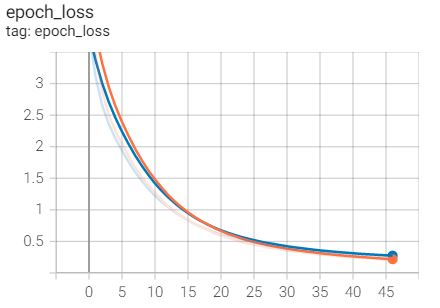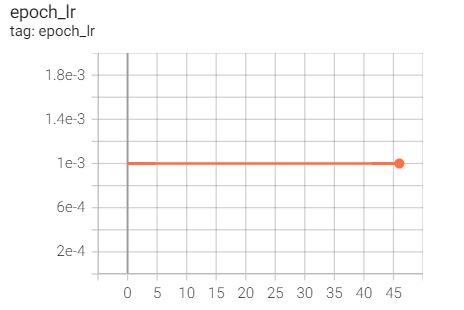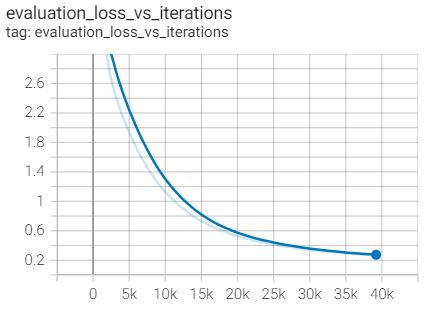

In [238]:
#%tensorboard --logdir logs/20220411-023031

#### 7.2 Observations:

-  We ran our model 4 for the Tatoeba dataset with Words Removed Perturbation.
-  The other main parameters were as following:
    -  Embedding Vector size = 50
    -  Number of LSTMs = 128
    -  Batch Size = 64
    -  Optimizer = Adam with 0.001 lr
- We were able to achieve similar results like our original dataset on this baseline model, this tells us that we can use Words removed Perturbations in our analysis further.

In [192]:
model_pr.save_weights("TSV_PR_1.h5")
print("Saved model to disk")

Saved model to disk


In [193]:
test = validation[:1000]

In [194]:
total_bleu=0
for i,j in zip(test['encoder_input'],test['decoder_output']):
    pred = predict(i,j,10,model_pr)
    correct = j.split()
    pred = pred.split()
    bleu_score = sentence_bleu([correct],pred,smoothing_function=smoothie)
    print('Real Output : {}'.format(j))
    print('Bleu Score for Correction : {}'.format(bleu_score))
    print("-"*70)
    total_bleu = total_bleu + (bleu_score)

Perturbation Text : Fortunately, Tom able to do that.
Corrected Text: fortunately tom is able to do that <end>
Real Output : Fortunately, Tom was able to do that. <end>
Bleu Score for Correction : 0.2576315006206139
----------------------------------------------------------------------
Perturbation Text : Tom and Mary their new jobs.
Corrected Text: tom and mary have their new jobs <end>
Real Output : Tom and Mary like their new jobs. <end>
Bleu Score for Correction : 0.23404821161541917
----------------------------------------------------------------------
Perturbation Text : The genitive singular of "rosa" "rosae".
Corrected Text: the rooftop is composed of grinding homework <end>
Real Output : The genitive singular of "rosa" is "rosae". <end>
Bleu Score for Correction : 0.26081470985436656
----------------------------------------------------------------------
Perturbation Text : Who will be victim?
Corrected Text: who will be the victim <end>
Real Output : Who will be the victim? <e

Corrected Text: when can i take a break <end>
Real Output : When can I take a break? <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : Tom and Mary say can do that today.
Corrected Text: tom and mary say they can do that today <end>
Real Output : Tom and Mary say they can do that today. <end>
Bleu Score for Correction : 0.42728700639623407
----------------------------------------------------------------------
Perturbation Text : What is name of this street?
Corrected Text: what is the name of this street <end>
Real Output : What is the name of this street? <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : He doesn't enough money to go travelling.
Corrected Text: he doesn't have enough money to go travelling <end>
Real Output : He doesn't have enough money to go travelling. <end>
Bleu Score for Correc

Corrected Text: many of his parents got very angry <end>
Real Output : Many of the parents got very angry. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : Mennad doing great.
Corrected Text: mennad is doing great <end>
Real Output : Mennad is doing great. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Send package to me this address.
Corrected Text: send the package to me this address <end>
Real Output : Send the package to me at this address. <end>
Bleu Score for Correction : 0.3376459109063278
----------------------------------------------------------------------
Perturbation Text : I met him city centre.
Corrected Text: i met him in the city centre <end>
Real Output : I met him in the city centre. <end>
Bleu Score for Correction : 0.5410822690539396
------------------------------------------

Corrected Text: this is a coincidence <end>
Real Output : This is a coincidence. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Tom asked me to proofread essay.
Corrected Text: tom asked me to proofread his essay <end>
Real Output : Tom asked me to proofread his essay. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Tom supposed to speak with Mary.
Corrected Text: tom is supposed to speak with mary <end>
Real Output : Tom was supposed to speak with Mary. <end>
Bleu Score for Correction : 0.3655552228545123
----------------------------------------------------------------------
Perturbation Text : Mary surprised by how small baby .
Corrected Text: mary was surprised by how small her baby <end>
Real Output : Mary was surprised by how small the baby was. <end>
Bleu Score for Correction : 0.434437125

Corrected Text: tom couldn't stay in the saddle <end>
Real Output : Tom couldn't stay in the saddle. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Microwave popcorn very unhealthy.
Corrected Text: microwave top to enroll <end>
Real Output : Microwave popcorn is very unhealthy. <end>
Bleu Score for Correction : 0.16275722768907425
----------------------------------------------------------------------
Perturbation Text : She certainly above forty.
Corrected Text: she certainly is above forty <end>
Real Output : She is certainly above forty. <end>
Bleu Score for Correction : 0.2821792728614595
----------------------------------------------------------------------
Perturbation Text : I think that something bad about to happen.
Corrected Text: i think that something bad is about to happen <end>
Real Output : I think that something bad is about to happen. <end>
Bleu Score for Correction : 0.6606

Real Output : Show me the book that you're reading. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : When last time you bath?
Corrected Text: when was the last time you was a bath <end>
Real Output : When was the last time you had a bath? <end>
Bleu Score for Correction : 0.42728700639623407
----------------------------------------------------------------------
Perturbation Text : Mary told me bored.
Corrected Text: mary told me she was bored <end>
Real Output : Mary told me she was bored. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : She worked aerobics instructor her twenties.
Corrected Text: she worked as an aerobics instructor in her twenties <end>
Real Output : She worked as an aerobics instructor in her twenties. <end>
Bleu Score for Correction : 0.6606328636027614
-------------------------

Corrected Text: ziri is a funny guy <end>
Real Output : Ziri is a funny guy. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : He so aggressive that others avoid him.
Corrected Text: he is so aggressive that others isn't sincere <end>
Real Output : He is so aggressive that others avoid him. <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Text : Sami expensive German car.
Corrected Text: sami had an expensive german car <end>
Real Output : Sami had an expensive German car. <end>
Bleu Score for Correction : 0.2875833792374545
----------------------------------------------------------------------
Perturbation Text : Tom will to do that someplace else.
Corrected Text: tom will have to do that someplace else <end>
Real Output : Tom will have to do that someplace else. <end>
Bleu Score for Correction : 0.610473

Corrected Text: she put on her boots <end>
Real Output : She put on her boots. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : I'd to dedicate this song to my mom.
Corrected Text: i'd like to dedicate this stuff like to my friend <end>
Real Output : I'd like to dedicate this song to my mom. <end>
Bleu Score for Correction : 0.28997844147152074
----------------------------------------------------------------------
Perturbation Text : He owns coffee shop.
Corrected Text: he owns a coffee shop <end>
Real Output : He owns a coffee shop. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Tom is in for quite surprise.
Corrected Text: tom is in for quite a surprise <end>
Real Output : Tom is in for quite a surprise. <end>
Bleu Score for Correction : 0.5410822690539396
-------------------------------------

Corrected Text: tom finally realized that mary was right <end>
Real Output : Tom finally realized that Mary was right. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : I've become tangled up in web of lies.
Corrected Text: i've become tangled up on the web of lies <end>
Real Output : I've become tangled up in a web of lies. <end>
Bleu Score for Correction : 0.26368258593637695
----------------------------------------------------------------------
Perturbation Text : Sami kissed Hajar al-Aswad.
Corrected Text: sami was kissed in al <end>
Real Output : Sami kissed the Hajar al-Aswad. <end>
Bleu Score for Correction : 0.23728353900810106
----------------------------------------------------------------------
Perturbation Text : Tom said it time for reflection.
Corrected Text: tom said it was time for his reflection <end>
Real Output : Tom said it was time for reflection. <end>
Bleu Score for Cor

Corrected Text: i really had a great time <end>
Real Output : I had a really great time. <end>
Bleu Score for Correction : 0.2615226537428971
----------------------------------------------------------------------
Perturbation Text : It this window that he broke.
Corrected Text: it was in this window that broke <end>
Real Output : It is this window that he broke. <end>
Bleu Score for Correction : 0.2576315006206139
----------------------------------------------------------------------
Perturbation Text : She gave piano to charity.
Corrected Text: she gave her piano to charity <end>
Real Output : She gave a piano to charity. <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : Have time for me well.
Corrected Text: have the time for me well <end>
Real Output : Have time for me as well. <end>
Bleu Score for Correction : 0.2875833792374545
------------------------------------------------------------

Corrected Text: it was obvious tom had been drinking <end>
Real Output : It was obvious Tom had been drinking. <end>
Bleu Score for Correction : 0.29430004544273397
----------------------------------------------------------------------
Perturbation Text : Where Taninna? "She's in Kabylie."
Corrected Text: where is taninna she's in kabylie <end>
Real Output : Where is Taninna? "She's in Kabylie." <end>
Bleu Score for Correction : 0.2620796772330101
----------------------------------------------------------------------
Perturbation Text : Your attitude making me sad.
Corrected Text: your attitude is making me sad <end>
Real Output : Your attitude is making me sad. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Mountaineering not my idea of good time.
Corrected Text: interested is not my idea of a good time <end>
Real Output : Mountaineering is not my idea of a good time. <end>
Bleu Score for 

Corrected Text: they had to admit that they were wrong <end>
Real Output : They had to admit that they were wrong. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Yanni last child playground.
Corrected Text: yanni was the last child on the playground <end>
Real Output : Yanni was the last child on the playground. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : All five rabbits were eaten hungry wolves.
Corrected Text: all five rabbits were eaten by wolves hungry <end>
Real Output : All five rabbits were eaten by the hungry wolves. <end>
Bleu Score for Correction : 0.4344371253135792
----------------------------------------------------------------------
Perturbation Text : Tom never chance, did he?
Corrected Text: tom had never had a chance did he <end>
Real Output : Tom never had a chance, did he?

Corrected Text: feed the brothers <end>
Real Output : Feed the hamster. <end>
Bleu Score for Correction : 0.2326589746035907
----------------------------------------------------------------------
Perturbation Text : He punished for child abuse.
Corrected Text: he was punished for his child abuse <end>
Real Output : He was punished for child abuse. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : Tom wrote tragedy with happy ending.
Corrected Text: tom wrote a tragedy with a happy ending <end>
Real Output : Tom wrote a tragedy with a happy ending. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Sami trying to do that.
Corrected Text: sami was trying to do that <end>
Real Output : Sami was trying to do that. <end>
Bleu Score for Correction : 0.4347208719449914
---------------------------------------

Real Output : All you have to do is wash the dish. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : This paper ticket.
Corrected Text: this paper is the ticket <end>
Real Output : This is a paper ticket. <end>
Bleu Score for Correction : 0.26259740246277147
----------------------------------------------------------------------
Perturbation Text : Yanni lives foreign country.
Corrected Text: yanni lives in a foreign country <end>
Real Output : Yanni lives in a foreign country. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : The waiter filled our glasses to brim.
Corrected Text: the waiter was broken up my other branch <end>
Real Output : The waiter filled our glasses to the brim. <end>
Bleu Score for Correction : 0.25916711346124927
-------------------------------------------------------------------

Corrected Text: it was a pretty big bear <end>
Real Output : It was a pretty big bear. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : What liberty?
Corrected Text: what is liberty <end>
Real Output : What is liberty? <end>
Bleu Score for Correction : 0.2326589746035907
----------------------------------------------------------------------
Perturbation Text : The fire out.
Corrected Text: the fire is out <end>
Real Output : The fire is out. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Roger Federer will not play Roland Garros.
Corrected Text: roger is the planned on become not play <end>
Real Output : Roger Federer will not play at Roland Garros. <end>
Bleu Score for Correction : 0.20731467560330663
----------------------------------------------------------------------
Perturbation Text : Sami

Corrected Text: yanni had four hundred classmate and he's impractical <end>
Real Output : Yanni had four hundred rounds of ammunition. <end>
Bleu Score for Correction : 0.2342054179517238
----------------------------------------------------------------------
Perturbation Text : She got married Algeria.
Corrected Text: she got married in algeria <end>
Real Output : She got married in Algeria. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : This pencil yours. Mine on desk.
Corrected Text: this pencil this is a yellow farmer <end>
Real Output : This pencil is yours. Mine is on the desk. <end>
Bleu Score for Correction : 0.20312270027112192
----------------------------------------------------------------------
Perturbation Text : It seems if that would work.
Corrected Text: it seems as if that would work <end>
Real Output : It seems as if that would work. <end>
Bleu Score for Correction : 0.541

Corrected Text: tom laughed at the public <end>
Real Output : Tom was laughed at in public. <end>
Bleu Score for Correction : 0.20741547636685612
----------------------------------------------------------------------
Perturbation Text : Were you Tom's house yesterday evening?
Corrected Text: were you at tom's house yesterday evening <end>
Real Output : Were you at Tom's house yesterday evening? <end>
Bleu Score for Correction : 0.29430004544273397
----------------------------------------------------------------------
Perturbation Text : Mary coughing.
Corrected Text: mary is coughing <end>
Real Output : Mary was coughing. <end>
Bleu Score for Correction : 0.19564209772076444
----------------------------------------------------------------------
Perturbation Text : She looked after old mother.
Corrected Text: she looked after her old mother <end>
Real Output : She looked after her old mother. <end>
Bleu Score for Correction : 0.4347208719449914
------------------------------------------

Corrected Text: you've got to have a plan <end>
Real Output : You've got to have a plan. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : This is finest book that I've read.
Corrected Text: this is the finest book that i've read <end>
Real Output : This is the finest book that I've read. <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Text : Temperatures reached -60C in Siberia.
Corrected Text: temperatures have reached 60c in siberia <end>
Real Output : Temperatures have reached -60C in Siberia. <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : He general practitioner.
Corrected Text: he is a general practitioner <end>
Real Output : He is a general practitioner. <end>
Bleu Score for Correction : 0.3275647592986

Corrected Text: tom said that he wasn't interested in good at swimming <end>
Real Output : Tom said that he wasn't very interested in sports. <end>
Bleu Score for Correction : 0.28997844147152074
----------------------------------------------------------------------
Perturbation Text : What would happened if Tom seen us?
Corrected Text: what would have happened if tom had seen us <end>
Real Output : What would have happened if Tom had seen us? <end>
Bleu Score for Correction : 0.32466791547509893
----------------------------------------------------------------------
Perturbation Text : We all right to be happy.
Corrected Text: we all have the right to be happy <end>
Real Output : We all have a right to be happy. <end>
Bleu Score for Correction : 0.28684188448849735
----------------------------------------------------------------------
Perturbation Text : The street covered with snow.
Corrected Text: the street was covered with snow <end>
Real Output : The street was covered with snow. 

Corrected Text: tom is the best looking man i know <end>
Real Output : Tom is the best-looking man I know. <end>
Bleu Score for Correction : 0.22277411682906492
----------------------------------------------------------------------
Perturbation Text : The dog that's staring at me so cute.
Corrected Text: the dog is staring and tom so is ignoring <end>
Real Output : The dog that's staring at me is so cute. <end>
Bleu Score for Correction : 0.29238249638573094
----------------------------------------------------------------------
Perturbation Text : I studied Italian Florence, not Perugia.
Corrected Text: i studied italian in the selfish smarter than <end>
Real Output : I studied Italian in Florence, not in Perugia. <end>
Bleu Score for Correction : 0.25916711346124927
----------------------------------------------------------------------
Perturbation Text : Remember what you love and forget about rest.
Corrected Text: remember what you love and forget about cheese <end>
Real Output : Re

Corrected Text: the referee called a place of cloud <end>
Real Output : The referee called for a corner kick. <end>
Bleu Score for Correction : 0.23404821161541917
----------------------------------------------------------------------
Perturbation Text : The result still in doubt.
Corrected Text: the result is still in doubt <end>
Real Output : The result is still in doubt. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : I won't be in office on Monday.
Corrected Text: i won't be in the office on monday <end>
Real Output : I won't be in the office on Monday. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Hooker extremely pleased.
Corrected Text: hooker was extremely pleased <end>
Real Output : Hooker was extremely pleased. <end>
Bleu Score for Correction : 0.26335227287021584
---------------------

Corrected Text: tom is still in love with his ex wife <end>
Real Output : Tom is still in love with his ex-wife. <end>
Bleu Score for Correction : 0.537284965911771
----------------------------------------------------------------------
Perturbation Text : You don't seem to lot of friends.
Corrected Text: you don't seem to have a lot of friends <end>
Real Output : You don't seem to have a lot of friends. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : Milk white.
Corrected Text: milk is white <end>
Real Output : Milk is white. <end>
Bleu Score for Correction : 0.2326589746035907
----------------------------------------------------------------------
Perturbation Text : Nobody's in classroom now.
Corrected Text: nobody's in the classroom now <end>
Real Output : Nobody's in the classroom now. <end>
Bleu Score for Correction : 0.32756475929865714
--------------------------------------------------

Corrected Text: tom could hardly believe in his eyes <end>
Real Output : Tom could hardly believe his eyes. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : Sami trying really hard to visualize that.
Corrected Text: sami was trying really hard to have that outfit <end>
Real Output : Sami was trying really hard to visualize that. <end>
Bleu Score for Correction : 0.4111336169005197
----------------------------------------------------------------------
Perturbation Text : Tom is overdressed for occasion.
Corrected Text: tom is overdressed for the occasion <end>
Real Output : Tom is overdressed for the occasion. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : My house near beach.
Corrected Text: my house is near the beach <end>
Real Output : My house is near the beach. <end>
Bleu Score for Correction

Corrected Text: there's a chance that tom will be there today <end>
Real Output : There's a chance that Tom will be there today. <end>
Bleu Score for Correction : 0.35019531335097165
----------------------------------------------------------------------
Perturbation Text : Dan moved out of area.
Corrected Text: dan moved in out of the area <end>
Real Output : Dan moved out of the area. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : Tom's friend getting married Boston.
Corrected Text: tom's friend is getting married in boston <end>
Real Output : Tom's friend is getting married in Boston. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Tom has farm in Australia.
Corrected Text: tom has a farm in australia <end>
Real Output : Tom has a farm in Australia. <end>
Bleu Score for Correction : 0.43472087

Corrected Text: the are colder in not a company <end>
Real Output : The baths are not in the forum. <end>
Bleu Score for Correction : 0.296342724396133
----------------------------------------------------------------------
Perturbation Text : We changed our plans because of late arrival.
Corrected Text: we have changed our departure because she is late of <end>
Real Output : We changed our plans because of her late arrival. <end>
Bleu Score for Correction : 0.2263659622303995
----------------------------------------------------------------------
Perturbation Text : There no good restaurant neighborhood.
Corrected Text: there is no good restaurant in the neighborhood <end>
Real Output : There is no good restaurant in the neighborhood. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : She perceived that her husband unhappy.
Corrected Text: she perceived that her husband was unhappy <end>
Real Ou

Real Output : Tom is sitting by the window. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Americans lost their confidence in Toyota.
Corrected Text: americans have lost their confidence in toyota <end>
Real Output : Americans have lost their confidence in Toyota. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : The section chief made me work slave.
Corrected Text: the section chief is the estimate up the reasonable weather <end>
Real Output : The section chief made me work like a slave. <end>
Bleu Score for Correction : 0.19035032617500067
----------------------------------------------------------------------
Perturbation Text : I've only one girlfriend.
Corrected Text: i've only had a one girlfriend <end>
Real Output : I've only had one girlfriend. <end>
Bleu Score for Correction : 0.24733285534

Corrected Text: i use it into this in a public around <end>
Real Output : I use it after getting on public transportation. <end>
Bleu Score for Correction : 0.2130484964540072
----------------------------------------------------------------------
Perturbation Text : Tom told me that Mary tired.
Corrected Text: tom told me that mary was tired <end>
Real Output : Tom told me that Mary was tired. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : Tom trouble again.
Corrected Text: tom is in trouble again <end>
Real Output : Tom is in trouble again. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : No answer required.
Corrected Text: no answer is required <end>
Real Output : No answer is required. <end>
Bleu Score for Correction : 0.26335227287021584
------------------------------------------------------

Corrected Text: the sick woman goes to the doctor <end>
Real Output : The sick woman goes to the doctor. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Yanni closed menu and ready to order.
Corrected Text: yanni closed the road with rima to change <end>
Real Output : Yanni closed the menu and was ready to order. <end>
Bleu Score for Correction : 0.19934703850724503
----------------------------------------------------------------------
Perturbation Text : Women don't penises.
Corrected Text: women don't like him <end>
Real Output : Women don't have penises. <end>
Bleu Score for Correction : 0.23640501160890146
----------------------------------------------------------------------
Perturbation Text : Oh, weather so beautiful!
Corrected Text: oh the weather is so beautiful <end>
Real Output : Oh, the weather is so beautiful! <end>
Bleu Score for Correction : 0.4347208719449914
----------------

Corrected Text: mary lost the court in case <end>
Real Output : Mary lost her court case. <end>
Bleu Score for Correction : 0.2620796772330101
----------------------------------------------------------------------
Perturbation Text : Sami non-Muslim.
Corrected Text: sami is a non muslim <end>
Real Output : Sami was a non-Muslim. <end>
Bleu Score for Correction : 0.23728353900810106
----------------------------------------------------------------------
Perturbation Text : My father satisfied with result.
Corrected Text: my father is satisfied with the result <end>
Real Output : My father was satisfied with the result. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : Tom put map table.
Corrected Text: tom put on the map on the table <end>
Real Output : Tom put the map on the table. <end>
Bleu Score for Correction : 0.3303164318013807
------------------------------------------------------------

Corrected Text: tom didn't know mary was hungry <end>
Real Output : Tom didn't know Mary was hungry. <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : Tom in his mid-sixties.
Corrected Text: tom is in his mid sixties <end>
Real Output : Tom is in his mid-sixties. <end>
Bleu Score for Correction : 0.2875833792374545
----------------------------------------------------------------------
Perturbation Text : She can answer question.
Corrected Text: she can answer the question <end>
Real Output : She can answer the question. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Dan heard gunshot.
Corrected Text: dan heard a gunshot <end>
Real Output : Dan heard a gunshot. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation 

Corrected Text: what'll the weather be this afternoon <end>
Real Output : What'll the weather be like this afternoon? <end>
Bleu Score for Correction : 0.2636023131721885
----------------------------------------------------------------------
Perturbation Text : Hiromi is wearing new dress.
Corrected Text: hiromi is wearing a new dress <end>
Real Output : Hiromi is wearing a new dress. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : I learned English words heart all day yesterday.
Corrected Text: i learned english words at heart all day yesterday <end>
Real Output : I learned English words by heart all day yesterday. <end>
Bleu Score for Correction : 0.23826411296913536
----------------------------------------------------------------------
Perturbation Text : I know that Tom pretty good snowboarder.
Corrected Text: i know that tom is a pretty good snowboarder <end>
Real Output : I know that T

Corrected Text: yanni is very shy and so skura <end>
Real Output : Yanni was very shy and so was Skura. <end>
Bleu Score for Correction : 0.32260135189272865
----------------------------------------------------------------------
Perturbation Text : I think we something common.
Corrected Text: i think we have something in common <end>
Real Output : I think we have something in common. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Michael Singer author of The Untethered Soul.
Corrected Text: michael singer is the author of the privilege soul <end>
Real Output : Michael Singer is the author of The Untethered Soul. <end>
Bleu Score for Correction : 0.2777619034011791
----------------------------------------------------------------------
Perturbation Text : Push button to open door.
Corrected Text: push the button to open the door <end>
Real Output : Push the button to open door. <end>
Bleu Sco

Corrected Text: i was just wondering <end>
Real Output : I was just wondering. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : On way back, I very scared.
Corrected Text: on the way back i was very scared <end>
Real Output : On the way back, I was very scared. <end>
Bleu Score for Correction : 0.28012362176895805
----------------------------------------------------------------------
Perturbation Text : We live one world.
Corrected Text: we live in one in the world <end>
Real Output : We live in one world. <end>
Bleu Score for Correction : 0.2576315006206139
----------------------------------------------------------------------


In [195]:
print(total_bleu/1000)

0.37558694535246323


#### 7.3 Observations:

-  We took the first 1000 sentences from the validation list and tried to predict their corrected form using the predict function.
-  As we can observe from the output, the model is able to produce corrected text which is quite similar to our target sentence.
-  The only major problem that we can oberve here is that, our model is not able to predict the upper case of some characters and punctuations.
- We have calculated the average Bleu_score for these 1000 predictions which has come to 0.37558, which is very similar to our best baseline model with original data.
-  The value of Bleu_score could have been higher if the model was able to achieve the punctuations and more case sensitive. One way to achieve that could be by pre processing the output before predictions.
-  In the end, we could summurize by saying that our baseline models works based on our assumptions and we could try to built upon it by making more complicated Models.

In [196]:
train.to_csv("TSV_PR_Train.csv")
validation.to_csv("TSV_PR_Validation.csv")

In [197]:
with open("TSV_PR_TP", "wb") as f:
    pickle.dump(token_perturbation, f)
with open("TSV_PR_TC", "wb") as f:
    pickle.dump(token_correct, f)

#### 7.4 Mis-Spelled Words

In [199]:
inp_ms,out_ms = perturbations(tsv,["a",'an','the',"is",'was','have','had',"is",'was','have','had',"in",'like','at','as',"by","on",'on','in','they','he','she','her','his','him','then','than','their','there'],['s','am','thr','id','wsd','hace','haf','im','wds','habe','has','im','lile','ad','ad','bu','in','pn','un','thry','hi','shi','hir','hes','hem','than','then','thier','ther']) #Article) #Article
inp_ms[0],out_ms[0],len(inp_ms)

100%|███████████████████████████████████████████████████████████████████| 2193320/2193320 [00:01<00:00, 1848077.52it/s]


('I hace to go to sleep.', 'I have to go to sleep.', 2193320)

In [200]:
ms = pd.DataFrame({'encoder_input':inp_ms, 'output':out_ms})
print(ms.shape)
ms.to_csv('Mis-spelling.csv')
ms.tail()

(2193320, 2)


encoder_input  \
2193315         We all lived together im s one-room cabin.   
2193316  How will people s hundred years from now defin...   
2193317                                  Tom is s flutist.   
2193318                                  Tom id s flutist.   
2193319                                  Tom id s flutist.   

                                                    output  
2193315         We all lived together in a one-room cabin.  
2193316  How will people a hundred years from now defin...  
2193317                                  Tom is a flutist.  
2193318                                  Tom is a flutist.  
2193319                                  Tom is a flutist.

In [201]:
percentile(ms.encoder_input)

The 0th Percentile value is 3.0
The 10th Percentile value is 5.0
The 20th Percentile value is 6.0
The 30th Percentile value is 7.0
The 40th Percentile value is 7.0
The 50th Percentile value is 8.0
The 60th Percentile value is 9.0
The 70th Percentile value is 10.0
The 80th Percentile value is 12.0
The 90th Percentile value is 15.0
The 100th Percentile value is 3750.0
The 90th Percentile value is 15.0
The 91th Percentile value is 16.0
The 92th Percentile value is 17.0
The 93th Percentile value is 18.0
The 94th Percentile value is 19.0
The 95th Percentile value is 21.0
The 96th Percentile value is 24.0
The 97th Percentile value is 28.0
The 98th Percentile value is 34.0
The 99th Percentile value is 45.0
The 100th Percentile value is 3750.0
The 99.1th Percentile value is 46.0
The 99.2th Percentile value is 48.0
The 99.3th Percentile value is 51.0
The 99.4th Percentile value is 53.0
The 99.5th Percentile value is 57.0
The 99.6th Percentile value is 62.0
The 99.7th Percentile value is 69.0
Th

In [202]:
percentile(ms.output)

The 0th Percentile value is 3.0
The 10th Percentile value is 5.0
The 20th Percentile value is 6.0
The 30th Percentile value is 7.0
The 40th Percentile value is 7.0
The 50th Percentile value is 8.0
The 60th Percentile value is 9.0
The 70th Percentile value is 10.0
The 80th Percentile value is 12.0
The 90th Percentile value is 15.0
The 100th Percentile value is 3750.0
The 90th Percentile value is 15.0
The 91th Percentile value is 16.0
The 92th Percentile value is 17.0
The 93th Percentile value is 18.0
The 94th Percentile value is 19.0
The 95th Percentile value is 21.0
The 96th Percentile value is 24.0
The 97th Percentile value is 28.0
The 98th Percentile value is 34.0
The 99th Percentile value is 45.0
The 100th Percentile value is 3750.0
The 99.1th Percentile value is 46.0
The 99.2th Percentile value is 48.0
The 99.3th Percentile value is 51.0
The 99.4th Percentile value is 53.0
The 99.5th Percentile value is 57.0
The 99.6th Percentile value is 62.0
The 99.7th Percentile value is 69.0
Th

In [203]:
train, validation = preparation(ms,10)
print(train.shape, validation.shape)
train.head()

C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(1136050, 3) (284013, 3)


encoder_input  \
854879          Tom did am extraordinary job.   
1073594  Tom kissed Mary in thr Ferris wheel.   
884216              Is Tom s hero or traitor?   
399764                  Tom id thr real deal.   
756510       I hace more experience than Tom.   

                                        decoder_input  \
854879    <start> Tom did an extraordinary job. <end>   
1073594  <start> Tom kissed Mary on the Ferris wheel.   
884216              <start> Is Tom a hero or traitor?   
399764                  <start> Tom is the real deal.   
756510       <start> I have more experience than Tom.   

                                     decoder_output  
854879    Tom did an extraordinary job. <end> <end>  
1073594  Tom kissed Mary on the Ferris wheel. <end>  
884216              Is Tom a hero or traitor? <end>  
399764                  Tom is the real deal. <end>  
756510       I have more experience than Tom. <end>

In [204]:
token_perturbation,token_correct,v_perturbation,v_correct = tokenization(train)

In [205]:
train_dataset = Dataset(train, token_perturbation, token_correct, 10)
test_dataset  = Dataset(validation, token_perturbation, token_correct, 10)

train_dataloader = Dataloader(train_dataset, batch_size=64)
test_dataloader = Dataloader(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 10) (64, 10) (64, 10)


In [206]:
model_ms  = Encoder_decoder(encoder_inputs_length=10,decoder_inputs_length=10,output_vocab_size=v_correct,batch_size=64)
optimizer = tf.keras.optimizers.Adam()
model_ms.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
callback_list = [reduce_lr, tensorboard_callback, earlystop]
model_ms.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=64, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model_ms.summary()

C:\Users\Kaushal\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/64
1109/1109 [==============================] - 560s 499ms/step - loss: 4.1345 - val_loss: 3.5153
Epoch 2/64
1109/1109 [==============================] - 556s 502ms/step - loss: 3.0541 - val_loss: 2.6843
Epoch 3/64
1109/1109 [==============================] - 553s 499ms/step - loss: 2.4250 - val_loss: 2.2333
Epoch 4/64
1109/1109 [==============================] - 554s 500ms/step - loss: 2.0563 - val_loss: 1.9283
Epoch 5/64
1109/1109 [==============================] - 559s 504ms/step - loss: 1.7852 - val_loss: 1.6923
Epoch 6/64
1109/1109 [==============================] - 565s 509ms/step - loss: 1.5574 - val_loss: 1.4799
Epoch 7/64
1109/1109 [==============================] - 555s 501ms/step - loss: 1.3671 - val_loss: 1.3007
Epoch 8/64
1109/1109 [==============================] - 555s 500ms/step - loss: 1.2023 - val_loss: 1.1517
Epoch 9/64
1109/1109 [==============================] - 551s 497ms/step - loss: 1.0691 - val_loss: 1.0228
Epoch 10/64
1109/1109 [=======================

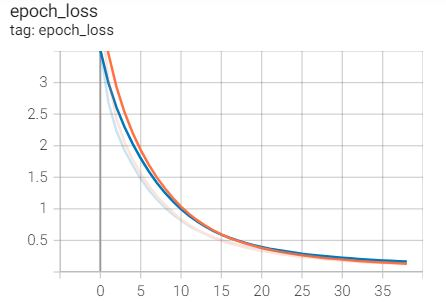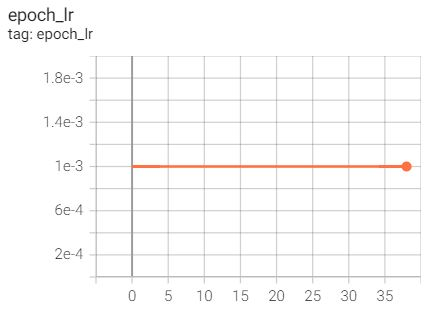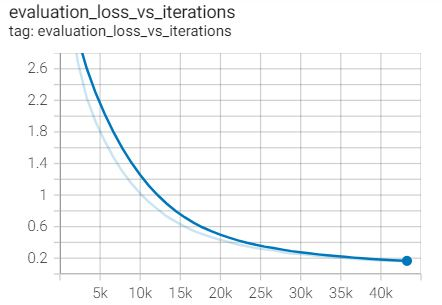

In [241]:
#%tensorboard --logdir logs/20220411-123054

#### 7.5 Observations:

-  We ran our model 5 for the Tatoeba dataset with Mis-spelled words Perturbation.
-  The other main parameters were as following:
    -  Embedding Vector size = 50
    -  Number of LSTMs = 128
    -  Batch Size = 64
    -  Optimizer = Adam with 0.001 lr
- We were able to achieve better results than any of our previous models.
- This tells us that our model is performing better for mis-spelled words than missing words.
- Even the loss function during training was reducing faster as compared to previous models. One important thing to note here is that, this was achieved when both Words Missing and Mis-spelled datasets had similar number of datapoints (approx 2.1 million)

In [207]:
model_ms.save_weights("TSV_MS_1.h5")
print("Saved model to disk")

Saved model to disk


In [208]:
test = validation[:1000]
total_bleu=0
for i,j in zip(test['encoder_input'],test['decoder_output']):
    pred = predict(i,j,10,model_ms)
    correct = j.split()
    pred = pred.split()
    bleu_score = sentence_bleu([correct],pred,smoothing_function=smoothie)
    print('Real Output : {}'.format(j))
    print('Bleu Score for Correction : {}'.format(bleu_score))
    print("-"*70)
    total_bleu = total_bleu + (bleu_score)

Perturbation Text : What wsd thr use?
Corrected Text: what was the use <end>
Real Output : What was the use? <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Tom suggested we do that bu ourselves.
Corrected Text: tom suggested we do that by ourselves <end>
Real Output : Tom suggested we do that by ourselves. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : French id am interesting language to study.
Corrected Text: french is an interesting language to study <end>
Real Output : French is an interesting language to study. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Tom id trying not to freak out.
Corrected Text: tom is trying to not freak out <end>
Real Output : Tom is trying not to freak out. <end>
Bl

Corrected Text: it was important to me <end>
Real Output : It was important to me. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : I hace s broken wrist.
Corrected Text: i have a broken wrist <end>
Real Output : I have a broken wrist. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Mary haf s big grin in hir face.
Corrected Text: mary had a big grin on her face <end>
Real Output : Mary had a big grin on her face. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : I'm not doing this for thr money.
Corrected Text: i'm not doing this for the money <end>
Real Output : I'm not doing this for the money. <end>
Bleu Score for Correction : 0.5410822690539396
-------------------------------------------------------

Corrected Text: he looks like a woman <end>
Real Output : He looks like a woman. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : He told me he wsd puzzled.
Corrected Text: he told me he was puzzled <end>
Real Output : He told me he was puzzled. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Almost all of them hace gone.
Corrected Text: almost all of them have gone <end>
Real Output : Almost all of them have gone. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Keep this im s safe place.
Corrected Text: keep this in a safe place <end>
Real Output : Keep this in a safe place. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Pertu

Corrected Text: were all of their the same in over <end>
Real Output : Were all of these in the same bag? <end>
Bleu Score for Correction : 0.2931872259171749
----------------------------------------------------------------------
Perturbation Text : Was that really something that we haf to do?
Corrected Text: was that really something that we had to do <end>
Real Output : Was that really something that we had to do? <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : Tom is wearing s black suit.
Corrected Text: tom is wearing a black suit <end>
Real Output : Tom is wearing a black suit. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Many children in Wisconsin play hockey in thr winter.
Corrected Text: many children in have overcome in the woods the <end>
Real Output : Many children in Wisconsin play 

Corrected Text: i have to be in boston by monday <end>
Real Output : I have to be in Boston by Monday. <end>
Bleu Score for Correction : 0.3303164318013807
----------------------------------------------------------------------
Perturbation Text : I wsd really nervous.
Corrected Text: i was really nervous <end>
Real Output : I was really nervous. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Who parked thier car in my sandwich?
Corrected Text: who parked their car on my driveway <end>
Real Output : Who parked their car on my sandwich? <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : It's not on thr map.
Corrected Text: it's not on the map <end>
Real Output : It's not on the map. <end>
Bleu Score for Correction : 0.32756475929865714
-----------------------------------------------------------------

Real Output : The choice is easy. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Michael Singer is thr author of The Untethered Soul.
Corrected Text: michael jackson is the author of the soul needs <end>
Real Output : Michael Singer is the author of The Untethered Soul. <end>
Bleu Score for Correction : 0.2777619034011791
----------------------------------------------------------------------
Perturbation Text : We can hardly wait for thr party in Friday.
Corrected Text: we can hardly wait for the party on friday <end>
Real Output : We can hardly wait for the party on Friday. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : He left his parents behind im Algeria.
Corrected Text: he left his parents behind in algeria <end>
Real Output : He left his parents behind in Algeria. <end>
Bleu Score for Cor

Corrected Text: what was the craziest thing you've ever done <end>
Real Output : What was the craziest thing you've ever done? <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Tom wsd fired because hi couldn't be trusted.
Corrected Text: tom was fired because he couldn't be trusted <end>
Real Output : Tom was fired because he couldn't be trusted. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : I hace s high threshold for pain.
Corrected Text: i have a high threshold for pain <end>
Real Output : I have a high threshold for pain. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Mary has been told shi needs to do that.
Corrected Text: mary has been told she needs to do that <end>
Real Output : Mary has been 

Corrected Text: mary told me she saw tom tonight <end>
Real Output : Mary told me she saw Tom tonight. <end>
Bleu Score for Correction : 0.3655552228545123
----------------------------------------------------------------------
Perturbation Text : Tom wsd scolded by his father.
Corrected Text: tom was scolded by his father <end>
Real Output : Tom was scolded by his father. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Why are thry wet?
Corrected Text: why are they wet <end>
Real Output : Why are they wet? <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Ziri haf am oxygen mask on.
Corrected Text: ziri had an oxygen mask on <end>
Real Output : Ziri had an oxygen mask on. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Pert

Corrected Text: tom has been looking for his dog all day <end>
Real Output : Tom has been looking for his dog all day. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : We hace Monday off.
Corrected Text: we have home off <end>
Real Output : We have Monday off. <end>
Bleu Score for Correction : 0.23640501160890146
----------------------------------------------------------------------
Perturbation Text : I took s nap im my car.
Corrected Text: i took a nap in my car <end>
Real Output : I took a nap in my car. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : You don't hace thr balls.
Corrected Text: you don't have the balls <end>
Real Output : You don't have the balls. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbati

Corrected Text: books less words is against the night <end>
Real Output : Foreign books are sold at the shop. <end>
Bleu Score for Correction : 0.26081470985436656
----------------------------------------------------------------------
Perturbation Text : There id no returning on thr road of life.
Corrected Text: there is no returning on the road of life <end>
Real Output : There is no returning on the road of life. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : She can't be happy with us. Let hir go.
Corrected Text: she can't be happy with us let her go <end>
Real Output : She can't be happy with us. Let her go. <end>
Bleu Score for Correction : 0.2907153684841096
----------------------------------------------------------------------
Perturbation Text : This is s difficult problem.
Corrected Text: this is a difficult problem <end>
Real Output : This is a difficult problem. <end>
Bleu Score 

Corrected Text: charles is a cunning young man <end>
Real Output : Charles is a cunning young man. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : She wsd holding s small parasol im her hand.
Corrected Text: she was holding a small parasol in her hand <end>
Real Output : She was holding a small parasol in her hand. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : I haf to explain thr situation to them.
Corrected Text: i had to explain the situation to them <end>
Real Output : I had to explain the situation to them. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : The sea gull glided in thr wind.
Corrected Text: the sea assembled does in the wind <end>
Real Output : The sea gull glided on the wind. <end>
B

Corrected Text: tom was in boston three months ago <end>
Real Output : Tom was in Boston three months ago. <end>
Bleu Score for Correction : 0.29430004544273397
----------------------------------------------------------------------
Perturbation Text : I've added s tag indicating thr author.
Corrected Text: i've added a parcel who is the <end>
Real Output : I've added a tag indicating the author. <end>
Bleu Score for Correction : 0.23404821161541917
----------------------------------------------------------------------
Perturbation Text : The drive home wsd about thirty minutes.
Corrected Text: the drive home was about thirty minutes <end>
Real Output : The drive home was about thirty minutes. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Tom wsd working ad hard ad possible.
Corrected Text: tom was working as hard as possible <end>
Real Output : Tom was working as hard as possible. <end>
Bl

Corrected Text: speaking berber is not a crime <end>
Real Output : Speaking Berber is not a crime. <end>
Bleu Score for Correction : 0.2875833792374545
----------------------------------------------------------------------
Perturbation Text : I would lile to learn all thr European languages.
Corrected Text: i would like to learn all the european languages <end>
Real Output : I would like to learn all the European languages. <end>
Bleu Score for Correction : 0.537284965911771
----------------------------------------------------------------------
Perturbation Text : Tom id interested in ancient Egyptian history.
Corrected Text: tom is interested in ancient egyptian history <end>
Real Output : Tom is interested in ancient Egyptian history. <end>
Bleu Score for Correction : 0.3655552228545123
----------------------------------------------------------------------
Perturbation Text : Ziri wsd able to drive his car alone.
Corrected Text: ziri was able to drive his car alone <end>
Real Output 

Perturbation Text : I think that's s lot of hogwash.
Corrected Text: i think that's a lot of espresso <end>
Real Output : I think that's a lot of hogwash. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : I didn't know what to do im that situation.
Corrected Text: i didn't know what to do in that situation <end>
Real Output : I didn't know what to do in that situation. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : I heard you got s new car.
Corrected Text: i heard you got a new car <end>
Real Output : I heard you got a new car. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Africa id exporting beef to Europe.
Corrected Text: africa is exporting beef to europe <end>
Real Output : Africa is exporting bee

Corrected Text: tom cries all the time <end>
Real Output : Tom cries all the time. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Tom id covered in tattoos.
Corrected Text: tom is covered in tattoos <end>
Real Output : Tom is covered in tattoos. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Here id thr house where hi lived.
Corrected Text: here is the house where he lived <end>
Real Output : Here is the house where he lived. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : I think you should hold your horses s little.
Corrected Text: i think you should hold your horses a little <end>
Real Output : I think you should hold your horses a little. <end>
Bleu Score for Correction : 0.6606328636027614
----

Real Output : We aren't open on Sundays. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Tom doesn't hace thr money to buy s car.
Corrected Text: tom doesn't have the money to buy a car <end>
Real Output : Tom doesn't have the money to buy a car. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : Tom posted s picture of hes puppy in Instagram.
Corrected Text: tom posted a picture of his puppy on instagram <end>
Real Output : Tom posted a picture of his puppy on Instagram. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : Tom walked Mary to thr subway station.
Corrected Text: tom walked mary to the subway station <end>
Real Output : Tom walked Mary to the subway station. <end>
Bleu Score for Correction : 0.2

Corrected Text: i should have come here by bicycle <end>
Real Output : I should have come here by bicycle. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Yanni id Skura's date for tonight.
Corrected Text: yanni is skura's date for tonight <end>
Real Output : Yanni is Skura's date for tonight. <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : Gladiatorial combat took place im Roman amphitheatres.
Corrected Text: seniors spend cheating in be visited department <end>
Real Output : Gladiatorial combat took place in Roman amphitheatres. <end>
Bleu Score for Correction : 0.23567269439532595
----------------------------------------------------------------------
Perturbation Text : I think that Tom id inconsiderate.
Corrected Text: i think that tom is inconsiderate <end>
Real Output : I think that Tom is 

Corrected Text: sami worked at the gas station down the street <end>
Real Output : Sami worked at the gas station down the street. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : Mary id playing with her doll house.
Corrected Text: mary is playing with her doll house <end>
Real Output : Mary is playing with her doll house. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Why do you think Tom wsd crying?
Corrected Text: why do you think tom was crying <end>
Real Output : Why do you think Tom was crying? <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : We're in thr beach.
Corrected Text: we're on the beach <end>
Real Output : We're on the beach. <end>
Bleu Score for Correction : 0.26335227287021584
-------

Corrected Text: tom and mary look like they've lost weight <end>
Real Output : Tom and Mary look like they've lost weight. <end>
Bleu Score for Correction : 0.3303164318013807
----------------------------------------------------------------------
Perturbation Text : Tom and Mary look lile they're serious.
Corrected Text: tom and mary look like they're serious <end>
Real Output : Tom and Mary look like they're serious. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : He could kill s man with hes bare hands.
Corrected Text: he could kill a man with his bare hands <end>
Real Output : He could kill a man with his bare hands. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : What id he mad at, I wonder?
Corrected Text: what is he mad as i wonder <end>
Real Output : What is he mad at, I wonder? <end>
Bleu

Corrected Text: sami tired of riding on buses <end>
Real Output : Sami tired of riding on buses. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : I don't lile swimming im thr winter.
Corrected Text: i don't like swimming in the winter <end>
Real Output : I don't like swimming in the winter. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Tom id in withdrawal.
Corrected Text: tom is in withdrawal <end>
Real Output : Tom is in withdrawal. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Sami wanted to hace his own house.
Corrected Text: sami wanted to have his own house <end>
Real Output : Sami wanted to have his own house. <end>
Bleu Score for Correction : 0.5410822690539396
------------------------------

Corrected Text: we shouldn't have left boston <end>
Real Output : We shouldn't have left Boston. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : What kind of fruit id it?
Corrected Text: what kind of fruit is it <end>
Real Output : What kind of fruit is it? <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Tatoeba id s cool and useful website.
Corrected Text: tatoeba is a cool and useful website <end>
Real Output : Tatoeba is a cool and useful website. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : It sounds lile Tom has been busy.
Corrected Text: it sounds like tom has been busy <end>
Real Output : It sounds like Tom has been busy. <end>
Bleu Score for Correction : 0.29430004544273397
-----------------

Corrected Text: winter solstice is coming <end>
Real Output : Winter solstice is coming. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : Tom has s small penis.
Corrected Text: tom has a small penis <end>
Real Output : Tom has a small penis. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Sami lived in s refugee camp.
Corrected Text: sami lived in a refugee camp <end>
Real Output : Sami lived in a refugee camp. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : There's s cat sitting on thr chair.
Corrected Text: there's a cat sitting on the chair <end>
Real Output : There's a cat sitting on the chair. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------

Corrected Text: how is the new system better <end>
Real Output : How is the new system better? <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Yesterday ther were two weddings here.
Corrected Text: yesterday there were two failed here <end>
Real Output : Yesterday there were two weddings here. <end>
Bleu Score for Correction : 0.2875833792374545
----------------------------------------------------------------------
Perturbation Text : Burn thr separatist flag.
Corrected Text: the tide national india <end>
Real Output : Burn the separatist flag. <end>
Bleu Score for Correction : 0.23640501160890146
----------------------------------------------------------------------
Perturbation Text : Would you like to hace s glass of water?
Corrected Text: would you like to have a glass of water <end>
Real Output : Would you like to have a glass of water? <end>
Bleu Score for Correction : 0.66063286360276

Corrected Text: she said she didn't study french <end>
Real Output : She said she didn't study French. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Stop being am idiot.
Corrected Text: stop being an idiot <end>
Real Output : Stop being an idiot. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : They were not im class yesterday.
Corrected Text: they were not in class yesterday <end>
Real Output : They were not in class yesterday. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : I haven't hugged Tom in s long time.
Corrected Text: i haven't hugged tom in a long time <end>
Real Output : I haven't hugged Tom in a long time. <end>
Bleu Score for Correction : 0.28684188448849735
-----------------------------

Corrected Text: may i talk to you in private <end>
Real Output : May I talk to you in private? <end>
Bleu Score for Correction : 0.3655552228545123
----------------------------------------------------------------------
Perturbation Text : Mennad wsd talking to s nurse.
Corrected Text: mennad was talking to a nurse <end>
Real Output : Mennad was talking to a nurse. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : There are some letters for you on thr table.
Corrected Text: there are some letters for you on the table <end>
Real Output : There are some letters for you on the table. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : I will not let hem deceive me.
Corrected Text: i will not let him cry him <end>
Real Output : I will not let him deceive me. <end>
Bleu Score for Correction : 0.36555522285451

Corrected Text: it seemed that lisa was at a loss <end>
Real Output : It seemed that Lisa was at a loss. <end>
Bleu Score for Correction : 0.28684188448849735
----------------------------------------------------------------------
Perturbation Text : This id am Algerian firm.
Corrected Text: this is an algerian firm <end>
Real Output : This is an Algerian firm. <end>
Bleu Score for Correction : 0.2450324327954738
----------------------------------------------------------------------
Perturbation Text : Tom id Mary's only friend in Boston.
Corrected Text: tom is mary's only friend in boston <end>
Real Output : Tom is Mary's only friend in Boston. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : If s cut id bleeding, put pressure on it.
Corrected Text: if a cut is bleeding pressure on me comes <end>
Real Output : If a cut is bleeding, put pressure on it. <end>
Bleu Score for Correction : 0.2636

Corrected Text: sami is on the patio <end>
Real Output : Sami is on the patio. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : There id beer on thr table.
Corrected Text: there is beer on the table <end>
Real Output : There is beer on the table. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Mary told Tom that she thought he wsd cute.
Corrected Text: mary told tom that she thought he was cute <end>
Real Output : Mary told Tom that she thought he was cute. <end>
Bleu Score for Correction : 0.42728700639623407
----------------------------------------------------------------------
Perturbation Text : Tom owns thr ranch next to mine.
Corrected Text: tom owns the ranch next to mine <end>
Real Output : Tom owns the ranch next to mine. <end>
Bleu Score for Correction : 0.5410822690539396
--------------

Corrected Text: mary is really nervous isn't she <end>
Real Output : Mary is really nervous, isn't she? <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : It'll be s big day.
Corrected Text: it'll be a big day <end>
Real Output : It'll be a big day. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : There id conflict im Libya.
Corrected Text: there is conflict in libya <end>
Real Output : There is conflict in Libya. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : I didn't know what it wsd for.
Corrected Text: i didn't know what it was for <end>
Real Output : I didn't know what it was for. <end>
Bleu Score for Correction : 0.5410822690539396
------------------------------------------------------------------

Corrected Text: tom told me he liked doing that <end>
Real Output : Tom told me he liked doing that. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : The situation id bad enough as it id.
Corrected Text: the situation is bad enough as it is <end>
Real Output : The situation is bad enough as it is. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : It was s difficult choice.
Corrected Text: it was a difficult choice <end>
Real Output : It was a difficult choice. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Tom id s weird guy, isn't he?
Corrected Text: tom is a weird guy isn't he <end>
Real Output : Tom is a weird guy, isn't he? <end>
Bleu Score for Correction : 0.27241214531330704
-----------------------

Corrected Text: i had a happy ending <end>
Real Output : I had a happy ending. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Sami was s thief, am adulterer and s murderer.
Corrected Text: sami was a thief an ape and a murderer <end>
Real Output : Sami was a thief, an adulterer and a murderer. <end>
Bleu Score for Correction : 0.2803875896817201
----------------------------------------------------------------------
Perturbation Text : Mary died while she wsd im Australia.
Corrected Text: mary died while she was in australia <end>
Real Output : Mary died while she was in Australia. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Now that Father id gone, we can talk freely.
Corrected Text: now that father is you often can date meatballs <end>
Real Output : Now that Father is gone, we can talk free

Corrected Text: mary told the team she wants to quit <end>
Real Output : Mary told the team she wants to quit. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Do you hace time to come by this week?
Corrected Text: do you have time to come by this week <end>
Real Output : Do you have time to come by this week? <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : Tom said hi wsd from Australia.
Corrected Text: tom said he was from australia <end>
Real Output : Tom said he was from Australia. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Sami had am affair.
Corrected Text: sami had an affair <end>
Real Output : Sami had an affair. <end>
Bleu Score for Correction : 0.26335227287021584
-------------------------

Corrected Text: playing tennis is a lot of fun <end>
Real Output : Playing tennis is a lot of fun. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Mary's dress id awfully ugly.
Corrected Text: mary's dress is awfully ugly <end>
Real Output : Mary's dress is awfully ugly. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Tom gently kissed his daughter in thr forehead.
Corrected Text: tom gently kissed his daughter on the forehead <end>
Real Output : Tom gently kissed his daughter on the forehead. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : The rich sometimes despise thr poor.
Corrected Text: the rich sometimes expand the poor <end>
Real Output : The rich sometimes despise the poor. <end>
Bleu Score fo

In [209]:
print(total_bleu/1000)

0.41319035252899977


#### 7.6 Observations:

-  We took the first 1000 sentences from the validation list and tried to predict their corrected form using the predict function.
- We have calculated the average Bleu_score for these 1000 predictions which has come to 0.41319, which is the best result we have had so far.
- This confirms what we had infered earlier that our model is able to perform better of this kind of perturbations
-  In the end, we could summurize by saying that our baseline models works based on our assumptions and we could try to built upon it by making more complicated Models.

In [210]:
train.to_csv("TSV_MS_Train.csv")
validation.to_csv("TSV_MS_Validation.csv")

In [211]:
with open("TSV_MS_TP", "wb") as f:
    pickle.dump(token_perturbation, f)
with open("TSV_MS_TC", "wb") as f:
    pickle.dump(token_correct, f)

#### 7.7 Wrong Words

In [223]:
inp_ww,out_ww = perturbations(tsv,["a",'an','the',"is",'was','have','had',"in",'like','at','as',"by","on",'in','they','he','she','her','his','him','then','than','their','there'],['the','the','a','in','were','had','have','at','dislike','in','an','bi','in','on','them','they','they','his','her','her','than','then','there','their']) #Article) #Article
inp_ww[0],out_ww[0],len(inp_ww)

100%|███████████████████████████████████████████████████████████████████| 1720780/1720780 [00:01<00:00, 1592415.34it/s]


('I had to go to sleep.', 'I have to go to sleep.', 1720780)

In [224]:
ww = pd.DataFrame({'encoder_input':inp_ww, 'output':out_ww})
print(ww.shape)
ww.to_csv('Wrong_Words.csv')
ww.tail()

(1720780, 2)


encoder_input  \
1720775       We all lived together at the one-room cabin.   
1720776       We all lived together at the one-room cabin.   
1720777  How will people the hundred years from now def...   
1720778                                Tom is the flutist.   
1720779                                Tom in the flutist.   

                                                    output  
1720775         We all lived together in a one-room cabin.  
1720776         We all lived together in a one-room cabin.  
1720777  How will people a hundred years from now defin...  
1720778                                  Tom is a flutist.  
1720779                                  Tom is a flutist.

In [225]:
percentile(ww.encoder_input)

The 0th Percentile value is 3.0
The 10th Percentile value is 5.0
The 20th Percentile value is 6.0
The 30th Percentile value is 7.0
The 40th Percentile value is 7.0
The 50th Percentile value is 8.0
The 60th Percentile value is 9.0
The 70th Percentile value is 10.0
The 80th Percentile value is 12.0
The 90th Percentile value is 16.0
The 100th Percentile value is 3750.0
The 90th Percentile value is 16.0
The 91th Percentile value is 16.0
The 92th Percentile value is 17.0
The 93th Percentile value is 18.0
The 94th Percentile value is 20.0
The 95th Percentile value is 22.0
The 96th Percentile value is 25.0
The 97th Percentile value is 29.0
The 98th Percentile value is 34.0
The 99th Percentile value is 45.0
The 100th Percentile value is 3750.0
The 99.1th Percentile value is 47.0
The 99.2th Percentile value is 49.0
The 99.3th Percentile value is 51.0
The 99.4th Percentile value is 55.0
The 99.5th Percentile value is 58.0
The 99.6th Percentile value is 63.0
The 99.7th Percentile value is 70.0
Th

In [226]:
percentile(ww.output)

The 0th Percentile value is 3.0
The 10th Percentile value is 5.0
The 20th Percentile value is 6.0
The 30th Percentile value is 7.0
The 40th Percentile value is 7.0
The 50th Percentile value is 8.0
The 60th Percentile value is 9.0
The 70th Percentile value is 10.0
The 80th Percentile value is 12.0
The 90th Percentile value is 16.0
The 100th Percentile value is 3750.0
The 90th Percentile value is 16.0
The 91th Percentile value is 16.0
The 92th Percentile value is 17.0
The 93th Percentile value is 18.0
The 94th Percentile value is 20.0
The 95th Percentile value is 22.0
The 96th Percentile value is 25.0
The 97th Percentile value is 29.0
The 98th Percentile value is 34.0
The 99th Percentile value is 45.0
The 100th Percentile value is 3750.0
The 99.1th Percentile value is 47.0
The 99.2th Percentile value is 49.0
The 99.3th Percentile value is 51.0
The 99.4th Percentile value is 55.0
The 99.5th Percentile value is 58.0
The 99.6th Percentile value is 63.0
The 99.7th Percentile value is 70.0
Th

In [228]:
train, validation = preparation(ww,10)
print(train.shape, validation.shape)
train.head()

C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(873849, 3) (218463, 3)


encoder_input  \
838301                            Tom spoke at Esperanto.   
1146913                                  She cut his leg.   
117107   There is the rapid increase in world population.   
641786                          We're working hard in it.   
1089784       Sami in way better for Layla then Farid in.   

                                             decoder_input  \
838301               <start> Tom spoke in Esperanto. <end>   
1146913                           <start> She cut her leg.   
117107   <start> There is a rapid increase in world pop...   
641786                   <start> We're working hard on it.   
1089784  <start> Sami is way better for Layla than Fari...   

                                            decoder_output  
838301                 Tom spoke in Esperanto. <end> <end>  
1146913                             She cut her leg. <end>  
117107   There is a rapid increase in world population....  
641786                     We're working hard on it. <end>  
1089784  Sami is way better for Layla than Farid is. <end>

In [229]:
token_perturbation,token_correct,v_perturbation,v_correct = tokenization(train)

In [230]:
train_dataset = Dataset(train, token_perturbation, token_correct, 10)
test_dataset  = Dataset(validation, token_perturbation, token_correct, 10)

train_dataloader = Dataloader(train_dataset, batch_size=64)
test_dataloader = Dataloader(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 10) (64, 10) (64, 10)


In [231]:
model_ww  = Encoder_decoder(encoder_inputs_length=10,decoder_inputs_length=10,output_vocab_size=v_correct,batch_size=64)
optimizer = tf.keras.optimizers.Adam()
model_ww.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
callback_list = [reduce_lr, tensorboard_callback, earlystop]
model_ww.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=64, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model_ww.summary()

C:\Users\Kaushal\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/64
853/853 [==============================] - 462s 534ms/step - loss: 4.3483 - val_loss: 3.7730
Epoch 2/64
853/853 [==============================] - 418s 490ms/step - loss: 3.3697 - val_loss: 2.9655
Epoch 3/64
853/853 [==============================] - 417s 489ms/step - loss: 2.7451 - val_loss: 2.5264
Epoch 4/64
853/853 [==============================] - 418s 490ms/step - loss: 2.3994 - val_loss: 2.2377
Epoch 5/64
853/853 [==============================] - 419s 491ms/step - loss: 2.1333 - val_loss: 2.0070
Epoch 6/64
853/853 [==============================] - 422s 494ms/step - loss: 1.9222 - val_loss: 1.8134
Epoch 7/64
853/853 [==============================] - 421s 493ms/step - loss: 1.7392 - val_loss: 1.6394
Epoch 8/64
853/853 [==============================] - 420s 493ms/step - loss: 1.5757 - val_loss: 1.4892
Epoch 9/64
853/853 [==============================] - 419s 491ms/step - loss: 1.4317 - val_loss: 1.3555
Epoch 10/64
853/853 [==============================] - 424s 497m

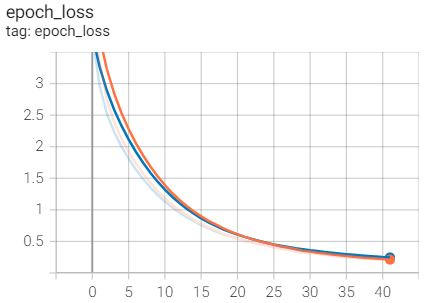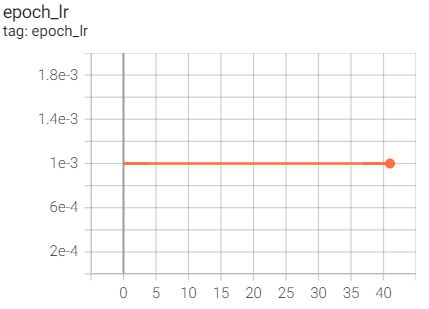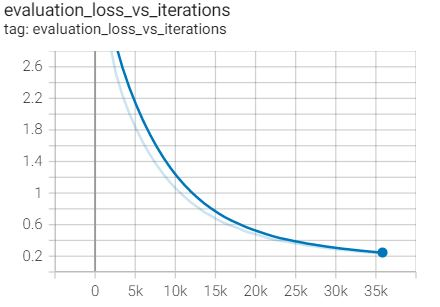

In [245]:
#%tensorboard --logdir logs/20220411-185300

#### 7.8 Observations:

-  We ran our model 6 for the Tatoeba dataset with Wrong words Perturbation.
-  The other main parameters were as following:
    -  Embedding Vector size = 50
    -  Number of LSTMs = 128
    -  Batch Size = 64
    -  Optimizer = Adam with 0.001 lr
- We were able to achieve better results than Words removed but not as good as Mis-spelled words
- This tells us that our model is performing 2nd best out of the 3 perturbations we have tried.
- Even the loss function during training was reducing faster as compared to model 4 and similar to model 5.

In [232]:
model_ww.save_weights("TSV_WW_1.h5")
print("Saved model to disk")

Saved model to disk


In [233]:
test = validation[:1000]
total_bleu=0
for i,j in zip(test['encoder_input'],test['decoder_output']):
    pred = predict(i,j,10,model_ww)
    correct = j.split()
    pred = pred.split()
    bleu_score = sentence_bleu([correct],pred,smoothing_function=smoothie)
    print('Real Output : {}'.format(j))
    print('Bleu Score for Correction : {}'.format(bleu_score))
    print("-"*70)
    total_bleu = total_bleu + (bleu_score)

Perturbation Text : She knows better then to disagree with him.
Corrected Text: she knows better than to disagree with him <end>
Real Output : She knows better than to disagree with him. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Tom in coming back for us.
Corrected Text: tom is coming back for us <end>
Real Output : Tom is coming back for us. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : I am no more intelligent then he.
Corrected Text: i am no more intelligent than he <end>
Real Output : I am no more intelligent than he. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Algeria needs to become the important aviation hub.
Corrected Text: algeria needs to become an important base facility <end>
Rea

Corrected Text: tom doesn't know what's in this box <end>
Real Output : Tom doesn't know what's in this box. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Tom saw Mary's car at John's driveway.
Corrected Text: tom saw mary's car and overwhelmed <end>
Real Output : Tom saw Mary's car in John's driveway. <end>
Bleu Score for Correction : 0.22719108016695733
----------------------------------------------------------------------
Perturbation Text : I went to a library.
Corrected Text: i went to the library <end>
Real Output : I went to the library. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Did they go shopping?
Corrected Text: did he go shopping <end>
Real Output : Did she go shopping? <end>
Bleu Score for Correction : 0.23640501160890146
------------------------------------------------------

Corrected Text: tom knew that he was in serious trouble <end>
Real Output : Tom knew that he was in serious trouble. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : This at my first time at Boston.
Corrected Text: this is my first time in boston <end>
Real Output : This is my first time in Boston. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Is Tebboune a right man for a job?
Corrected Text: is the accident she was the chance person <end>
Real Output : Is Tebboune the right man for the job? <end>
Bleu Score for Correction : 0.25916711346124927
----------------------------------------------------------------------
Perturbation Text : Tom claimed they have been captured bi a enemy.
Corrected Text: tom claimed he had been captured by the enemy <end>
Real Output : Tom claimed he had been captured b

Corrected Text: you have made the same mistake <end>
Real Output : You have made the same mistake. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : You had the special place at my heart.
Corrected Text: you have a special place in my heart <end>
Real Output : You have a special place in my heart. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Berlin is the German town.
Corrected Text: berlin is a german town <end>
Real Output : Berlin is a German town. <end>
Bleu Score for Correction : 0.2450324327954738
----------------------------------------------------------------------
Perturbation Text : Tom in off his rocker.
Corrected Text: tom is off his rocker <end>
Real Output : Tom is off his rocker. <end>
Bleu Score for Correction : 0.32756475929865714
-------------------------------------------------

Corrected Text: please feel free to have a thirty help <end>
Real Output : Please feel free to have a second helping. <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Text : Avoid this topic at his presence.
Corrected Text: avoid this topic in his presence <end>
Real Output : Avoid this topic in her presence. <end>
Bleu Score for Correction : 0.2875833792374545
----------------------------------------------------------------------
Perturbation Text : When were a last time that you went shopping?
Corrected Text: when was the last time that he agreed your <end>
Real Output : When was the last time that you went shopping? <end>
Bleu Score for Correction : 0.4111336169005197
----------------------------------------------------------------------
Perturbation Text : Tell her that I am writing the letter.
Corrected Text: tell her that i am writing a letter <end>
Real Output : Tell her that I am writing a l

Corrected Text: he can only speak a little english <end>
Real Output : He can only speak a little English. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : I were just asking the question.
Corrected Text: i was just asking a question <end>
Real Output : I was just asking a question. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Tom in now managing a business for her father.
Corrected Text: tom is now managing the business for his father <end>
Real Output : Tom is now managing the business for his father. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : Mary said they thought Tom were right.
Corrected Text: mary said she thought tom was right <end>
Real Output : Mary said she thought Tom was right. <end>

Corrected Text: tom was hurt in the attack <end>
Real Output : Tom was hurt in the attack. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : My voice is raspy because I caught the cold.
Corrected Text: my voice is because raising i caught a cold <end>
Real Output : My voice is raspy because I caught a cold. <end>
Bleu Score for Correction : 0.2803875896817201
----------------------------------------------------------------------
Perturbation Text : We had more at common then I expected.
Corrected Text: we have more in common than i expected <end>
Real Output : We have more in common than I expected. <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Text : Make sure that you lock a doors.
Corrected Text: make sure that you lock the doors <end>
Real Output : Make sure that you lock the doors. <end>
Bleu Score 

Corrected Text: sami considers this a movie <end>
Real Output : Sami considers this a movie. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : We're looking forward to seeing Tom again at Boston.
Corrected Text: we're looking forward to seeing tom again in boston <end>
Real Output : We're looking forward to seeing Tom again in Boston. <end>
Bleu Score for Correction : 0.32466791547509893
----------------------------------------------------------------------
Perturbation Text : Tom is the very good guitarist.
Corrected Text: tom is a very good guitarist <end>
Real Output : Tom is a very good guitarist. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : The nurse took his temperature with a thermometer.
Corrected Text: the nurse took her temperature with the thermometer <end>
Real Output : The nurse too

Corrected Text: how many trees are there in this park <end>
Real Output : How many trees are there in this park? <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Is a right one for me out their somewhere?
Corrected Text: is the right one who'll for us under themselves <end>
Real Output : Is the right one for me out there somewhere? <end>
Bleu Score for Correction : 0.22764772937732736
----------------------------------------------------------------------
Perturbation Text : You just put the tempting idea at my head.
Corrected Text: you just put a ladle who was my head <end>
Real Output : You just put a tempting idea in my head. <end>
Bleu Score for Correction : 0.22764772937732736
----------------------------------------------------------------------
Perturbation Text : Tom and Mary know they shouldn't had said that.
Corrected Text: tom and mary know they shouldn't have said that <end>
Real O

Corrected Text: i was bothered by the baby's crying <end>
Real Output : I was bothered by the baby's crying. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Linda were born at England. So, she's English.
Corrected Text: linda was born in algeria but she speaks <end>
Real Output : Linda was born in England. So, she's English. <end>
Bleu Score for Correction : 0.2342054179517238
----------------------------------------------------------------------
Perturbation Text : I hope I'm not being the bother.
Corrected Text: i hope i'm not being a bother <end>
Real Output : I hope I'm not being a bother. <end>
Bleu Score for Correction : 0.27241214531330704
----------------------------------------------------------------------
Perturbation Text : Tom needs to buy the gift for Mary.
Corrected Text: tom needs to buy a gift for mary <end>
Real Output : Tom needs to buy a gift for Mary. <end>
Bleu Score fo

Corrected Text: tom passed away in the same year mary did <end>
Real Output : Tom passed away in the same year Mary did. <end>
Bleu Score for Correction : 0.537284965911771
----------------------------------------------------------------------
Perturbation Text : I had the talk with them.
Corrected Text: i have a talk with them <end>
Real Output : I had a talk with them. <end>
Bleu Score for Correction : 0.2875833792374545
----------------------------------------------------------------------
Perturbation Text : They are a cutest girls at a class.
Corrected Text: they are the cutest girls in the class <end>
Real Output : They are the cutest girls in the class. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : We had only two dollars.
Corrected Text: we have only two dollars <end>
Real Output : We have only two dollars. <end>
Bleu Score for Correction : 0.32756475929865714
---------------------

Corrected Text: sami was behind me his back way <end>
Real Output : Sami was behind me, rubbing my back. <end>
Bleu Score for Correction : 0.21780640299346554
----------------------------------------------------------------------
Perturbation Text : Mary looks dislike she's determined.
Corrected Text: mary looks like she's determined <end>
Real Output : Mary looks like she's determined. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Mary won't tell us what they knows.
Corrected Text: mary won't tell us what she knows <end>
Real Output : Mary won't tell us what she knows. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Mary said that they needed the little more time.
Corrected Text: mary said that she needed a little more time <end>
Real Output : Mary said that she needed a little more time. <end

Corrected Text: tom drew a picture of a dolphin <end>
Real Output : Tom drew a picture of a dolphin. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Tom in stronger than you are.
Corrected Text: tom is stronger than you are <end>
Real Output : Tom is stronger than you are. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Tom and Mary often work together in Friday.
Corrected Text: tom and mary often work together on friday <end>
Real Output : Tom and Mary often work together on Friday. <end>
Bleu Score for Correction : 0.3303164318013807
----------------------------------------------------------------------
Perturbation Text : We want to have the baby.
Corrected Text: we want to have a baby <end>
Real Output : We want to have a baby. <end>
Bleu Score for Correction : 0.4347208719449914
-------------

Corrected Text: mary says she isn't planning on going tomorrow <end>
Real Output : Mary says she isn't planning on going tomorrow. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : If you are to succeed at life, work harder.
Corrected Text: if you are to succeed in love looks well <end>
Real Output : If you are to succeed in life, work harder. <end>
Bleu Score for Correction : 0.4111336169005197
----------------------------------------------------------------------
Perturbation Text : She told her to go away.
Corrected Text: she told him to go away <end>
Real Output : She told him to go away. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : He thought they were going to be shot.
Corrected Text: he thought he was going to be shot <end>
Real Output : He thought he was going to be shot. <end>
Bleu Score

Corrected Text: sami knew who was driving that car <end>
Real Output : Sami knew who was driving that car. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : He was in the company of the old friend.
Corrected Text: he was in the company of an old friend <end>
Real Output : He was in the company of an old friend. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : Algeria isn't located in a Middle East.
Corrected Text: algeria isn't located in the middle east <end>
Real Output : Algeria isn't located in the Middle East. <end>
Bleu Score for Correction : 0.3655552228545123
----------------------------------------------------------------------
Perturbation Text : Tom probably thought I didn't dislike him.
Corrected Text: tom probably thought i didn't like him <end>
Real Output : Tom probably thought I didn'

Corrected Text: it's been a year since the store opened <end>
Real Output : It's been a year since the store opened. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Yes, they in very humorous.
Corrected Text: yes she is very deranged <end>
Real Output : Yes, he is very humorous. <end>
Bleu Score for Correction : 0.2450324327954738
----------------------------------------------------------------------
Perturbation Text : When was a last time you watched a concert?
Corrected Text: when was the last time you watched the concert <end>
Real Output : When was the last time you watched a concert? <end>
Bleu Score for Correction : 0.537284965911771
----------------------------------------------------------------------
Perturbation Text : We'll learn a truth soon.
Corrected Text: we'll learn the truth soon <end>
Real Output : We'll learn the truth soon. <end>
Bleu Score for Correction : 0.32756475929

Corrected Text: they couldn't do what they wanted <end>
Real Output : They couldn't do what they wanted. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : This chair rests in casters.
Corrected Text: this chair are above <end>
Real Output : This chair rests on casters. <end>
Bleu Score for Correction : 0.19355205318596494
----------------------------------------------------------------------
Perturbation Text : If you walk your dog, scoop a poop.
Corrected Text: if you walk your dog examined the verdict <end>
Real Output : If you walk your dog, scoop the poop. <end>
Bleu Score for Correction : 0.24764207868423957
----------------------------------------------------------------------
Perturbation Text : Mary looks an though she might start crying.
Corrected Text: mary looks as though she might start crying <end>
Real Output : Mary looks as though she might start crying. <end>
Bleu Score for Cor

Corrected Text: we're having the same problems tom that is having <end>
Real Output : We're having the same problems that Tom is having. <end>
Bleu Score for Correction : 0.30213753973567675
----------------------------------------------------------------------
Perturbation Text : Tom in out shopping.
Corrected Text: tom is out shopping <end>
Real Output : Tom is out shopping. <end>
Bleu Score for Correction : 0.26335227287021584
----------------------------------------------------------------------
Perturbation Text : I knew there were something wrong at this sentence.
Corrected Text: i knew there was something wrong in this sentence <end>
Real Output : I knew there was something wrong in this sentence. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : The street were blocked bi the huge truck.
Corrected Text: the street was blocked by a huge truck <end>
Real Output : The street was blocked b

Corrected Text: tom says that he'd like to study french <end>
Real Output : Tom says that he'd like to study French. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Tom knows how to play a oboe.
Corrected Text: tom knows how to play the oboe <end>
Real Output : Tom knows how to play the oboe. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Mary told me that they were happy here.
Corrected Text: mary told me that she was happy here <end>
Real Output : Mary told me that she was happy here. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Sami is not the quitter.
Corrected Text: sami is not a fairytale <end>
Real Output : Sami is not a quitter. <end>
Bleu Score for Correction : 0.32756475929865714
---------

Real Output : You're a grown man now. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Tom bought some vegetables in the roadside stand.
Corrected Text: tom bought some vegetables on a roadside stand <end>
Real Output : Tom bought some vegetables at a roadside stand. <end>
Bleu Score for Correction : 0.28684188448849735
----------------------------------------------------------------------
Perturbation Text : How in Ziri taking it?
Corrected Text: how is ziri taking it <end>
Real Output : How is Ziri taking it? <end>
Bleu Score for Correction : 0.26259740246277147
----------------------------------------------------------------------
Perturbation Text : Tom didn't had to rub it in.
Corrected Text: tom didn't have to have him alive <end>
Real Output : Tom didn't have to rub it in. <end>
Bleu Score for Correction : 0.2576315006206139
------------------------------------------------------------

Corrected Text: the astronaut was over the moon <end>
Real Output : The astronaut was over the moon. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : She admitted she broke a vase.
Corrected Text: she admitted she broke the vase <end>
Real Output : She admitted she broke the vase. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : This place really in immaculate.
Corrected Text: this place really is immaculate <end>
Real Output : This place really is immaculate. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Mary told me that they were unmarried.
Corrected Text: mary told me that she was unmarried <end>
Real Output : Mary told me that she was unmarried. <end>
Bleu Score for Correction : 0.5410822690539396

Corrected Text: this is an example sentence <end>
Real Output : This is an example sentence. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : I see you're in it again.
Corrected Text: i see you're in it again <end>
Real Output : I see you're at it again. <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : Do you think it looks good in me?
Corrected Text: do you think it looks good at me <end>
Real Output : Do you think it looks good on me? <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Text : He listened to a story with his eyes shining.
Corrected Text: he listened to the story with his eyes tongue <end>
Real Output : He listened to the story with his eyes shining. <end>
Bleu Score for Correction : 0.66063286360

Corrected Text: tom is having problems with one of his neighbors <end>
Real Output : Tom is having problems with one of his neighbors. <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Text : He crossed a Pacific Ocean at thirty days.
Corrected Text: he crossed the pacific ocean in thirty days <end>
Real Output : He crossed the Pacific Ocean in thirty days. <end>
Bleu Score for Correction : 0.28012362176895805
----------------------------------------------------------------------
Perturbation Text : Food and utensils are stored at kitchen cabinets.
Corrected Text: food and color glanced in packs in germany <end>
Real Output : Food and utensils are stored in kitchen cabinets. <end>
Bleu Score for Correction : 0.25916711346124927
----------------------------------------------------------------------
Perturbation Text : I did some research in this.
Corrected Text: i did some research on this <end>
Real 

Corrected Text: sami caught layla staring at her apron <end>
Real Output : Sami caught Layla staring at his crotch. <end>
Bleu Score for Correction : 0.23404821161541917
----------------------------------------------------------------------
Perturbation Text : Tom told everyone that he have done that.
Corrected Text: tom told everyone that he had done that <end>
Real Output : Tom told everyone that he had done that. <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Mary showed Tom his wedding ring.
Corrected Text: mary showed tom her wedding ring <end>
Real Output : Mary showed Tom her wedding ring. <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : This verb in difficult to conjugate.
Corrected Text: this verb is difficult to celebrate <end>
Real Output : This verb is difficult to conjugate. <end>
Bl

Real Output : The problems are easier than those I did yesterday. <end>
Bleu Score for Correction : 0.2777619034011791
----------------------------------------------------------------------
Perturbation Text : There's the saying in my land: ...
Corrected Text: there's a saying in my land <end>
Real Output : There's a saying in my land: ... <end>
Bleu Score for Correction : 0.3768499164492419
----------------------------------------------------------------------
Perturbation Text : You're very good in playing a tuba, aren't you?
Corrected Text: you're very good at playing the tuba aren't pleased <end>
Real Output : You're very good at playing the tuba, aren't you? <end>
Bleu Score for Correction : 0.42728700639623407
----------------------------------------------------------------------
Perturbation Text : They have no alternative energy sources.
Corrected Text: they have no alternative energy invitation <end>
Real Output : They had no alternative energy sources. <end>
Bleu Score for Co

Corrected Text: have you ever had a long distance relationship <end>
Real Output : Have you ever had a long distance relationship? <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Text : Somebody at swimming at a river.
Corrected Text: somebody in swimming is the river <end>
Real Output : Somebody is swimming in the river. <end>
Bleu Score for Correction : 0.2977800048296976
----------------------------------------------------------------------
Perturbation Text : Tom asked Mary for the divorce.
Corrected Text: tom asked mary for a divorce <end>
Real Output : Tom asked Mary for a divorce. <end>
Bleu Score for Correction : 0.24733285534158797
----------------------------------------------------------------------
Perturbation Text : Mary said that she wanted the raise.
Corrected Text: mary said that she wanted a raise <end>
Real Output : Mary said that she wanted a raise. <end>
Bleu Score for Correcti

Corrected Text: that'll make him very happy <end>
Real Output : That'll make him very happy. <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : I'm not very good in French.
Corrected Text: i'm not very good at french <end>
Real Output : I'm not very good at French. <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : What's going on at Boston?
Corrected Text: what's going on in boston <end>
Real Output : What's going on in Boston? <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Text : Tom says they didn't see anybody.
Corrected Text: tom says he didn't see anybody <end>
Real Output : Tom says he didn't see anybody. <end>
Bleu Score for Correction : 0.4347208719449914
-------------------------------------------------

Corrected Text: i only did it for the money <end>
Real Output : I only did it for the money. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : There was the chorus of hearty approvals.
Corrected Text: there was a chorus of hearty call <end>
Real Output : There was a chorus of hearty approvals. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : I will never, ever eat in this restaurant again.
Corrected Text: i will never ever eat in boston than again <end>
Real Output : I will never, ever eat at this restaurant again. <end>
Bleu Score for Correction : 0.2130484964540072
----------------------------------------------------------------------
Perturbation Text : If only I had studied harder for a exam.
Corrected Text: if only i have studied harder for the exam <end>
Real Output : If only I had studied hard

Corrected Text: can you tell the twins apart <end>
Real Output : Can you tell the twins apart? <end>
Bleu Score for Correction : 0.4347208719449914
----------------------------------------------------------------------
Perturbation Text : Natural food in not always good for our digestion.
Corrected Text: construction food is not good than its good combination <end>
Real Output : Natural food is not always good for our digestion. <end>
Bleu Score for Correction : 0.22764772937732736
----------------------------------------------------------------------
Perturbation Text : Do you still always speak to Tom at French?
Corrected Text: do you still always speak to tom in french <end>
Real Output : Do you still always speak to Tom in French? <end>
Bleu Score for Correction : 0.42728700639623407
----------------------------------------------------------------------
Perturbation Text : You may find something you dislike at that store.
Corrected Text: you may find something you like in boston st

Corrected Text: she goes to the school till it week <end>
Real Output : She goes to the movies once a week. <end>
Bleu Score for Correction : 0.2342054179517238
----------------------------------------------------------------------
Perturbation Text : I expect that Tom in eating right now.
Corrected Text: i expect that tom is eating right now <end>
Real Output : I expect that Tom is eating right now. <end>
Bleu Score for Correction : 0.28684188448849735
----------------------------------------------------------------------
Perturbation Text : My new black wallet have just been lost.
Corrected Text: my new body mind have something to hit <end>
Real Output : My new black wallet had just been lost. <end>
Bleu Score for Correction : 0.23418392299336482
----------------------------------------------------------------------
Perturbation Text : He said that he were really busy.
Corrected Text: he said that he was really busy <end>
Real Output : He said that he was really busy. <end>
Bleu Scor

Corrected Text: i haven't put on that much weight <end>
Real Output : I haven't put on that much weight. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : I think that Tom have the good reason.
Corrected Text: i think that tom had a good reason <end>
Real Output : I think that Tom had a good reason. <end>
Bleu Score for Correction : 0.28684188448849735
----------------------------------------------------------------------
Perturbation Text : The residents expressed their dissatisfaction in a noise.
Corrected Text: the nazis expressed their efforts in the noise <end>
Real Output : The residents expressed their dissatisfaction at the noise. <end>
Bleu Score for Correction : 0.22277411682906492
----------------------------------------------------------------------
Perturbation Text : At a ball, everyone raved about my dress.
Corrected Text: in the ball everyone praised about my dress <end>
Real O

Corrected Text: i told her not to be late <end>
Real Output : I told her not to be late. <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Text : Is there room for me at your car?
Corrected Text: is there room for you left in the <end>
Real Output : Is there room for me in your car? <end>
Bleu Score for Correction : 0.24764207868423957
----------------------------------------------------------------------
Perturbation Text : Can I count in her?
Corrected Text: can i count on her <end>
Real Output : Can I count on her? <end>
Bleu Score for Correction : 0.2450324327954738
----------------------------------------------------------------------
Perturbation Text : He's the gross man.
Corrected Text: he's a filthy man <end>
Real Output : He's a gross man. <end>
Bleu Score for Correction : 0.23640501160890146
----------------------------------------------------------------------
Perturbation Text : Tom in t

Corrected Text: it's too bad at the restaurant there isn't sleeping <end>
Real Output : It's too bad the teacher is leaving our school. <end>
Bleu Score for Correction : 0.2130484964540072
----------------------------------------------------------------------
Perturbation Text : I saw Tom standing their all bi himself.
Corrected Text: i saw tom standing there all by himself <end>
Real Output : I saw Tom standing there all by himself. <end>
Bleu Score for Correction : 0.3303164318013807
----------------------------------------------------------------------
Perturbation Text : I know who were in Tom's office in 2:30.
Corrected Text: i know who was at tom's office at 2 30 <end>
Real Output : I know who was at Tom's office at 2:30. <end>
Bleu Score for Correction : 0.28997844147152074
----------------------------------------------------------------------
Perturbation Text : Yanni at at a kitchen.
Corrected Text: yanni is in the kitchen <end>
Real Output : Yanni is in the kitchen. <end>
Ble

In [234]:
print(total_bleu/1000)

0.3985003202693075


#### 7.9 Observations:

-  We took the first 1000 sentences from the validation list and tried to predict their corrected form using the predict function.
- We have calculated the average Bleu_score for these 1000 predictions which has come to 0.39850, which is the 2nd best result we have had so far.
- This confirms what we had infered earlier that our model is able to perform better of this kind of perturbations
-  In the end, we could summurize by saying that our baseline models works based on our assumptions and we could try to built upon it by making more complicated Models.

In [235]:
train.to_csv("TSV_WW_Train.csv")
validation.to_csv("TSV_WW_Validation.csv")

In [236]:
with open("TSV_WW_TP", "wb") as f:
    pickle.dump(token_perturbation, f)
with open("TSV_WW_TC", "wb") as f:
    pickle.dump(token_correct, f)

In [246]:
! powershell "echo 'checking for existing tensorboard processes'"
! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}| %{kill $_}"

! powershell "echo 'cleaning tensorboard temp dir'"
! powershell "rm $env:TEMP\.tensorboard-info\*"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"


#%tensorboard --logdir="logs\fit" --host localhost
#Clearing the tensorboard

checking for existing tensorboard processes

Handles  NPM(K)    PM(K)      WS(K)     CPU(s)     Id  SI ProcessName                                                  
-------  ------    -----      -----     ------     --  -- -----------                                                  
     61       7     1292       4760       0.02  14544   1 tensorboard                                                  


cleaning tensorboard temp dir


In [248]:
x = PrettyTable()
x.field_names = ["Model","Dataset","Perturbations","Train_loss","Val_Loss", "Bleu_Score"]
x.add_row(['Baseline-Model-1','Movie',"Original",'1.1647','1.3118','-'])
x.add_row(['Baseline-Model-2','Movie',"Original",'0.5798','0.9481','0.00971'])
x.add_row(['Baseline-Model-3','Tatoeba',"Original",'0.2080','0.2659','0.39009'])
x.add_row(['Baseline-Model-3','Tatoeba',"Words Missing",'0.1949','0.2514','0.37558'])
x.add_row(['Baseline-Model-3','Tatoeba',"Mis-Spelled Words",'0.1215','0.1580','0.41319'])
x.add_row(['Baseline-Model-3','Tatoeba',"Wrong Words",'0.1970','0.2384','0.39850'])
print(x)

+------------------+---------+-------------------+------------+----------+------------+
|      Model       | Dataset |   Perturbations   | Train_loss | Val_Loss | Bleu_Score |
+------------------+---------+-------------------+------------+----------+------------+
| Baseline-Model-1 |  Movie  |      Original     |   1.1647   |  1.3118  |     -      |
| Baseline-Model-2 |  Movie  |      Original     |   0.5798   |  0.9481  |  0.00971   |
| Baseline-Model-3 | Tatoeba |      Original     |   0.2080   |  0.2659  |  0.39009   |
| Baseline-Model-3 | Tatoeba |   Words Missing   |   0.1949   |  0.2514  |  0.37558   |
| Baseline-Model-3 | Tatoeba | Mis-Spelled Words |   0.1215   |  0.1580  |  0.41319   |
| Baseline-Model-3 | Tatoeba |    Wrong Words    |   0.1970   |  0.2384  |  0.39850   |
+------------------+---------+-------------------+------------+----------+------------+


#### Observations:

-  We created 6 models starting with some assumptions like maxlen of sentences, on further analysis we realized that our datapoints in movie dataset wasn't sufficient. 
-  We tried the same model with a different dataset with 5 times the points.
-  We can see that our Baseline Model-3 performs sgnificantly better than our other 2 models.
-  We used the baseline model-3 to do our Perturbation Analysis for the following:
    -  Words missing
    -  Mis-spelling
    -  Wrong Words
-  We were able to achieve quite similar results in all 3 as compared to our original dataset but with Mis-spellings, we were able to achieve much lower val_loss and higher Bleu_score.
-  We can summurise by saying that we must use perturbations in relation to the analysis done above and use more Mis-spelling for our next models.
-  We could also try to preprocess the Tatoeba dataset more before modelling to get better Bleu_score.
-  Using our analysis here, we are ready to built more complicated models using Attention Mechanism or Bi-directional LSTMs.

In [11]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size= lstm_size
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
        

    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedd                           = self.embedding(input_sequence)
        self.lstm_output, self.state_h,self.state_c = self.lstm(input_embedd,initial_state=states)
        return  self.lstm_output, self.state_h,self.state_c

    
    def initialize_states(self,batch_size):
        '''
          Given a batch size it will return intial hidden state and intial cell state.
          If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        self.state_h=tf.zeros((batch_size,self.lstm_size))
        self.state_c=tf.zeros((batch_size,self.lstm_size))
        return self.state_h,self.state_c

    

In [12]:
class Attention(tf.keras.layers.Layer):
        #Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    
    def __init__(self,scoring_function, att_units):
        super().__init__()
        self.scoring_function=scoring_function
        self.att_units = att_units

    # Please go through the reference notebook and research paper to complete the scoring functions

        if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
            pass
        if scoring_function == 'general':
            self.wn=Dense(att_units)
          # Intialize variables needed for General score function here
        elif scoring_function == 'concat':
            self.w1=Dense(att_units)
            self.w2=Dense(att_units)
            self.V=Dense(1)
          # Intialize variables needed for Concat score function here
  
  
    def call(self,decoder_hidden_state,encoder_output):

      #Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      #* Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
       # Multiply the score function with your encoder_outputs to get the context vector.
        #Function returns context vector and attention weights(softmax - scores)
    
        if self.scoring_function == 'dot':
            query_with_time_axis = tf.expand_dims(decoder_hidden_state,1)         
            score=tf.keras.layers.Dot(axes=2)([encoder_output,query_with_time_axis])                               
            attention_weights = tf.nn.softmax(score, axis=1)
            context_vector = attention_weights * encoder_output
            context_vector = tf.reduce_sum(context_vector, axis=1)
            # Implement Dot score function here
        
        elif self.scoring_function == 'general':
            query_with_time_axis = tf.expand_dims(decoder_hidden_state, 1) 
            w=self.wn(query_with_time_axis)                                          
            score=tf.keras.layers.Dot(axes=2)([encoder_output,w])                              
            attention_weights = tf.nn.softmax(score, axis=1)
            context_vector = attention_weights * encoder_output
            context_vector = tf.reduce_sum(context_vector, axis=1)
            # Implement General score function here
            
        elif self.scoring_function == 'concat':
            query_with_time_axis = tf.expand_dims(decoder_hidden_state, 1)  
            score = self.V(tf.nn.tanh(self.w1(encoder_output) + self.w2(query_with_time_axis)))
            attention_weights = tf.nn.softmax(score, axis=1)
            context_vector = attention_weights * encoder_output
            context_vector = tf.reduce_sum(context_vector, axis=1)
            # Implement General score function here
        
        return context_vector, attention_weights

    
    

In [13]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super(One_Step_Decoder, self).__init__()
        self.att_units=att_units
        self.score_fun = score_fun
        self.tar_vocab_size=tar_vocab_size
        self.embedding_dim=embedding_dim
        self.input_length=input_length
        self.dec_units=dec_units
        self.att_units = att_units
        self.attention=Attention(self.score_fun,self.att_units)
  
        self.embedding=tf.keras.layers.Embedding(self.tar_vocab_size,output_dim=self.embedding_dim,
                    input_length=self.input_length)
        self.lstm=LSTM(self.dec_units, return_state=True, return_sequences=True)
        self.dense=tf.keras.layers.Dense(self.tar_vocab_size)
        
        # Initialize decoder embedding layer, LSTM and any other objects needed


    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        embed=self.embedding(input_to_decoder)   
        context_vec,weights=self.attention(state_h,encoder_output)
        result=tf.concat([tf.expand_dims(context_vec, axis=1),embed],axis=-1)
        output,h,c=self.lstm(result,initial_state=[state_h,state_c])
        out=tf.reshape(output,(-1,output.shape[-1]))
    
        dense_op=self.dense(out)
    
        return dense_op,h,c,weights,context_vec
        
        
        
        
        
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''

In [119]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        self.onestep=One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
      #Intialize necessary variables and create an object from the class onestepdecoder

        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        all_outputs=tf.TensorArray(tf.float32,20,name="output_array")
        for step in range(20):
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.onestep(input_to_decoder[:,step:step+1],encoder_output,decoder_hidden_state,decoder_cell_state)
            all_outputs=all_outputs.write(step,output)
        
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        
    

In [57]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_size, lstm_size, 
                 input_length, output_length, dec_units ,score_fun ,att_units, batch_size):
        
        super(encoder_decoder, self).__init__()
        
        self.encoder = Encoder(inp_vocab_size, embedding_size, lstm_size, input_length)
        self.decoder = Decoder(out_vocab_size, embedding_size, output_length, 
                               dec_units, score_fun, att_units)
     #Intialize objects from encoder decoder
    def call(self, data):
        
        input_sequence, input_to_decoder = data[0],data[1]
        initial_state = self.encoder.initialize_states(batch_size)
        encoder_output, state_h, state_c = self.encoder(input_sequence, initial_state)
        decoder_hidden_state = state_h
        decoder_cell_state = state_c
        decoder_output = self.decoder(input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state)
        
        return decoder_output
    
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output

In [58]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)
optimizer = tf.keras.optimizers.Adam()

In [26]:
ms = pd.read_csv('Mis-spelling.csv')
ms.drop(columns=['Unnamed: 0'],inplace=True)
ms.tail()

encoder_input  \
2193315         We all lived together im s one-room cabin.   
2193316  How will people s hundred years from now defin...   
2193317                                  Tom is s flutist.   
2193318                                  Tom id s flutist.   
2193319                                  Tom id s flutist.   

                                                    output  
2193315         We all lived together in a one-room cabin.  
2193316  How will people a hundred years from now defin...  
2193317                                  Tom is a flutist.  
2193318                                  Tom is a flutist.  
2193319                                  Tom is a flutist.

In [27]:
train, validation = preparation(ms,10)
print(train.shape, validation.shape)
train.head()

C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(1136050, 3) (284013, 3)


encoder_input  \
2173056                         The hornbill caught s bat.   
1371861  Tom said that Mary shouldn't hace stayed so long.   
1716990         Tom usually feeds his cats in thr kitchen.   
2192488                        Tom needs to stay im shape.   
1510267             They'll do that when thier turn comes.   

                                             decoder_input  \
2173056           <start> The hornbill caught a bat. <end>   
1371861  <start> Tom said that Mary shouldn't have stay...   
1716990  <start> Tom usually feeds his cats in the kitc...   
2192488                <start> Tom needs to stay in shape.   
1510267     <start> They'll do that when their turn comes.   

                                            decoder_output  
2173056             The hornbill caught a bat. <end> <end>  
1371861  Tom said that Mary shouldn't have stayed so lo...  
1716990   Tom usually feeds his cats in the kitchen. <end>  
2192488                  Tom needs to stay in shape. <end>  
1510267       They'll do that when their turn comes. <end>

In [28]:
token_perturbation,token_correct,v_perturbation,v_correct = tokenization(train)

In [59]:
train_dataset = Dataset(train, token_perturbation, token_correct, 10)
test_dataset  = Dataset(validation, token_perturbation, token_correct, 10)

train_dataloader = Dataloader(train_dataset, batch_size=64)
test_dataloader = Dataloader(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 10) (64, 10) (64, 10)


In [60]:
input_vocab_size = v_perturbation
output_vocab_size = v_correct

input_len = 10
output_len = 10

lstm_size = 128
att_units = 128
dec_units = 128
embedding_size = 128
embedding_dim = 128
score_fun = 'dot'
batch_size=64

model = encoder_decoder(input_vocab_size,output_vocab_size,embedding_size,lstm_size,input_len,output_len,dec_units,score_fun,att_units, batch_size)

In [62]:
model.compile(optimizer=optimizer,loss=loss_function)
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
callback_list = [reduce_lr, tensorboard_callback, earlystop]
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model.summary()

Epoch 1/30
1109/1109 [==============================] - 838s 749ms/step - loss: 3.9763 - val_loss: 3.3249
Epoch 2/30
1109/1109 [==============================] - 887s 800ms/step - loss: 2.7221 - val_loss: 2.1213
Epoch 3/30
1109/1109 [==============================] - 882s 795ms/step - loss: 1.7652 - val_loss: 1.4438
Epoch 4/30
1109/1109 [==============================] - 882s 796ms/step - loss: 1.2540 - val_loss: 1.0679
Epoch 5/30
1109/1109 [==============================] - 879s 793ms/step - loss: 0.9483 - val_loss: 0.8220
Epoch 6/30
1109/1109 [==============================] - 884s 797ms/step - loss: 0.7491 - val_loss: 0.6590
Epoch 7/30
1109/1109 [==============================] - 879s 793ms/step - loss: 0.6013 - val_loss: 0.5280
Epoch 8/30
1109/1109 [==============================] - 876s 790ms/step - loss: 0.5131 - val_loss: 0.4662
Epoch 9/30
1109/1109 [==============================] - 874s 788ms/step - loss: 0.4188 - val_loss: 0.3748
Epoch 10/30
1109/1109 [=======================

In [63]:
model.save_weights("Attention_Dot_1.h5")
print("Saved model to disk")

Saved model to disk


In [120]:
def predict(input_sentence):
    
    '''
      A. Given input sentence, convert the sentence into integers using tokenizer used earlier
      B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
      C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
      D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
      E. Call plot_attention(#params)
      F. Return the predicted sentence
      '''
    
    attention_plot = np.zeros((20, 20))
    encoder_inp = input_sentence
    encoder_seq = token_perturbation.texts_to_sequences([encoder_inp])
    encoder_seq = pad_sequences(encoder_seq, maxlen=20, dtype='int32', padding='post')
    inputs = tf.convert_to_tensor(encoder_seq)

    result = ''
    enc_hidden = model.layers[0].initialize_states(1)
    encoder_output,state_h,state_c = model.layers[0](inputs,enc_hidden)

    dec_input = tf.expand_dims([token_correct.word_index['<start>']], 0)

    for t in range(20):
        predictions,state_h,state_c,attention_weights,context_vector = model.layers[1].onestep(dec_input,
                                                                                                 encoder_output,
                                                                                                 state_h,
                                                                                                 state_c)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += token_correct.index_word[predicted_id] + ' '

        if token_correct.index_word[predicted_id] == '<end>':
            return result, input_sentence, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, input_sentence, attention_plot

In [74]:
def translate(input_sentence,output_sentence):
    k, sentence, attention_plot = predict(input_sentence)
    print('Perturbation Sentence : {}'.format(sentence))
    print('Predicted Sentence : {}'.format(k))
    correct = output_sentence.split()
    pred = k.split()
    bleu_score = sentence_bleu([correct],pred,smoothing_function=smoothie)
    print('Real Output : {}'.format(j))
    print('Bleu Score for Correction : {}'.format(bleu_score))
    print("-"*70)
    return bleu_score

In [78]:
bleu_score = []
test = validation[:1000]
for i,j in zip(test['encoder_input'],test['decoder_output']):
    j=j.lower()
    j=j.replace(".","")
    j=j.replace("?","")
    j=j.replace("!","")
    bleu_score.append(translate(i,j))

Perturbation Sentence : Sami wsd going out of hes mind.
Predicted Sentence : sami was going out of his mind <end> 
Real Output : sami was going out of his mind <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We haf good intentions.
Predicted Sentence : we had good intentions <end> 
Real Output : we had good intentions <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I let Tom sit im thr back.
Predicted Sentence : i let tom sit in the back <end> 
Real Output : i let tom sit in the back <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We missed thr bus.
Predicted Sentence : we missed the bus <end> 
Real Output : we missed the bus <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Pe

Perturbation Sentence : Maria did hir job.
Predicted Sentence : maria did her job <end> 
Real Output : maria did her job <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I know Tom id back.
Predicted Sentence : i know tom is back <end> 
Real Output : i know tom is back <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wsd in Boston all weekend.
Predicted Sentence : tom was on boston all weekend <end> 
Real Output : tom was in boston all weekend <end>
Bleu Score for Correction : 0.488923022434901
----------------------------------------------------------------------
Perturbation Sentence : Tom didn't hace enough strength to open thr drawer.
Predicted Sentence : tom didn't have enough strength to open the drawer <end> 
Real Output : tom didn't have enough strength to open the drawer <end>
Bleu Score for Correction : 1.0

Perturbation Sentence : Yanni wsd furious.
Predicted Sentence : yanni was furious <end> 
Real Output : yanni was furious <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom can understand French better then Mary can.
Predicted Sentence : tom can understand french better than mary can <end> 
Real Output : tom can understand french better than mary can <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I need your answer before thr day's over.
Predicted Sentence : i need your answer before the day's over <end> 
Real Output : i need your answer before the day's over <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I love Korean food because of thr hot spices.
Predicted Sentence : i love korean food because of the hot tiles <end> 
Real Output 

Perturbation Sentence : It wsd absolutely awful.
Predicted Sentence : it was absolutely awful <end> 
Real Output : it was absolutely awful <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom isn't worried about that ad all.
Predicted Sentence : tom isn't worried about that at all <end> 
Real Output : tom isn't worried about that at all <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Where id my seat?
Predicted Sentence : where is my seat <end> 
Real Output : where is my seat <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : This tunnel wsd once considered thr world's longest.
Predicted Sentence : this tunnel was once considered the world's longest <end> 
Real Output : this tunnel was once considered the world's longest <end>
Bleu Score f

Perturbation Sentence : Tom is thr person responsible for what happened today.
Predicted Sentence : tom is the person responsible for what happened today <end> 
Real Output : tom is the person responsible for what happened today <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The evening sun goes down im thr west.
Predicted Sentence : the evening sun goes down in the west <end> 
Real Output : the evening sun goes down in the west <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary id with her dogs.
Predicted Sentence : mary is with her dogs <end> 
Real Output : mary is with her dogs <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He did that for hes children.
Predicted Sentence : he did that for his children <end> 
Real Output : he di

Perturbation Sentence : I could not bear to see thr scene.
Predicted Sentence : i could not bear to see the scene <end> 
Real Output : i could not bear to see the scene <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He didn't remember to pay hes rent.
Predicted Sentence : he didn't remember to pay his rent <end> 
Real Output : he didn't remember to pay his rent <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id considered s good teacher.
Predicted Sentence : tom is considered a good teacher <end> 
Real Output : tom is considered a good teacher <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He said that he had s hard day.
Predicted Sentence : he said that he had a hard day <end> 
Real Output : he said that he had a hard day <end>


Perturbation Sentence : Sami's attic wsd in thr sea side.
Predicted Sentence : sami's attic was on the sea side <end> 
Real Output : sami's attic was on the sea side <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary wsd with someone when I saw her.
Predicted Sentence : mary was with someone when i saw her <end> 
Real Output : mary was with someone when i saw her <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Show hir your bruise.
Predicted Sentence : show her your bruise <end> 
Real Output : show her your bruise <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Yesterday I wsd im s meeting.
Predicted Sentence : yesterday i was in a meeting <end> 
Real Output : yesterday i was in a meeting <end>
Bleu Score for Correction : 1.0
-------

Perturbation Sentence : I hace understood nearly everything.
Predicted Sentence : i have understood nearly everything <end> 
Real Output : i have understood nearly everything <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I went to thr library to read some books.
Predicted Sentence : i went to the library to read some books <end> 
Real Output : i went to the library to read some books <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He hid his anguish with s smile.
Predicted Sentence : he hid his iftar with a smile <end> 
Real Output : he hid his anguish with a smile <end>
Bleu Score for Correction : 0.5
----------------------------------------------------------------------
Perturbation Sentence : Mary id in her room, changing clothes.
Predicted Sentence : mary is in her room changing clothes <end> 
Real Output : mary 

Perturbation Sentence : I haf s hard time following thr discussion.
Predicted Sentence : i had a hard time following the discussion <end> 
Real Output : i had a hard time following the discussion <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I lile that description.
Predicted Sentence : i like that description <end> 
Real Output : i like that description <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You must lile doing that.
Predicted Sentence : you must like doing that <end> 
Real Output : you must like doing that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I'll make am exception just this once.
Predicted Sentence : i'll make an exception just this once <end> 
Real Output : i'll make an exception just this once <end>
Bleu Scor

Perturbation Sentence : Algeria id s massive economy.
Predicted Sentence : algeria is a massive economy <end> 
Real Output : algeria is a massive economy <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id im mourning.
Predicted Sentence : tom is in mourning <end> 
Real Output : tom is in mourning <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary nervously got to hir feet.
Predicted Sentence : mary nervously got to her feet <end> 
Real Output : mary nervously got to her feet <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Ziri id eating like he has never eaten before.
Predicted Sentence : ziri is eating like he has never eaten before <end> 
Real Output : ziri is eating like he has never eaten before <end>
Bleu Score for Correctio

Perturbation Sentence : Sami wsd at work and bored.
Predicted Sentence : sami was at work and bored <end> 
Real Output : sami was at work and bored <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : There id no beach im this area.
Predicted Sentence : there is no beach in this area <end> 
Real Output : there is no beach in this area <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I hace many friends in Australia.
Predicted Sentence : i have many friends in australia <end> 
Real Output : i have many friends in australia <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The name id to be announced.
Predicted Sentence : the name is to be announced <end> 
Real Output : the name is to be announced <end>
Bleu Score for Correction : 1.0
----------

Perturbation Sentence : I had s nice chat with Tom.
Predicted Sentence : i had a nice chat with tom <end> 
Real Output : i had a nice chat with tom <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Do you think that Tom id still busy?
Predicted Sentence : do you think that tom is still busy <end> 
Real Output : do you think that tom is still busy <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id really friendly.
Predicted Sentence : tom is really friendly <end> 
Real Output : tom is really friendly <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom has found s girlfriend.
Predicted Sentence : tom has found a girlfriend <end> 
Real Output : tom has found a girlfriend <end>
Bleu Score for Correction : 1.0
----------------------------

Perturbation Sentence : My plan id still better than yours.
Predicted Sentence : my plan is still better than yours <end> 
Real Output : my plan is still better than yours <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You can't count in him for financial help.
Predicted Sentence : you can't count on him for financial help <end> 
Real Output : you can't count on him for financial help <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami didn't drown bu accident.
Predicted Sentence : sami didn't drown by accident <end> 
Real Output : sami didn't drown by accident <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Gladiators fought in thr Colosseum.
Predicted Sentence : tirana fought in the colosseum <end> 
Real Output : gladiators fought 

Perturbation Sentence : Her voice sounds better then yours.
Predicted Sentence : her voice sounds better than yours <end> 
Real Output : her voice sounds better than yours <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He has s beautiful singing voice.
Predicted Sentence : he has a beautiful singing voice <end> 
Real Output : he has a beautiful singing voice <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The victory made him s hero.
Predicted Sentence : the victory made him a hero <end> 
Real Output : the victory made him a hero <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id one of Boston's best lawyers.
Predicted Sentence : tom is one of boston's best lawyers <end> 
Real Output : tom is one of boston's best lawyers <end>
Ble

Perturbation Sentence : Tom called Mary s traitor.
Predicted Sentence : tom called mary a traitor <end> 
Real Output : tom called mary a traitor <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He has to call hes doctor.
Predicted Sentence : he has to call his doctor <end> 
Real Output : he has to call his doctor <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Do you hace friends in your class?
Predicted Sentence : do you have friends in your class <end> 
Real Output : do you have friends in your class <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom thinks Mary id guilty.
Predicted Sentence : tom thinks mary is guilty <end> 
Real Output : tom thinks mary is guilty <end>
Bleu Score for Correction : 1.0
-------------------------------

Predicted Sentence : i know tom is a bad boss <end> 
Real Output : i know tom is a bad boss <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Could you give me s second?
Predicted Sentence : could you give me a second <end> 
Real Output : could you give me a second <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary injured her elbow when shi fell.
Predicted Sentence : mary injured her elbow when she fell <end> 
Real Output : mary injured her elbow when she fell <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom and Mary packed thier bags and left.
Predicted Sentence : tom and mary packed their bags and left <end> 
Real Output : tom and mary packed their bags and left <end>
Bleu Score for Correction : 1.0
------------------------------

Perturbation Sentence : You can't rely in his help.
Predicted Sentence : you can't rely on his help <end> 
Real Output : you can't rely on his help <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mennad left that ad home.
Predicted Sentence : mennad left that at home <end> 
Real Output : mennad left that at home <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom haf s good day ad school.
Predicted Sentence : tom had a good day at school <end> 
Real Output : tom had a good day at school <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom told me Mary wsd sick.
Predicted Sentence : tom told me mary was sick <end> 
Real Output : tom told me mary was sick <end>
Bleu Score for Correction : 1.0
----------------------------------------------

Perturbation Sentence : He's going to take hes time.
Predicted Sentence : he's going to take his time <end> 
Real Output : he's going to take his time <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She tried to obtain s ticket for the concert.
Predicted Sentence : she tried to obtain a ticket for the concert <end> 
Real Output : she tried to obtain a ticket for the concert <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She has s good reputation.
Predicted Sentence : she has a good reputation <end> 
Real Output : she has a good reputation <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Yanni wsd wandering in thr desert.
Predicted Sentence : yanni was wandering in the desert <end> 
Real Output : yanni was wandering in the desert <end>


Predicted Sentence : but the best one was caleb <end> 
Real Output : but the best one was caleb <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami wsd grieving.
Predicted Sentence : sami was grieving <end> 
Real Output : sami was grieving <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Yanni is am expert.
Predicted Sentence : yanni is an expert <end> 
Real Output : yanni is an expert <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The boy id still sleeping.
Predicted Sentence : the boy is still sleeping <end> 
Real Output : the boy is still sleeping <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom said that he wsd finished.
Predicted Sentence : to

Perturbation Sentence : Does anyone im your close family hace heart disease?
Predicted Sentence : does anyone in your close family have heart disease <end> 
Real Output : does anyone in your close family have heart disease <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom has s rash.
Predicted Sentence : tom has a rash <end> 
Real Output : tom has a rash <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She sat there im silence.
Predicted Sentence : she sat there in silence <end> 
Real Output : she sat there in silence <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The car looked good ad new.
Predicted Sentence : the car looked good at new <end> 
Real Output : the car looked good as new <end>
Bleu Score for Correction : 0.488923022434

Perturbation Sentence : They hace to go to school.
Predicted Sentence : they have to go to school <end> 
Real Output : they have to go to school <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom had trouble opening thr box.
Predicted Sentence : tom had trouble opening the box <end> 
Real Output : tom had trouble opening the box <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Turkey id key.
Predicted Sentence : turkey is key <end> 
Real Output : turkey is key <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Do you know thr difference between twill and corduroy?
Predicted Sentence : do you know the difference between and 76 <end> 
Real Output : do you know the difference between twill and corduroy <end>
Bleu Score for Correction : 0.564

Perturbation Sentence : The petrol price id going up.
Predicted Sentence : the petrol price is going up <end> 
Real Output : the petrol price is going up <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id one of thr referees.
Predicted Sentence : tom is one of the eighties <end> 
Real Output : tom is one of the referees <end>
Bleu Score for Correction : 0.6434588841607617
----------------------------------------------------------------------
Perturbation Sentence : Suddenly, thr captain abandoned thr ship.
Predicted Sentence : suddenly the captain abandoned the ship <end> 
Real Output : suddenly, the captain abandoned the ship <end>
Bleu Score for Correction : 0.8091067115702212
----------------------------------------------------------------------
Perturbation Sentence : I thought I had s day off.
Predicted Sentence : i thought i had a day off <end> 
Real Output : i thought i had a day off <end>
B

Perturbation Sentence : Tom and Mary played with thier cats.
Predicted Sentence : tom and mary played with their cats <end> 
Real Output : tom and mary played with their cats <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : They say that they won't hace to do that.
Predicted Sentence : they say that they won't have to do that <end> 
Real Output : they say that they won't have to do that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Yanni didn't bring hes phone.
Predicted Sentence : yanni didn't bring his phone <end> 
Real Output : yanni didn't bring his phone <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I'm used to thr noise.
Predicted Sentence : i'm used to the noise <end> 
Real Output : i'm used to the noise <end>
Bleu Score for 

Perturbation Sentence : Tom didn't know why Mary wasn't ad school.
Predicted Sentence : tom didn't know why mary wasn't at school <end> 
Real Output : tom didn't know why mary wasn't at school <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Can you see what's in my screen?
Predicted Sentence : can you see what's on my screen <end> 
Real Output : can you see what's on my screen <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Individuality id stressed in thr Western world.
Predicted Sentence : dublin is stressed in the western world <end> 
Real Output : individuality is stressed in the western world <end>
Bleu Score for Correction : 0.8408964152537145
----------------------------------------------------------------------
Perturbation Sentence : I ran into Tom ad thr supermarket.
Predicted Sentence : i ran into tom at the

Perturbation Sentence : Tom id trying to get Mary to go home.
Predicted Sentence : tom is trying to get mary to go home <end> 
Real Output : tom is trying to get mary to go home <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom is in thr other truck.
Predicted Sentence : tom is in the other truck <end> 
Real Output : tom is in the other truck <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wsd aware that Mary had moved to Australia.
Predicted Sentence : tom was aware that mary had moved to australia <end> 
Real Output : tom was aware that mary had moved to australia <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary told me that she wsd coming back.
Predicted Sentence : mary told me that she was coming back <end> 
Real Output :

Perturbation Sentence : This really is s masterpiece.
Predicted Sentence : this really is a masterpiece <end> 
Real Output : this really is a masterpiece <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I found this watch at thr station.
Predicted Sentence : i found this watch at the station <end> 
Real Output : i found this watch at the station <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Stop playing thr fool.
Predicted Sentence : stop playing the fool <end> 
Real Output : stop playing the fool <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He wsd pleased with my performance.
Predicted Sentence : he was pleased with my performance <end> 
Real Output : he was pleased with my performance <end>
Bleu Score for Correction : 1.0
-------

Perturbation Sentence : I've envied Tom's talent for s long time.
Predicted Sentence : i've quoted tom's talent for a long time <end> 
Real Output : i've envied tom's talent for a long time <end>
Bleu Score for Correction : 0.7506238537503395
----------------------------------------------------------------------
Perturbation Sentence : Mennad started hating hes job.
Predicted Sentence : mennad started expanding his job <end> 
Real Output : mennad started hating his job <end>
Bleu Score for Correction : 0.3833076531642739
----------------------------------------------------------------------
Perturbation Sentence : Tom always gets s present in his birthday.
Predicted Sentence : tom always gets a present on his birthday <end> 
Real Output : tom always gets a present on his birthday <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Play or study - thr choice id yours.
Predicted Sentence : play or study the 

Perturbation Sentence : Tom wsd thr first one to find me.
Predicted Sentence : tom was the first one to find me <end> 
Real Output : tom was the first one to find me <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Everything wsd fine, except thr weather.
Predicted Sentence : everything was fine except the weather <end> 
Real Output : everything was fine, except the weather <end>
Bleu Score for Correction : 0.488923022434901
----------------------------------------------------------------------
Perturbation Sentence : Tom wsd right thr first time.
Predicted Sentence : tom was right the first time <end> 
Real Output : tom was right the first time <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I know Tom id being sarcastic.
Predicted Sentence : i know tom is being sarcastic <end> 
Real Output : i know tom is being sarcas

Perturbation Sentence : We should hace both stayed awake.
Predicted Sentence : we should have both stayed awake <end> 
Real Output : we should have both stayed awake <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom has been living im Australia for three years.
Predicted Sentence : tom has been living in australia for three years <end> 
Real Output : tom has been living in australia for three years <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I would lile s quart of milk.
Predicted Sentence : i would like a winged of milk <end> 
Real Output : i would like a quart of milk <end>
Bleu Score for Correction : 0.5
----------------------------------------------------------------------
Perturbation Sentence : We're spending thr night ad my uncle's house.
Predicted Sentence : we're spending the night at my uncle's house <e

Predicted Sentence : oh with tom it's totally a hoax <end> 
Real Output : oh, with tom it's totally a hoax <end>
Bleu Score for Correction : 0.8408964152537145
----------------------------------------------------------------------
Perturbation Sentence : I wsd working in Boston back then.
Predicted Sentence : i was working in boston back then <end> 
Real Output : i was working in boston back then <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I know how important this id to you.
Predicted Sentence : i know how important this is to you <end> 
Real Output : i know how important this is to you <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He id thr richest man on earth.
Predicted Sentence : he is the richest man on earth <end> 
Real Output : he is the richest man on earth <end>
Bleu Score for Correction : 1.0
---------

Perturbation Sentence : Your name id taped on thr case.
Predicted Sentence : your name is bustling on the case <end> 
Real Output : your name is taped on the case <end>
Bleu Score for Correction : 0.5
----------------------------------------------------------------------
Perturbation Sentence : He became thr victim of hes own ambition.
Predicted Sentence : he became the victim of his own ambition <end> 
Real Output : he became the victim of his own ambition <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom haf open heart surgery.
Predicted Sentence : tom had open heart surgery <end> 
Real Output : tom had open heart surgery <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The storm did great harm to thr crop.
Predicted Sentence : the storm did great harm to the crop <end> 
Real Output : the storm did great harm to the

Perturbation Sentence : I talk to him all thr time.
Predicted Sentence : i talk to him all the time <end> 
Real Output : i talk to him all the time <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I think that car over there id Tom's.
Predicted Sentence : i think that car over there is tom's <end> 
Real Output : i think that car over there is tom's <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : What's that rifle in thr counter?
Predicted Sentence : what's that rifle on the counter <end> 
Real Output : what's that rifle on the counter <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Service wsd spotty in thr area.
Predicted Sentence : honesty was ablaze in the area <end> 
Real Output : service was spotty in the area <end>
Bleu Score for 

In [79]:
print(sum(bleu_score)/1000)

0.9330407651079468


In [80]:
train.to_csv("Attention_train_1.csv")
validation.to_csv("Attention_Validation_1.csv")

In [81]:
with open("Attention_dot_TP", "wb") as f:
    pickle.dump(token_perturbation, f)
with open("Attention_dot_TC", "wb") as f:
    pickle.dump(token_correct, f)

In [82]:
input_vocab_size = v_perturbation
output_vocab_size = v_correct

input_len = 10
output_len = 10

lstm_size = 128
att_units = 128
dec_units = 128
embedding_size = 128
embedding_dim = 128
score_fun = 'general'
batch_size=64

model = encoder_decoder(input_vocab_size,output_vocab_size,embedding_size,lstm_size,input_len,output_len,dec_units,score_fun,att_units, batch_size)

In [83]:
model.compile(optimizer=optimizer,loss=loss_function)
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
callback_list = [reduce_lr, tensorboard_callback, earlystop]
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model.summary()

Epoch 1/30
1109/1109 [==============================] - 921s 818ms/step - loss: 4.3439 - val_loss: 4.0837
Epoch 2/30
1109/1109 [==============================] - 937s 845ms/step - loss: 3.9478 - val_loss: 3.8021
Epoch 3/30
1109/1109 [==============================] - 938s 846ms/step - loss: 3.7142 - val_loss: 3.5704
Epoch 4/30
1109/1109 [==============================] - 941s 848ms/step - loss: 3.4124 - val_loss: 3.2237
Epoch 5/30
1109/1109 [==============================] - 934s 842ms/step - loss: 2.9344 - val_loss: 2.5051
Epoch 6/30
1109/1109 [==============================] - 938s 846ms/step - loss: 2.0788 - val_loss: 1.7153
Epoch 7/30
1109/1109 [==============================] - 935s 843ms/step - loss: 1.4962 - val_loss: 1.2992
Epoch 8/30
1109/1109 [==============================] - 936s 844ms/step - loss: 1.1229 - val_loss: 0.9557
Epoch 9/30
1109/1109 [==============================] - 944s 851ms/step - loss: 0.8669 - val_loss: 0.7346
Epoch 10/30
1109/1109 [=======================

In [84]:
bleu_score = []
test = validation[:1000]
for i,j in zip(test['encoder_input'],test['decoder_output']):
    j=j.lower()
    j=j.replace(".","")
    j=j.replace("?","")
    j=j.replace("!","")
    bleu_score.append(translate(i,j))

Perturbation Sentence : Sami wsd going out of hes mind.
Predicted Sentence : sami was going out of his mind <end> 
Real Output : sami was going out of his mind <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We haf good intentions.
Predicted Sentence : we had good intentions <end> 
Real Output : we had good intentions <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I let Tom sit im thr back.
Predicted Sentence : i let tom sit in the back <end> 
Real Output : i let tom sit in the back <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We missed thr bus.
Predicted Sentence : we missed the bus <end> 
Real Output : we missed the bus <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Pe

Perturbation Sentence : Maria did hir job.
Predicted Sentence : maria did her job <end> 
Real Output : maria did her job <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I know Tom id back.
Predicted Sentence : i know tom is back <end> 
Real Output : i know tom is back <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wsd in Boston all weekend.
Predicted Sentence : tom was in boston all weekend <end> 
Real Output : tom was in boston all weekend <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom didn't hace enough strength to open thr drawer.
Predicted Sentence : tom didn't have enough strength to open the drawer <end> 
Real Output : tom didn't have enough strength to open the drawer <end>
Bleu Score for Correction : 1.0
-------------

Perturbation Sentence : Tom can understand French better then Mary can.
Predicted Sentence : tom can understand french better than mary can <end> 
Real Output : tom can understand french better than mary can <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I need your answer before thr day's over.
Predicted Sentence : i need your answer before the lyrics over <end> 
Real Output : i need your answer before the day's over <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Sentence : I love Korean food because of thr hot spices.
Predicted Sentence : i love regarded food because of the hot wavelength <end> 
Real Output : i love korean food because of the hot spices <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Sentence : Tom and Mary

Perturbation Sentence : It wsd absolutely awful.
Predicted Sentence : it was absolutely awful <end> 
Real Output : it was absolutely awful <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom isn't worried about that ad all.
Predicted Sentence : tom isn't worried about that at all <end> 
Real Output : tom isn't worried about that at all <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Where id my seat?
Predicted Sentence : where is my seat <end> 
Real Output : where is my seat <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : This tunnel wsd once considered thr world's longest.
Predicted Sentence : this tunnel was once considered the world's longest <end> 
Real Output : this tunnel was once considered the world's longest <end>
Bleu Score f

Perturbation Sentence : Tom is thr person responsible for what happened today.
Predicted Sentence : tom is the person responsible for what happened today <end> 
Real Output : tom is the person responsible for what happened today <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The evening sun goes down im thr west.
Predicted Sentence : the evening sun goes down in the west <end> 
Real Output : the evening sun goes down in the west <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary id with her dogs.
Predicted Sentence : mary is with her dogs <end> 
Real Output : mary is with her dogs <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He did that for hes children.
Predicted Sentence : he did that for his children <end> 
Real Output : he di

Perturbation Sentence : I could not bear to see thr scene.
Predicted Sentence : i could not bear to see the scene <end> 
Real Output : i could not bear to see the scene <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He didn't remember to pay hes rent.
Predicted Sentence : he didn't remember to pay his rent <end> 
Real Output : he didn't remember to pay his rent <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id considered s good teacher.
Predicted Sentence : tom is considered a good teacher <end> 
Real Output : tom is considered a good teacher <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He said that he had s hard day.
Predicted Sentence : he said that he had a hard day <end> 
Real Output : he said that he had a hard day <end>


Perturbation Sentence : Even s little boy knows hes own name.
Predicted Sentence : even a little boy knows his own name <end> 
Real Output : even a little boy knows his own name <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami's attic wsd in thr sea side.
Predicted Sentence : sami's attic was on the sea side <end> 
Real Output : sami's attic was on the sea side <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary wsd with someone when I saw her.
Predicted Sentence : mary was with someone when i saw her <end> 
Real Output : mary was with someone when i saw her <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Show hir your bruise.
Predicted Sentence : show her caravan passenger <end> 
Real Output : show her your bruise <end>
Bleu Scor

Perturbation Sentence : Tom isn't handling it thr right way.
Predicted Sentence : tom isn't handling it the right way <end> 
Real Output : tom isn't handling it the right way <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I hace understood nearly everything.
Predicted Sentence : i have understood nearly everything <end> 
Real Output : i have understood nearly everything <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I went to thr library to read some books.
Predicted Sentence : i went to the library to read some books <end> 
Real Output : i went to the library to read some books <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He hid his anguish with s smile.
Predicted Sentence : he hid his drunkest with a smile <end> 
Real Output : h

Perturbation Sentence : I'll make you s sandwich.
Predicted Sentence : i'll make you a sandwich <end> 
Real Output : i'll make you a sandwich <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Does your dog hace fleas?
Predicted Sentence : does your dog have potassium <end> 
Real Output : does your dog have fleas <end>
Bleu Score for Correction : 0.537284965911771
----------------------------------------------------------------------
Perturbation Sentence : I've painted thr ceiling.
Predicted Sentence : i've painted the ceiling <end> 
Real Output : i've painted the ceiling <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You won't see hem again.
Predicted Sentence : you won't see him again <end> 
Real Output : you won't see him again <end>
Bleu Score for Correction : 1.0
----------------------------------------------------

Perturbation Sentence : I haf s hard time following thr discussion.
Predicted Sentence : i had a hard time following the discussion <end> 
Real Output : i had a hard time following the discussion <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I lile that description.
Predicted Sentence : i like that description <end> 
Real Output : i like that description <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You must lile doing that.
Predicted Sentence : you must like doing that <end> 
Real Output : you must like doing that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I'll make am exception just this once.
Predicted Sentence : i'll make an exception just this once <end> 
Real Output : i'll make an exception just this once <end>
Bleu Scor

Perturbation Sentence : Algeria id s massive economy.
Predicted Sentence : algeria is a massive economy <end> 
Real Output : algeria is a massive economy <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id im mourning.
Predicted Sentence : tom is in mourning <end> 
Real Output : tom is in mourning <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary nervously got to hir feet.
Predicted Sentence : mary nervously got to her feet <end> 
Real Output : mary nervously got to her feet <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Ziri id eating like he has never eaten before.
Predicted Sentence : ziri is eating like he has never eaten before <end> 
Real Output : ziri is eating like he has never eaten before <end>
Bleu Score for Correctio

Perturbation Sentence : Sami wsd at work and bored.
Predicted Sentence : sami was at work and bored <end> 
Real Output : sami was at work and bored <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : There id no beach im this area.
Predicted Sentence : there is no beach in this area <end> 
Real Output : there is no beach in this area <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I hace many friends in Australia.
Predicted Sentence : i have many friends in australia <end> 
Real Output : i have many friends in australia <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The name id to be announced.
Predicted Sentence : the name is to be announced <end> 
Real Output : the name is to be announced <end>
Bleu Score for Correction : 1.0
----------

Perturbation Sentence : I had s nice chat with Tom.
Predicted Sentence : i had a nice chat with tom <end> 
Real Output : i had a nice chat with tom <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Do you think that Tom id still busy?
Predicted Sentence : do you think that tom is still busy <end> 
Real Output : do you think that tom is still busy <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id really friendly.
Predicted Sentence : tom is really friendly <end> 
Real Output : tom is really friendly <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom has found s girlfriend.
Predicted Sentence : tom has found a girlfriend <end> 
Real Output : tom has found a girlfriend <end>
Bleu Score for Correction : 1.0
----------------------------

Perturbation Sentence : Tom said that hi wants to stay im bed.
Predicted Sentence : tom said that he wants to stay in bed <end> 
Real Output : tom said that he wants to stay in bed <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : My plan id still better than yours.
Predicted Sentence : my plan is still better than yours <end> 
Real Output : my plan is still better than yours <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You can't count in him for financial help.
Predicted Sentence : you can't count on him for financial help <end> 
Real Output : you can't count on him for financial help <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami didn't drown bu accident.
Predicted Sentence : sami didn't drown by accident <end> 
Real Output : 

Perturbation Sentence : Sami wsd on thr phone with Layla.
Predicted Sentence : sami was on the phone with layla <end> 
Real Output : sami was on the phone with layla <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Her voice sounds better then yours.
Predicted Sentence : her voice sounds better than yours <end> 
Real Output : her voice sounds better than yours <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He has s beautiful singing voice.
Predicted Sentence : he has a beautiful singing voice <end> 
Real Output : he has a beautiful singing voice <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The victory made him s hero.
Predicted Sentence : the victory made him a hero <end> 
Real Output : the victory made him a hero <end>
Bleu Score f

Perturbation Sentence : All birds come from inside am egg.
Predicted Sentence : all birds come from inside an egg <end> 
Real Output : all birds come from inside an egg <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Ziri's house has been abandoned for s good while.
Predicted Sentence : ziri's house has been abandoned for a good while <end> 
Real Output : ziri's house has been abandoned for a good while <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I noticed, among other things, that hi wsd drunk.
Predicted Sentence : i noticed among other things that he was drunk <end> 
Real Output : i noticed, among other things, that he was drunk <end>
Bleu Score for Correction : 0.4671379777282001
----------------------------------------------------------------------
Perturbation Sentence : Tom called Mary s traitor.
Predicted Se

Perturbation Sentence : They hace no self-criticism.
Predicted Sentence : they have no self criticism <end> 
Real Output : they have no self-criticism <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Sentence : The lemonade id cold.
Predicted Sentence : the lemonade is cold <end> 
Real Output : the lemonade is cold <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I know Tom id s bad boss.
Predicted Sentence : i know tom is a bad boss <end> 
Real Output : i know tom is a bad boss <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Could you give me s second?
Predicted Sentence : could you give me a second <end> 
Real Output : could you give me a second <end>
Bleu Score for Correction : 1.0
------------------------------------------------

Perturbation Sentence : Mary let me know shi could do that.
Predicted Sentence : mary let me know she could do that <end> 
Real Output : mary let me know she could do that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id acting like s madman.
Predicted Sentence : tom is acting like a madman <end> 
Real Output : tom is acting like a madman <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You can't rely in his help.
Predicted Sentence : you can't rely on his help <end> 
Real Output : you can't rely on his help <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mennad left that ad home.
Predicted Sentence : mennad left that at home <end> 
Real Output : mennad left that at home <end>
Bleu Score for Correction : 1.0
----------------------

Perturbation Sentence : He washes his car at least once s week.
Predicted Sentence : he washes his car at least once a week <end> 
Real Output : he washes his car at least once a week <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary id im s bad mood now, isn't she?
Predicted Sentence : mary is in a bad mood now isn't she <end> 
Real Output : mary is in a bad mood now, isn't she <end>
Bleu Score for Correction : 0.6580370064762462
----------------------------------------------------------------------
Perturbation Sentence : I wsd at home all day yesterday.
Predicted Sentence : i was at home all day yesterday <end> 
Real Output : i was at home all day yesterday <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He's going to take hes time.
Predicted Sentence : he's going to take his time <end> 
Real Output : he's going 

Perturbation Sentence : We haf to leave for America in short notice.
Predicted Sentence : we had to leave for america on short notice <end> 
Real Output : we had to leave for america on short notice <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom and Mary held up thier right hands.
Predicted Sentence : tom and mary held up their right hands <end> 
Real Output : tom and mary held up their right hands <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I called him from thr hospital.
Predicted Sentence : i called him from the hospital <end> 
Real Output : i called him from the hospital <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wsd unenthusiastic.
Predicted Sentence : tom was expressionless <end> 
Real Output : tom was unenthusi

Perturbation Sentence : You haf to join that project.
Predicted Sentence : you had to join that project <end> 
Real Output : you had to join that project <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Yanni set up s factory on the Algerian border.
Predicted Sentence : yanni set up a factory on the algerian border <end> 
Real Output : yanni set up a factory on the algerian border <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom's head is completely hairless due to am illness.
Predicted Sentence : tom's head is completely dilapidated due to an illness <end> 
Real Output : tom's head is completely hairless due to an illness <end>
Bleu Score for Correction : 0.6580370064762462
----------------------------------------------------------------------
Perturbation Sentence : This one wsd on top of thr pile.
Predicted Senten

Perturbation Sentence : Tom wsd still looking at Mary.
Predicted Sentence : tom was still looking at mary <end> 
Real Output : tom was still looking at mary <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I can see thr mountains from my room.
Predicted Sentence : i can see the mountains from my room <end> 
Real Output : i can see the mountains from my room <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : It's because I lile to do that.
Predicted Sentence : it's because i like to do that <end> 
Real Output : it's because i like to do that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wsd thirteen when his parents got divorced.
Predicted Sentence : tom was thirteen when his parents got divorced <end> 
Real Output : tom was thirteen 

Perturbation Sentence : You hace come-to-bed eyes.
Predicted Sentence : you have come to bed eyes <end> 
Real Output : you have come-to-bed eyes <end>
Bleu Score for Correction : 0.2941299913461552
----------------------------------------------------------------------
Perturbation Sentence : The baby id ill and hes mother id worried.
Predicted Sentence : the baby is ill and his mother is worried <end> 
Real Output : the baby is ill and his mother is worried <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : It wsd s very lonesome place.
Predicted Sentence : it was a very lonesome place <end> 
Real Output : it was a very lonesome place <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I've had s look.
Predicted Sentence : i've had a look <end> 
Real Output : i've had a look <end>
Bleu Score for Correction : 1.0
-------------

Perturbation Sentence : I wsd carrying s book.
Predicted Sentence : i was carrying a book <end> 
Real Output : i was carrying a book <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : My dog id s pretty good swimmer.
Predicted Sentence : my dog is a pretty good swimmer <end> 
Real Output : my dog is a pretty good swimmer <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He id at university.
Predicted Sentence : he is at university <end> 
Real Output : he is at university <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I met Tom ad thr library.
Predicted Sentence : i met tom at the library <end> 
Real Output : i met tom at the library <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------

Perturbation Sentence : They told me that they like you s lot.
Predicted Sentence : they told me that they like you a lot <end> 
Real Output : they told me that they like you a lot <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I went to thr zoo with my sister.
Predicted Sentence : i went to the zoo with my sister <end> 
Real Output : i went to the zoo with my sister <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary told me shi wsd upset.
Predicted Sentence : mary told me she was upset <end> 
Real Output : mary told me she was upset <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Do you live im thr city?
Predicted Sentence : do you live in the city <end> 
Real Output : do you live in the city <end>
Bleu Score for Correction : 1.0
-

Real Output : layla was just a little girl <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I need s bucket.
Predicted Sentence : i need a bucket <end> 
Real Output : i need a bucket <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wsd am outstanding coach.
Predicted Sentence : tom was an outstanding coach <end> 
Real Output : tom was an outstanding coach <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id at thr party, isn't he?
Predicted Sentence : tom is at the party isn't he <end> 
Real Output : tom is at the party, isn't he <end>
Bleu Score for Correction : 0.5
----------------------------------------------------------------------
Perturbation Sentence : Tom id actually doing s very good job.
Predicted Sentence : tom is actua

Perturbation Sentence : She has s lively interest im everything around us.
Predicted Sentence : she has a lively interest in everything around us <end> 
Real Output : she has a lively interest in everything around us <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I used to be s strong man.
Predicted Sentence : i used to be a strong man <end> 
Real Output : i used to be a strong man <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : How long will you stay im Mongolia?
Predicted Sentence : how long will you stay in mongolia <end> 
Real Output : how long will you stay in mongolia <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wanted to join thr team.
Predicted Sentence : tom wanted to join the team <end> 
Real Output : tom wanted to jo

Perturbation Sentence : The child wsd crying for her mother.
Predicted Sentence : the child was crying for her mother <end> 
Real Output : the child was crying for her mother <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Take off your coats and make yourselves ad home.
Predicted Sentence : take off your coats and make yourselves home home <end> 
Real Output : take off your coats and make yourselves at home <end>
Bleu Score for Correction : 0.7071067811865475
----------------------------------------------------------------------
Perturbation Sentence : I am nothing but s poor peasant.
Predicted Sentence : i am nothing but a poor peasant <end> 
Real Output : i am nothing but a poor peasant <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id s car thief.
Predicted Sentence : tom is a car thief <end> 
Real Output : to

Perturbation Sentence : Sami doesn't know where Layla id now.
Predicted Sentence : sami doesn't know where layla is now <end> 
Real Output : sami doesn't know where layla is now <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I thought that Tom wasn't interested im doing that.
Predicted Sentence : i thought that tom wasn't interested in doing that <end> 
Real Output : i thought that tom wasn't interested in doing that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He's relying in us, isn't he?
Predicted Sentence : he's relying on us isn't he <end> 
Real Output : he's relying on us, isn't he <end>
Bleu Score for Correction : 0.45009231232990843
----------------------------------------------------------------------
Perturbation Sentence : Tom does pretty well for s beginner.
Predicted Sentence : tom does pretty well for

Perturbation Sentence : Tom and Mary think thry know why.
Predicted Sentence : tom and mary think they know why <end> 
Real Output : tom and mary think they know why <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He seldom goes hiking bu himself.
Predicted Sentence : he seldom goes hiking by himself <end> 
Real Output : he seldom goes hiking by himself <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You're s pretty good guitarist.
Predicted Sentence : you're a pretty good guitarist <end> 
Real Output : you're a pretty good guitarist <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami's message wsd very flirtatious.
Predicted Sentence : sami's message was very flirtatious <end> 
Real Output : sami's message was very flirtatious <end>


Perturbation Sentence : She haf s basket full of apples.
Predicted Sentence : she had a basket full of apples <end> 
Real Output : she had a basket full of apples <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He lost his hearing aid at thr bowling alley.
Predicted Sentence : he lost his hearing aid at the bowling alley <end> 
Real Output : he lost his hearing aid at the bowling alley <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : What wsd thr inflation rate of Algeria then?
Predicted Sentence : what was the inflation rate of algeria then <end> 
Real Output : what was the inflation rate of algeria then <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Climate change id real and it's caused bu humans.
Predicted Sentence : climate change

Perturbation Sentence : He said hi wants to sell his house.
Predicted Sentence : he said he wants to sell his house <end> 
Real Output : he said he wants to sell his house <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Algeria id s country with many problems.
Predicted Sentence : algeria is a country with many problems <end> 
Real Output : algeria is a country with many problems <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I don't do it for thr money.
Predicted Sentence : i don't do it for the money <end> 
Real Output : i don't do it for the money <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : That id rude!
Predicted Sentence : that is rude <end> 
Real Output : that is rude <end>
Bleu Score for Correction : 1.0
-------------------

Perturbation Sentence : He wsd killed im thr war.
Predicted Sentence : he was killed in the war <end> 
Real Output : he was killed in the war <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I swear it's thr last time.
Predicted Sentence : i swear it's the last time <end> 
Real Output : i swear it's the last time <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------


In [85]:
print(sum(bleu_score)/1000)

0.9274560798687621


In [86]:
train.to_csv("Attention_train_2.csv")
validation.to_csv("Attention_Validation_2.csv")

In [87]:
with open("Attention_general_TP", "wb") as f:
    pickle.dump(token_perturbation, f)
with open("Attention_general_TC", "wb") as f:
    pickle.dump(token_correct, f)

In [88]:
input_vocab_size = v_perturbation
output_vocab_size = v_correct

input_len = 10
output_len = 10

lstm_size = 128
att_units = 128
dec_units = 128
embedding_size = 128
embedding_dim = 128
score_fun = 'concat'
batch_size=64

model = encoder_decoder(input_vocab_size,output_vocab_size,embedding_size,lstm_size,input_len,output_len,dec_units,score_fun,att_units, batch_size)

In [89]:
model.compile(optimizer=optimizer,loss=loss_function)
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
callback_list = [reduce_lr, tensorboard_callback, earlystop]
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model.summary()

Epoch 1/30
1109/1109 [==============================] - 1006s 880ms/step - loss: 4.2832 - val_loss: 4.0910
Epoch 2/30
1109/1109 [==============================] - 1012s 913ms/step - loss: 4.0109 - val_loss: 3.8866
Epoch 3/30
1109/1109 [==============================] - 1009s 909ms/step - loss: 3.7365 - val_loss: 3.5331
Epoch 4/30
1109/1109 [==============================] - 1009s 910ms/step - loss: 3.2104 - val_loss: 2.7422
Epoch 5/30
1109/1109 [==============================] - 1006s 907ms/step - loss: 2.2241 - val_loss: 1.8087
Epoch 6/30
1109/1109 [==============================] - 1007s 908ms/step - loss: 1.5546 - val_loss: 1.4464
Epoch 7/30
1109/1109 [==============================] - 1011s 911ms/step - loss: 1.1381 - val_loss: 0.9780
Epoch 8/30
1109/1109 [==============================] - 1009s 910ms/step - loss: 0.8562 - val_loss: 0.7308
Epoch 9/30
1109/1109 [==============================] - 1010s 911ms/step - loss: 0.6801 - val_loss: 0.5746
Epoch 10/30
1109/1109 [==============

In [90]:
bleu_score = []
test = validation[:1000]
for i,j in zip(test['encoder_input'],test['decoder_output']):
    j=j.lower()
    j=j.replace(".","")
    j=j.replace("?","")
    j=j.replace("!","")
    bleu_score.append(translate(i,j))

Perturbation Sentence : Sami wsd going out of hes mind.
Predicted Sentence : sami was going out of his mind <end> 
Real Output : sami was going out of his mind <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We haf good intentions.
Predicted Sentence : we had good intentions <end> 
Real Output : we had good intentions <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I let Tom sit im thr back.
Predicted Sentence : i let tom sit in the back <end> 
Real Output : i let tom sit in the back <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We missed thr bus.
Predicted Sentence : we missed the bus <end> 
Real Output : we missed the bus <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Pe

Perturbation Sentence : Maria did hir job.
Predicted Sentence : maria did her job <end> 
Real Output : maria did her job <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I know Tom id back.
Predicted Sentence : i know tom is back <end> 
Real Output : i know tom is back <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wsd in Boston all weekend.
Predicted Sentence : tom was in boston all weekend <end> 
Real Output : tom was in boston all weekend <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom didn't hace enough strength to open thr drawer.
Predicted Sentence : tom didn't have enough strength to open the drawer <end> 
Real Output : tom didn't have enough strength to open the drawer <end>
Bleu Score for Correction : 1.0
-------------

Perturbation Sentence : Tom can understand French better then Mary can.
Predicted Sentence : tom can understand french better than mary can <end> 
Real Output : tom can understand french better than mary can <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I need your answer before thr day's over.
Predicted Sentence : i need your answer before the day's over <end> 
Real Output : i need your answer before the day's over <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I love Korean food because of thr hot spices.
Predicted Sentence : i love korean food because of the hot markets <end> 
Real Output : i love korean food because of the hot spices <end>
Bleu Score for Correction : 0.7825422900366437
----------------------------------------------------------------------
Perturbation Sentence : Tom and Mary looked lile they wer

Perturbation Sentence : Where id my seat?
Predicted Sentence : where is my seat <end> 
Real Output : where is my seat <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : This tunnel wsd once considered thr world's longest.
Predicted Sentence : this tunnel was once considered the world's longest <end> 
Real Output : this tunnel was once considered the world's longest <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom haf me laughing in no time.
Predicted Sentence : tom had me laughing in no time <end> 
Real Output : tom had me laughing in no time <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Although he's young, he has s grey beard.
Predicted Sentence : although he's young he has a grey beard <end> 
Real Output : although he's young, he 

Perturbation Sentence : Mary id with her dogs.
Predicted Sentence : mary is with her dogs <end> 
Real Output : mary is with her dogs <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He did that for hes children.
Predicted Sentence : he did that for his children <end> 
Real Output : he did that for his children <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary said that she wsd in Boston.
Predicted Sentence : mary said that she was in boston <end> 
Real Output : mary said that she was in boston <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : They said thry weren't scared.
Predicted Sentence : they said they weren't scared <end> 
Real Output : they said they weren't scared <end>
Bleu Score for Correction : 1.0
-------------------------

Perturbation Sentence : He said that he had s hard day.
Predicted Sentence : he said that he had a hard day <end> 
Real Output : he said that he had a hard day <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Whether bu fear or bu pride, he didn't respond.
Predicted Sentence : whether by fear or by pride he didn't respond <end> 
Real Output : whether by fear or by pride, he didn't respond <end>
Bleu Score for Correction : 0.6580370064762462
----------------------------------------------------------------------
Perturbation Sentence : Tom is anxious to know thr results.
Predicted Sentence : tom is anxious to know the results <end> 
Real Output : tom is anxious to know the results <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami Bakir id thr mayor.
Predicted Sentence : sami bakir is the mayor <end> 
Real Output : sami

Perturbation Sentence : The works committee id threatening strike action.
Predicted Sentence : the works committee is threatening strike action <end> 
Real Output : the works committee is threatening strike action <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id s ballet dancer.
Predicted Sentence : tom is a ballet dancer <end> 
Real Output : tom is a ballet dancer <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami walked into thr break room.
Predicted Sentence : sami walked into the break room <end> 
Real Output : sami walked into the break room <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : What did you do thr day before yesterday?
Predicted Sentence : what did you do the day before yesterday <end> 
Real Output : what did yo

Perturbation Sentence : Tom lived to s ripe old age.
Predicted Sentence : tom lived to a ripe old age <end> 
Real Output : tom lived to a ripe old age <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary said shi wanted to go to Boston.
Predicted Sentence : mary said she wanted to go to boston <end> 
Real Output : mary said she wanted to go to boston <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom thought that he wsd going to be fired.
Predicted Sentence : tom thought that he was going to be fired <end> 
Real Output : tom thought that he was going to be fired <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : That actress id ad beautiful ad ever.
Predicted Sentence : that actress is as beautiful as ever <end> 
Real Output : that actre

Perturbation Sentence : Mary id with somebody, isn't she?
Predicted Sentence : mary is with somebody isn't she <end> 
Real Output : mary is with somebody, isn't she <end>
Bleu Score for Correction : 0.45009231232990843
----------------------------------------------------------------------
Perturbation Sentence : That id good.
Predicted Sentence : that is good <end> 
Real Output : that is good <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id likely to still be unconvinced.
Predicted Sentence : tom is likely to still be unconvinced <end> 
Real Output : tom is likely to still be unconvinced <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom walked Mary to thr subway station.
Predicted Sentence : tom walked mary to the subway station <end> 
Real Output : tom walked mary to the subway station <end>
Bleu Score for Cor

Perturbation Sentence : We still have s few apples left.
Predicted Sentence : we still have a few apples left <end> 
Real Output : we still have a few apples left <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary id in her room studying French.
Predicted Sentence : mary is in her room studying french <end> 
Real Output : mary is in her room studying french <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She cut herself with s knife.
Predicted Sentence : she cut herself with a knife <end> 
Real Output : she cut herself with a knife <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : After s brief break, hi resumed his work.
Predicted Sentence : after a brief break he recorded his work <end> 
Real Output : after a brief break, he resumed 

Perturbation Sentence : Tom said Mary id looking forward to being retired.
Predicted Sentence : tom said mary is looking forward to being retired <end> 
Real Output : tom said mary is looking forward to being retired <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He id s DJ.
Predicted Sentence : he is a dj <end> 
Real Output : he is a dj <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He wsd looked down on as s liar.
Predicted Sentence : he was looked down on as a liar <end> 
Real Output : he was looked down on as a liar <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Layla id s woman.
Predicted Sentence : layla is a woman <end> 
Real Output : layla is a woman <end>
Bleu Score for Correction : 1.0
-------------------------------------

Perturbation Sentence : He's im Tokyo.
Predicted Sentence : he's in tokyo <end> 
Real Output : he's in tokyo <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I wsd not happy about this.
Predicted Sentence : i was not happy about this <end> 
Real Output : i was not happy about this <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Discounts are available if you buy im bulk.
Predicted Sentence : it’s are available if you buy in bulk <end> 
Real Output : discounts are available if you buy in bulk <end>
Bleu Score for Correction : 0.8633400213704505
----------------------------------------------------------------------
Perturbation Sentence : I think Tom id just s little scared.
Predicted Sentence : i think tom is just a little scared <end> 
Real Output : i think tom is just a little scared <end>
Bleu Score for Correction : 1

Perturbation Sentence : He wsd painfully thin.
Predicted Sentence : he was painfully thin <end> 
Real Output : he was painfully thin <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami had s ton of things to write about.
Predicted Sentence : sami had a ton of things to write about <end> 
Real Output : sami had a ton of things to write about <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The reverse id not necessarily true.
Predicted Sentence : the reverse is not necessarily true <end> 
Real Output : the reverse is not necessarily true <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom looked happy working im thr garden.
Predicted Sentence : tom looked happy working in the garden <end> 
Real Output : tom looked happy working in the g

Perturbation Sentence : She said shi'd win and shi did.
Predicted Sentence : she said she'd win and she did <end> 
Real Output : she said she'd win and she did <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I'm really interested im hearing about your trip.
Predicted Sentence : i'm really interested in hearing about your trip <end> 
Real Output : i'm really interested in hearing about your trip <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : They hace no children of thier own.
Predicted Sentence : they have no children of their own <end> 
Real Output : they have no children of their own <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Even thr dog ran away.
Predicted Sentence : even the dog ran away <end> 
Real Output : even the dog ran

Perturbation Sentence : Beowulf killed Grendel with hes bare hands.
Predicted Sentence : nan's killed with his bare hands <end> 
Real Output : beowulf killed grendel with his bare hands <end>
Bleu Score for Correction : 0.5578002860768766
----------------------------------------------------------------------
Perturbation Sentence : Tom has s chance to do the same thing.
Predicted Sentence : tom has a chance to do the same thing <end> 
Real Output : tom has a chance to do the same thing <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : There's s good chance that Tom won't be there.
Predicted Sentence : there's a good chance that tom won't be there <end> 
Real Output : there's a good chance that tom won't be there <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The old man assumed am impudent attitude.
Predicted Sentence :

Perturbation Sentence : Look ad those pathetic tourists on thr bus.
Predicted Sentence : look at those pathetic tourists on the bus <end> 
Real Output : look at those pathetic tourists on the bus <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : His bicycle wsd stolen because he left it unlocked.
Predicted Sentence : his bicycle was stolen because he left it unlocked <end> 
Real Output : his bicycle was stolen because he left it unlocked <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I've just had s cup of coffee.
Predicted Sentence : i've just had a cup of coffee <end> 
Real Output : i've just had a cup of coffee <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You might need thr calculator now.
Predicted Sentence : you might need the c

Perturbation Sentence : He promises to ring ad soon ad hi arrives.
Predicted Sentence : he promises to ring as soon as he arrives <end> 
Real Output : he promises to ring as soon as he arrives <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom comes home ad around six.
Predicted Sentence : tom comes home at around six <end> 
Real Output : tom comes home at around six <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I'm s father of three young kids.
Predicted Sentence : i'm a father of three young kids <end> 
Real Output : i'm a father of three young kids <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I know that Tom id im Boston now.
Predicted Sentence : i know that tom is in boston now <end> 
Real Output : i know that tom is in bosto

Perturbation Sentence : It looks lile s machine translation.
Predicted Sentence : it looks like a machine translation <end> 
Real Output : it looks like a machine translation <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom seems to hace already left.
Predicted Sentence : tom seems to have already left <end> 
Real Output : tom seems to have already left <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I apparently should hace done that.
Predicted Sentence : i apparently should have done that <end> 
Real Output : i apparently should have done that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Water wsd leaking out of thr door.
Predicted Sentence : water was leaking out of the door <end> 
Real Output : water was leaking out of the do

Perturbation Sentence : I thought Tom wsd happy here.
Predicted Sentence : i thought tom was happy here <end> 
Real Output : i thought tom was happy here <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id s floral designer.
Predicted Sentence : tom is a floral designer <end> 
Real Output : tom is a floral designer <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The play wsd based in s true story.
Predicted Sentence : the play was based on a true story <end> 
Real Output : the play was based on a true story <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Young people lile her books.
Predicted Sentence : young people like her books <end> 
Real Output : young people like her books <end>
Bleu Score for Correction : 1.0
----------------

Perturbation Sentence : The cat id writing s book.
Predicted Sentence : the cat is writing a book <end> 
Real Output : the cat is writing a book <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : This horse id expensive.
Predicted Sentence : this horse is expensive <end> 
Real Output : this horse is expensive <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom could do that if hi really wanted to.
Predicted Sentence : tom could do that if he really wanted to <end> 
Real Output : tom could do that if he really wanted to <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom says Mary id happy.
Predicted Sentence : tom says mary is happy <end> 
Real Output : tom says mary is happy <end>
Bleu Score for Correction : 1.0
-------------------------

Perturbation Sentence : The car looked good ad new.
Predicted Sentence : the car looked good at new <end> 
Real Output : the car looked good as new <end>
Bleu Score for Correction : 0.488923022434901
----------------------------------------------------------------------
Perturbation Sentence : Do you hace s tie that I could borrow?
Predicted Sentence : do you have a tie that i could borrow <end> 
Real Output : do you have a tie that i could borrow <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You don't need to finish it bu tomorrow.
Predicted Sentence : you don't need to finish it by tomorrow <end> 
Real Output : you don't need to finish it by tomorrow <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami's parrot id his best friend.
Predicted Sentence : sami's parrot is his best friend <end> 
Real Output : sami's par

Perturbation Sentence : Turkey id key.
Predicted Sentence : turkey is key <end> 
Real Output : turkey is key <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Do you know thr difference between twill and corduroy?
Predicted Sentence : do you know the difference between and doing <end> 
Real Output : do you know the difference between twill and corduroy <end>
Bleu Score for Correction : 0.5648198097713082
----------------------------------------------------------------------
Perturbation Sentence : Even I would hace helped them.
Predicted Sentence : even i would have helped them <end> 
Real Output : even i would have helped them <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom stared at thr pictures.
Predicted Sentence : tom stared at the pictures <end> 
Real Output : tom stared at the pictures <end>
Bleu Score for Cor

Perturbation Sentence : You should check out thr tatoeba.org language website.
Predicted Sentence : you should check out the tatoeba org language website <end> 
Real Output : you should check out the tatoebaorg language website <end>
Bleu Score for Correction : 0.5253819788848316
----------------------------------------------------------------------
Perturbation Sentence : Mary made friends with thr new girl im school.
Predicted Sentence : mary made friends with the new girl in school <end> 
Real Output : mary made friends with the new girl in school <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom looked lile he wsd alone.
Predicted Sentence : tom looked like he was alone <end> 
Real Output : tom looked like he was alone <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami found s huge spider in thr barn.
Predicted

Perturbation Sentence : Sami wsd thr only Muslim student im our school.
Predicted Sentence : sami was the only muslim student in our school <end> 
Real Output : sami was the only muslim student in our school <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : What colour id thr car she bought herself?
Predicted Sentence : what colour is the car she bought herself <end> 
Real Output : what colour is the car she bought herself <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He wsd thr last one to get in line.
Predicted Sentence : he was the last one to get in line <end> 
Real Output : he was the last one to get in line <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The car's engine broke down in thr way.
Predicted Sentence : the car's engin

Perturbation Sentence : I ran into Tom ad thr supermarket.
Predicted Sentence : i ran into tom at the supermarket <end> 
Real Output : i ran into tom at the supermarket <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She's s bass player, isn't she?
Predicted Sentence : she's a bass player isn't she <end> 
Real Output : she's a bass player, isn't she <end>
Bleu Score for Correction : 0.45009231232990843
----------------------------------------------------------------------
Perturbation Sentence : Tom told Mary about what he haf done.
Predicted Sentence : tom told mary about what he had done <end> 
Real Output : tom told mary about what he had done <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Nobody will regard us ad office workers.
Predicted Sentence : nobody will regard us as office workers <end> 
Real Output : nobo

Predicted Sentence : mary told me that she was coming back <end> 
Real Output : mary told me that she was coming back <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sociopaths hace no feelings.
Predicted Sentence : sociopaths have no feelings <end> 
Real Output : sociopaths have no feelings <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : How do you feel? "Not good ad all!"
Predicted Sentence : how do you feel not good at all <end> 
Real Output : how do you feel "not good at all" <end>
Bleu Score for Correction : 0.36889397323344053
----------------------------------------------------------------------
Perturbation Sentence : Tom id s famous pop star.
Predicted Sentence : tom is a famous pop star <end> 
Real Output : tom is a famous pop star <end>
Bleu Score for Correction : 1.0
----------------------------------------

Perturbation Sentence : He wsd pleased with my performance.
Predicted Sentence : he was pleased with my performance <end> 
Real Output : he was pleased with my performance <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : It wsd raining good and hard.
Predicted Sentence : it was raining good and hard <end> 
Real Output : it was raining good and hard <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Please don't help Tom with hes homework.
Predicted Sentence : please don't help tom with his homework <end> 
Real Output : please don't help tom with his homework <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom will take his sister to thr party.
Predicted Sentence : tom will take his sister to the party <end> 
Real Output : tom will take his

Perturbation Sentence : Tom said that there's problem with thr TV.
Predicted Sentence : tom said that there's problem with the tv <end> 
Real Output : tom said that there's problem with the tv <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : No man id s prophet in his own land.
Predicted Sentence : no man is a prophet in his own land <end> 
Real Output : no man is a prophet in his own land <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami wsd thr apple of his mother's eye.
Predicted Sentence : sami was the apple of his mother's eye <end> 
Real Output : sami was the apple of his mother's eye <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : What's thr largest lake im Algeria bu volume?
Predicted Sentence : what's the largest lake in alg

Perturbation Sentence : I know Tom is s lot younger than me.
Predicted Sentence : i know tom is a lot younger than me <end> 
Real Output : i know tom is a lot younger than me <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : At last, we arrived im Boston.
Predicted Sentence : at last we arrived in boston <end> 
Real Output : at last, we arrived in boston <end>
Bleu Score for Correction : 0.6434588841607617
----------------------------------------------------------------------
Perturbation Sentence : Why id it my fault?
Predicted Sentence : why is it my fault <end> 
Real Output : why is it my fault <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I saw her s short time ago.
Predicted Sentence : i saw her a short time ago <end> 
Real Output : i saw her a short time ago <end>
Bleu Score for Correction : 1.0
-----------------

Perturbation Sentence : I'm going to retire thr next year.
Predicted Sentence : i'm going to retire the next year <end> 
Real Output : i'm going to retire the next year <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id s good lawyer.
Predicted Sentence : tom is a good lawyer <end> 
Real Output : tom is a good lawyer <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tripoli id thr capital of Libya.
Predicted Sentence : vienna is the capital of libya <end> 
Real Output : tripoli is the capital of libya <end>
Bleu Score for Correction : 0.8091067115702212
----------------------------------------------------------------------
Perturbation Sentence : Tom and Mary put down thier drinks.
Predicted Sentence : tom and mary put down their drinks <end> 
Real Output : tom and mary put down their drinks <end>
Bleu Score for Corr

Perturbation Sentence : I got Tom out of s mess.
Predicted Sentence : i got tom out of a mess <end> 
Real Output : i got tom out of a mess <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : All I saw was am apple.
Predicted Sentence : all i saw was an apple <end> 
Real Output : all i saw was an apple <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : That doesn't mean that we hace to give up.
Predicted Sentence : that doesn't mean that we have to give up <end> 
Real Output : that doesn't mean that we have to give up <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He id s devout Muslim.
Predicted Sentence : he is a devout muslim <end> 
Real Output : he is a devout muslim <end>
Bleu Score for Correction : 1.0
----------------------------------

Perturbation Sentence : I don't even know where Tom id now.
Predicted Sentence : i don't even know where tom is now <end> 
Real Output : i don't even know where tom is now <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He lives im Kabylie to this day.
Predicted Sentence : he lives in kabylie to this day <end> 
Real Output : he lives in kabylie to this day <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wsd killed im s traffic accident.
Predicted Sentence : tom was killed in a traffic accident <end> 
Real Output : tom was killed in a traffic accident <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I knew thry were Muslim.
Predicted Sentence : i knew they were muslim <end> 
Real Output : i knew they were muslim <end>
Bleu Score for 

Perturbation Sentence : We haven't heard thr other side.
Predicted Sentence : we haven't heard the other side <end> 
Real Output : we haven't heard the other side <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She isn't famous, id she?
Predicted Sentence : she isn't famous is she <end> 
Real Output : she isn't famous, is she <end>
Bleu Score for Correction : 0.3833076531642739
----------------------------------------------------------------------
Perturbation Sentence : He has s large desk im his small room.
Predicted Sentence : he has a large desk in his small room <end> 
Real Output : he has a large desk in his small room <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Is ther s restaurant im thr hotel?
Predicted Sentence : is there a restaurant in the hotel <end> 
Real Output : is there a restaurant in the hotel <e

In [91]:
print(sum(bleu_score)/1000)

0.9326858105341215


In [92]:
train.to_csv("Attention_train_3.csv")
validation.to_csv("Attention_Validation_3.csv")

In [93]:
with open("Attention_concat_TP", "wb") as f:
    pickle.dump(token_perturbation, f)
with open("Attention_concat_TC", "wb") as f:
    pickle.dump(token_correct, f)

In [97]:
tsv = pd.read_csv('eng_sentences.tsv',sep='\t')
tsv.columns=['ID','Lang','Line']
tsv

ID Lang                                               Line
0            1277  eng                             I have to go to sleep.
1            1280  eng   Today is June 18th and it is Muiriel's birthday!
2            1282  eng                                 Muiriel is 20 now.
3            1283  eng                         The password is "Muiriel".
4            1284  eng                               I will be back soon.
...           ...  ...                                                ...
1578224  10749880  eng  You think those languages don't promote your r...
1578225  10749891  eng                        How often do you use taxis?
1578226  10749894  eng                                  Tom is a flutist.
1578227  10749902  eng              My shoulder hurts when I lift my arm.
1578228  10749928  eng                      I think I'll stay right here.

[1578229 rows x 3 columns]

In [98]:
inp_ww,out_ww = perturbations(tsv,["a",'an','the',"is",'was','have','had',"in",'like','at','as',"by","on",'in','they','he','she','her','his','him','then','than','their','there'],['the','the','a','in','were','had','have','at','dislike','in','an','bi','in','on','them','they','they','his','her','her','than','then','there','their']) #Article) #Article
inp_ww[0],out_ww[0],len(inp_ww)

100%|███████████████████████████████████████████████████████████████████| 1720780/1720780 [00:01<00:00, 1642973.94it/s]


('I had to go to sleep.', 'I have to go to sleep.', 1720780)

In [99]:
inp_ms,out_ms = perturbations(tsv,["a",'an','the',"is",'was','have','had',"is",'was','have','had',"in",'like','at','as',"by","on",'on','in','they','he','she','her','his','him','then','than','their','there'],['s','am','thr','id','wsd','hace','haf','im','wds','habe','has','im','lile','ad','ad','bu','in','pn','un','thry','hi','shi','hir','hes','hem','than','then','thier','ther']) #Article) #Article
inp_ms[0],out_ms[0],len(inp_ms)

100%|███████████████████████████████████████████████████████████████████| 2193320/2193320 [00:01<00:00, 1521113.46it/s]


('I hace to go to sleep.', 'I have to go to sleep.', 2193319)

In [100]:
inp = list(itertools.chain(inp_ww,inp_ms))
out = list(itertools.chain(out_ww,out_ms))
tsv = pd.DataFrame({'encoder_input':inp, 'output':out})
print(tsv.shape)
tsv.to_csv('Perturbations_2.csv')
tsv.tail()

(3914099, 2)


encoder_input  \
3914094         We all lived together im s one-room cabin.   
3914095  How will people s hundred years from now defin...   
3914096                                  Tom is s flutist.   
3914097                                  Tom id s flutist.   
3914098                                  Tom id s flutist.   

                                                    output  
3914094         We all lived together in a one-room cabin.  
3914095  How will people a hundred years from now defin...  
3914096                                  Tom is a flutist.  
3914097                                  Tom is a flutist.  
3914098                                  Tom is a flutist.

In [101]:
train, validation = preparation(tsv,10)
print(train.shape, validation.shape)
train.head()

C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2009899, 3) (502475, 3)


encoder_input  \
404316                  I were at Australia with Tom.   
3343183                   Tom id coming over tonight.   
1079373  I doubt Tom could make the speech at public.   
2435285          I've never haf that kind of problem.   
3211980                 He said hi enjoyed thr party.   

                                             decoder_input  \
404316          <start> I was in Australia with Tom. <end>   
3343183                <start> Tom is coming over tonight.   
1079373  <start> I doubt Tom could make a speech in pub...   
2435285       <start> I've never had that kind of problem.   
3211980              <start> He said he enjoyed the party.   

                                           decoder_output  
404316           I was in Australia with Tom. <end> <end>  
3343183                 Tom is coming over tonight. <end>  
1079373  I doubt Tom could make a speech in public. <end>  
2435285        I've never had that kind of problem. <end>  
3211980               He said he enjoyed the party. <end>

In [102]:
token_perturbation,token_correct,v_perturbation,v_correct = tokenization(train)

In [103]:
train_dataset = Dataset(train, token_perturbation, token_correct, 10)
test_dataset  = Dataset(validation, token_perturbation, token_correct, 10)

train_dataloader = Dataloader(train_dataset, batch_size=64)
test_dataloader = Dataloader(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 10) (64, 10) (64, 10)


In [104]:
input_vocab_size = v_perturbation
output_vocab_size = v_correct

input_len = 10
output_len = 10

lstm_size = 128
att_units = 128
dec_units = 128
embedding_size = 128
embedding_dim = 128
score_fun = 'dot'
batch_size=64

model = encoder_decoder(input_vocab_size,output_vocab_size,embedding_size,lstm_size,input_len,output_len,dec_units,score_fun,att_units, batch_size)

In [105]:
model.compile(optimizer=optimizer,loss=loss_function)
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
callback_list = [reduce_lr, tensorboard_callback]
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model.summary()

Epoch 1/30
1962/1962 [==============================] - 1744s 883ms/step - loss: 4.1325 - val_loss: 3.8936
Epoch 2/30
1962/1962 [==============================] - 1711s 872ms/step - loss: 3.4450 - val_loss: 2.6626
Epoch 3/30
1962/1962 [==============================] - 1714s 874ms/step - loss: 2.1422 - val_loss: 1.6814
Epoch 4/30
1962/1962 [==============================] - 1711s 872ms/step - loss: 1.2127 - val_loss: 0.8703
Epoch 5/30
1962/1962 [==============================] - 1885s 961ms/step - loss: 0.6800 - val_loss: 0.5360
Epoch 6/30
1962/1962 [==============================] - 1830s 933ms/step - loss: 0.4460 - val_loss: 0.3857
Epoch 7/30
1962/1962 [==============================] - 1917s 977ms/step - loss: 0.3330 - val_loss: 0.3121
Epoch 8/30
1962/1962 [==============================] - 1876s 956ms/step - loss: 0.2591 - val_loss: 0.2334
Epoch 9/30
1962/1962 [==============================] - 1729s 881ms/step - loss: 0.2030 - val_loss: 0.2317
Epoch 10/30
1962/1962 [==============

In [113]:
bleu_score = []
test = validation[:1000]
for i,j in zip(test['encoder_input'],test['decoder_output']):
    j=j.lower()
    j=j.replace(".","")
    j=j.replace("?","")
    j=j.replace("!","")
    bleu_score.append(translate(i,j))

Perturbation Sentence : I didn't even ask him what hes name was.
Predicted Sentence : i didn't even ask him what his name was <end> 
Real Output : i didn't even ask him what his name was <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She does whatever they wants to.
Predicted Sentence : she does whatever she wants to <end> 
Real Output : she does whatever she wants to <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Ziri posted pictures in hes Facebook.
Predicted Sentence : ziri posted pictures on his facebook <end> 
Real Output : ziri posted pictures on his facebook <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Yanni's wife is so stressed around thr house.
Predicted Sentence : yanni's wife is so stressed around the house <end> 
Real

Perturbation Sentence : Tom id clearly onto something.
Predicted Sentence : tom is clearly onto something <end> 
Real Output : tom is clearly onto something <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I don't lile it when people yell at me.
Predicted Sentence : i don't like it when people yell at me <end> 
Real Output : i don't like it when people yell at me <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He'd been ther before.
Predicted Sentence : he'd been there before <end> 
Real Output : he'd been there before <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Layla were going to Egypt to take the course.
Predicted Sentence : layla was going to egypt to take a course <end> 
Real Output : layla was going to egypt to take a course <

Perturbation Sentence : I heard that Tom wsd in Australia.
Predicted Sentence : i heard that tom was in australia <end> 
Real Output : i heard that tom was in australia <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Crete id am island.
Predicted Sentence : crete is an island <end> 
Real Output : crete is an island <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom in in satisfactory condition.
Predicted Sentence : tom is in satisfactory condition <end> 
Real Output : tom is in satisfactory condition <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : What I'm interested at a most at astronomy.
Predicted Sentence : what i'm interested in the most is astronomy <end> 
Real Output : what i'm interested in the most is astronomy <end>
Bleu Sco

Perturbation Sentence : We must abide bi a law.
Predicted Sentence : we must abide by the law <end> 
Real Output : we must abide by the law <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : This holds true for husbands ad well ad wives.
Predicted Sentence : this holds true for be as unpopular wives wives <end> 
Real Output : this holds true for husbands as well as wives <end>
Bleu Score for Correction : 0.32466791547509893
----------------------------------------------------------------------
Perturbation Sentence : We fought for our lives im thr storm.
Predicted Sentence : we fought for our lives in the storm <end> 
Real Output : we fought for our lives in the storm <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami wsd stuck im thr middle of thr desert.
Predicted Sentence : sami was stuck in the middle of the desert 

Perturbation Sentence : Do you have the calculator I could borrow?
Predicted Sentence : do you have a calculator i could borrow <end> 
Real Output : do you have a calculator i could borrow <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : There are two pounds of butter at a icebox.
Predicted Sentence : there are two pounds of butter in the asymmetric <end> 
Real Output : there are two pounds of butter in the icebox <end>
Bleu Score for Correction : 0.7825422900366437
----------------------------------------------------------------------
Perturbation Sentence : It were very cold last month.
Predicted Sentence : it was very cold last month <end> 
Real Output : it was very cold last month <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Yanni wrote Skura the love letter on Valentine's Day.
Predicted Sentence : yanni wrote sk

Perturbation Sentence : Sami showed Layla the picture of her dog.
Predicted Sentence : sami showed layla a picture of her dog <end> 
Real Output : sami showed layla a picture of his dog <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Sentence : Tom were upset because Mary laughed in him.
Predicted Sentence : tom was upset because mary laughed at him <end> 
Real Output : tom was upset because mary laughed at him <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : It were the mistake to refuse his assistance.
Predicted Sentence : it was a mistake to refuse his assistance <end> 
Real Output : it was a mistake to refuse his assistance <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : This cat id eating.
Predicted Sentence : this cat is eatin

Predicted Sentence : all i want for christmas in a new tattoo <end> 
Real Output : all i want for christmas is a new tattoo <end>
Bleu Score for Correction : 0.6580370064762462
----------------------------------------------------------------------
Perturbation Sentence : Sami at at really big trouble.
Predicted Sentence : sami is in really big trouble <end> 
Real Output : sami is in really big trouble <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom in still homeless, isn't he?
Predicted Sentence : tom is still homeless isn't he <end> 
Real Output : tom is still homeless, isn't he <end>
Bleu Score for Correction : 0.45009231232990843
----------------------------------------------------------------------
Perturbation Sentence : He fell for thr oldest trick in thr book.
Predicted Sentence : he fell for the oldest trick in the book <end> 
Real Output : he fell for the oldest trick in the book <end>
Ble

Perturbation Sentence : An apple were sitting in a couch.
Predicted Sentence : an apple was sitting on the couch <end> 
Real Output : an apple was sitting on the couch <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Is Mary planning in doing that bi herself?
Predicted Sentence : is mary planning on doing that by herself <end> 
Real Output : is mary planning on doing that by herself <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Morocco in called "Al-Maghrib" in Arabic.
Predicted Sentence : morocco is called al maghrib in arabic <end> 
Real Output : morocco is called "al-maghrib" in arabic <end>
Bleu Score for Correction : 0.40321508896246433
----------------------------------------------------------------------
Perturbation Sentence : I need to see you im my office.
Predicted Sentence : i need to see you in my office 

Perturbation Sentence : I must see the doctor at once.
Predicted Sentence : i must see a doctor at once <end> 
Real Output : i must see a doctor at once <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : This process has taken longer then expected.
Predicted Sentence : this process has taken longer than expected <end> 
Real Output : this process has taken longer than expected <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary said that she wasn't working im Boston anymore.
Predicted Sentence : mary said that she wasn't working in boston anymore <end> 
Real Output : mary said that she wasn't working in boston anymore <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Rickshaws are exceptionally rare at Algeria today.
Predicted Sentence : ri

Perturbation Sentence : There wsd s decapitated body in thr coroner's table.
Predicted Sentence : there was a decapitated body on the coroner's table <end> 
Real Output : there was a decapitated body on the coroner's table <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I hace s book im my hand.
Predicted Sentence : i have a book in my hand <end> 
Real Output : i have a book in my hand <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom couldn't get thr box opened.
Predicted Sentence : tom couldn't get the box opened <end> 
Real Output : tom couldn't get the box opened <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I wsd shocked bu yesterday's news.
Predicted Sentence : i was shocked by yesterday's news <end> 
Real Output : i was shoc

Perturbation Sentence : She knew that he'd done her best.
Predicted Sentence : she knew that he'd done her best <end> 
Real Output : she knew that he'd done his best <end>
Bleu Score for Correction : 0.5946035575013605
----------------------------------------------------------------------
Perturbation Sentence : I dislike to study foreign languages.
Predicted Sentence : i like to study foreign languages <end> 
Real Output : i like to study foreign languages <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom said that Mary were very unlikely to cry.
Predicted Sentence : tom said that mary was very unlikely to cry <end> 
Real Output : tom said that mary was very unlikely to cry <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom knows everybody on thr island.
Predicted Sentence : tom knows everybody on the island <end> 

Perturbation Sentence : I ended up at Kabylie, Algeria.
Predicted Sentence : i ended up in kabylie algeria <end> 
Real Output : i ended up in kabylie, algeria <end>
Bleu Score for Correction : 0.488923022434901
----------------------------------------------------------------------
Perturbation Sentence : I hace to apologize to them.
Predicted Sentence : i have to apologize to them <end> 
Real Output : i have to apologize to them <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Ziri never mentions Rima at this house.
Predicted Sentence : ziri never mentions rima in this house <end> 
Real Output : ziri never mentions rima in this house <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I don't lile movies or do I?
Predicted Sentence : i don't like movies or do i <end> 
Real Output : i don't like movies or do i <end>
Bleu Sco

Perturbation Sentence : Tom didn't know that what he did were wrong.
Predicted Sentence : tom didn't know that what he did was wrong <end> 
Real Output : tom didn't know that what he did was wrong <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary in doing everything she can to save money.
Predicted Sentence : mary is doing everything she can to save money <end> 
Real Output : mary is doing everything she can to save money <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom blames his failure in bad luck.
Predicted Sentence : tom blames his failure on bad luck <end> 
Real Output : tom blames his failure on bad luck <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I don't dislike milk at all.
Predicted Sentence : i don't like milk at a

Perturbation Sentence : The cakes became am instant hit in social media.
Predicted Sentence : the cakes became an instant hit on social media <end> 
Real Output : the cakes became an instant hit on social media <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom's first girlfriend wsd Canadian.
Predicted Sentence : tom's first girlfriend was canadian <end> 
Real Output : tom's first girlfriend was canadian <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom asked Mary why they were angry.
Predicted Sentence : tom asked mary why she was angry <end> 
Real Output : tom asked mary why she was angry <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He in not the high school student.
Predicted Sentence : he is not a high school student <end> 


Perturbation Sentence : She bought hem s nice birthday present.
Predicted Sentence : she bought him a nice birthday present <end> 
Real Output : she bought him a nice birthday present <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I were born at 2013 at Boston.
Predicted Sentence : i was born in 2013 in boston <end> 
Real Output : i was born in 2013 in boston <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tomorrow I have a written exam.
Predicted Sentence : tomorrow i have the written exam <end> 
Real Output : tomorrow i have the written exam <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : My parents live at the big house.
Predicted Sentence : my parents live in a big house <end> 
Real Output : my parents live in a big house <end>
Bl

Perturbation Sentence : When wsd thr first time that you played poker?
Predicted Sentence : when was the first time that you played poker <end> 
Real Output : when was the first time that you played poker <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I think this in money well spent.
Predicted Sentence : i think this is money well spent <end> 
Real Output : i think this is money well spent <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wsd s loner.
Predicted Sentence : tom was a loner <end> 
Real Output : tom was a loner <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I found out that she lived at Kabylie, Algeria.
Predicted Sentence : i found out that she lived in kabylie algeria <end> 
Real Output : i found out that she lived 

Perturbation Sentence : Anna, in this your car?
Predicted Sentence : anna is this your car <end> 
Real Output : anna, is this your car <end>
Bleu Score for Correction : 0.7598356856515925
----------------------------------------------------------------------
Perturbation Sentence : The coat in thr right id mine.
Predicted Sentence : the coat is the right is mine <end> 
Real Output : the coat on the right is mine <end>
Bleu Score for Correction : 0.5946035575013605
----------------------------------------------------------------------
Perturbation Sentence : Tom said that he felt dislike eating steak.
Predicted Sentence : tom said that he felt like eating steak <end> 
Real Output : tom said that he felt like eating steak <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She insisted that hi play thr piano.
Predicted Sentence : she insisted that he play the piano <end> 
Real Output : she insisted that he p

Perturbation Sentence : You're a man.
Predicted Sentence : you're the man <end> 
Real Output : you're the man <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id no longer living in Boston.
Predicted Sentence : tom is no longer living in boston <end> 
Real Output : tom is no longer living in boston <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : How much are a grapes?
Predicted Sentence : how much are the grapes <end> 
Real Output : how much are the grapes <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We went in talking about thr matter.
Predicted Sentence : we went on talking about the matter <end> 
Real Output : we went on talking about the matter <end>
Bleu Score for Correction : 1.0
--------------------------------------------

Perturbation Sentence : Tom didn't hace thr authority to do that.
Predicted Sentence : tom didn't have the authority to do that <end> 
Real Output : tom didn't have the authority to do that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom began doing drugs when they were the teenager.
Predicted Sentence : tom began doing drugs when he was a teenager <end> 
Real Output : tom began doing drugs when he was a teenager <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She asked him what were in his suitcase.
Predicted Sentence : she asked him what was in his suitcase <end> 
Real Output : she asked him what was in his suitcase <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I would like to had some pancakes now.
Predicted Sentence : i would

Perturbation Sentence : You're s good person.
Predicted Sentence : you're a good person <end> 
Real Output : you're a good person <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I know Tom id optimistic.
Predicted Sentence : i know tom is optimistic <end> 
Real Output : i know tom is optimistic <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Layla got lost in a outback.
Predicted Sentence : layla got lost in the outback <end> 
Real Output : layla got lost in the outback <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Yanni turned thr lights on and off.
Predicted Sentence : yanni turned the lights on and off <end> 
Real Output : yanni turned the lights on and off <end>
Bleu Score for Correction : 1.0
------------------------------------

Perturbation Sentence : I had to make s speech on short notice.
Predicted Sentence : i had to make a speech on short notice <end> 
Real Output : i had to make a speech on short notice <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I hace nothing to say to any of you.
Predicted Sentence : i have nothing to say to any of you <end> 
Real Output : i have nothing to say to any of you <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : How much gas in left in a tank?
Predicted Sentence : how much gas is left in the tank <end> 
Real Output : how much gas is left in the tank <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You eat more then me.
Predicted Sentence : you eat more than me <end> 
Real Output : you eat more than me <end>
Bleu Score for

Real Output : i was named after my great-grandfather <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Sentence : I'm competent im French and English.
Predicted Sentence : i'm competent in french and english <end> 
Real Output : i'm competent in french and english <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom didn't know Mary haf s brother.
Predicted Sentence : tom didn't know mary had a brother <end> 
Real Output : tom didn't know mary had a brother <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Layla put thr money im thr sack.
Predicted Sentence : layla put the money in the sack <end> 
Real Output : layla put the money in the sack <end>
Bleu Score for Correction : 1.0
---------------------------------------------------------

Perturbation Sentence : Did you forget I'm a boss here?
Predicted Sentence : did you forget i'm the boss here <end> 
Real Output : did you forget i'm the boss here <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Everyone smiled ad them.
Predicted Sentence : everyone smiled at them <end> 
Real Output : everyone smiled at them <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Everything will hace to go.
Predicted Sentence : everything will have to go <end> 
Real Output : everything will have to go <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : That was am easy one.
Predicted Sentence : that was an easy one <end> 
Real Output : that was an easy one <end>
Bleu Score for Correction : 1.0
------------------------------------------------------

Perturbation Sentence : I didn't know Tom were good at swimming.
Predicted Sentence : i didn't know tom was good at swimming <end> 
Real Output : i didn't know tom was good at swimming <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He caused s traffic jam in thr bridge.
Predicted Sentence : he caused a traffic jam on the bridge <end> 
Real Output : he caused a traffic jam on the bridge <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Ziri asked Yazid if hi could borrow his spanners.
Predicted Sentence : ziri asked yazid if he could borrow his gavel <end> 
Real Output : ziri asked yazid if he could borrow his spanners <end>
Bleu Score for Correction : 0.7825422900366437
----------------------------------------------------------------------
Perturbation Sentence : Mary told me that shi wsd frustrated.
Predicted Sentence 

Perturbation Sentence : Ziri is the DJ.
Predicted Sentence : ziri is a dj <end> 
Real Output : ziri is a dj <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I had a lot of fun at a party.
Predicted Sentence : i had a lot of fun at the party <end> 
Real Output : i had a lot of fun at the party <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You're a best student in a class.
Predicted Sentence : you're the best student in the class <end> 
Real Output : you're the best student in the class <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Layla wsd damaged emotionally.
Predicted Sentence : layla was damaged emotionally <end> 
Real Output : layla was damaged emotionally <end>
Bleu Score for Correction : 1.0
-----------------------------------

Predicted Sentence : yanni lives in a small city in algeria <end> 
Real Output : yanni lives in a small city in algeria <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I wsd with him for am hour.
Predicted Sentence : i was with him for an hour <end> 
Real Output : i was with him for an hour <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You don't actually hace to do that, do you?
Predicted Sentence : you don't actually have to do that do you <end> 
Real Output : you don't actually have to do that, do you <end>
Bleu Score for Correction : 0.6580370064762462
----------------------------------------------------------------------
Perturbation Sentence : The treasure was buried on the island.
Predicted Sentence : the treasure was buried on a island <end> 
Real Output : the treasure was buried on an island <end>
Bleu Score 

Perturbation Sentence : Are you sure that Tom id busy now?
Predicted Sentence : are you sure that tom is busy now <end> 
Real Output : are you sure that tom is busy now <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Is that thr only thing you care about?
Predicted Sentence : is that the only thing you care about <end> 
Real Output : is that the only thing you care about <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The grizzly bear wsd grazing in s meadow.
Predicted Sentence : the grizzly bear was grazing in a meadow <end> 
Real Output : the grizzly bear was grazing in a meadow <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom's car isn't in thr garage.
Predicted Sentence : tom's car isn't in the garage <end> 
Real Output : tom's 

Perturbation Sentence : They were mugged in their way home.
Predicted Sentence : they were mugged on their way home <end> 
Real Output : they were mugged on their way home <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I have to keep us amused with toys.
Predicted Sentence : i had to keep us amused with toys <end> 
Real Output : i had to keep us amused with toys <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The pain were excruciating.
Predicted Sentence : the pain was excruciating <end> 
Real Output : the pain was excruciating <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : They say them followed a rules.
Predicted Sentence : they say they followed the rules <end> 
Real Output : they say they followed the rules <end>
Bleu Score for 

Perturbation Sentence : Tom put our old computer at a cellar.
Predicted Sentence : tom put our old computer in the cellar <end> 
Real Output : tom put our old computer in the cellar <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Something in wrong with our electric heater.
Predicted Sentence : something is wrong with our electric heater <end> 
Real Output : something is wrong with our electric heater <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Could you drop me off in a library?
Predicted Sentence : could you drop me off at the library <end> 
Real Output : could you drop me off at the library <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : His father were a captain at a Royal Navy.
Predicted Sentence : his father was a captain in 

Perturbation Sentence : Who's in charge of thr school kitchen?
Predicted Sentence : who's in charge of the school kitchen <end> 
Real Output : who's in charge of the school kitchen <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We have the special connection.
Predicted Sentence : we have a special connection <end> 
Real Output : we have a special connection <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : My father has gone to a United States.
Predicted Sentence : my father has gone to the united states <end> 
Real Output : my father has gone to the united states <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We hace am old teacher.
Predicted Sentence : we have an old teacher <end> 
Real Output : we have an old teacher <end>
Bleu Scor

Perturbation Sentence : Tom handed me the envelope.
Predicted Sentence : tom handed me an envelope <end> 
Real Output : tom handed me an envelope <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : One book is thin, and a other is thick.
Predicted Sentence : one book is thin and the other is thick <end> 
Real Output : one book is thin, and the other is thick <end>
Bleu Score for Correction : 0.6580370064762462
----------------------------------------------------------------------
Perturbation Sentence : Mary says that she can be here bu 2:30.
Predicted Sentence : mary says that she can be here by 2 30 
Real Output : mary says that she can be here by 2:30 <end>
Bleu Score for Correction : 0.7598356856515925
----------------------------------------------------------------------
Perturbation Sentence : No one does that other then you.
Predicted Sentence : no one does that other than you <end> 
Real Output : n

Perturbation Sentence : It's thr coldest region in thr country.
Predicted Sentence : it's the coldest region in the country <end> 
Real Output : it's the coldest region in the country <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Was the operation am outpatient procedure?
Predicted Sentence : was an operation an outpatient procedure <end> 
Real Output : was the operation an outpatient procedure <end>
Bleu Score for Correction : 0.6434588841607617
----------------------------------------------------------------------
Perturbation Sentence : We kiss our child the hundred times the day.
Predicted Sentence : we kiss our child a hundred times a day <end> 
Real Output : we kiss our child a hundred times a day <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Who was a man you sat next to?
Predicted Sentence : who was the man

Perturbation Sentence : I'd lile to see you ad 2:30.
Predicted Sentence : i'd like to see you at 2 30 <end> 
Real Output : i'd like to see you at 2:30 <end>
Bleu Score for Correction : 0.6104735835807844
----------------------------------------------------------------------
Perturbation Sentence : I don't hace time for fairy tales.
Predicted Sentence : i don't have time for fairy tales <end> 
Real Output : i don't have time for fairy tales <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary looked like she were glad.
Predicted Sentence : mary looked like she was glad <end> 
Real Output : mary looked like she was glad <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I'm smarter then a average bear.
Predicted Sentence : i'm smarter than the average bear <end> 
Real Output : i'm smarter than the average bear <end>
Bleu Sc

In [107]:
print(sum(bleu_score)/1000)

0.9457273587227323


In [108]:
train.to_csv("Attention_train_final.csv")
validation.to_csv("Attention_Validation_final.csv")

In [109]:
with open("Attention_concat_final_TP", "wb") as f:
    pickle.dump(token_perturbation, f)
with open("Attention_concat_final_TC", "wb") as f:
    pickle.dump(token_correct, f)

In [114]:
print(sum(bleu_score)/1000)

0.9457273587227323


In [115]:
np.median(bleu_score)

1.0

In [116]:
train, validation = preparation(tsv,20)
print(train.shape, validation.shape)
train.head()

C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2940134, 3) (735034, 3)


encoder_input  \
1867716                                     Man id mortal.   
3828225  There's s delicious smell coming from thr kitc...   
3449860               Tom got confused bu Mary's question.   
1157534              She said they isn't going to help us.   
1131442             Mary told me that they saw that movie.   

                                             decoder_input  \
1867716                       <start> Man is mortal. <end>   
3828225  <start> There's a delicious smell coming from ...   
3449860       <start> Tom got confused by Mary's question.   
1157534       <start> She said she isn't going to help us.   
1131442      <start> Mary told me that she saw that movie.   

                                            decoder_output  
1867716                         Man is mortal. <end> <end>  
3828225  There's a delicious smell coming from the kitc...  
3449860         Tom got confused by Mary's question. <end>  
1157534         She said she isn't going to help us. <end>  
1131442        Mary told me that she saw that movie. <end>

In [139]:
token_perturbation,token_correct,v_perturbation,v_correct = tokenization(train)

In [118]:
train_dataset = Dataset(train, token_perturbation, token_correct, 20)
test_dataset  = Dataset(validation, token_perturbation, token_correct, 20)

train_dataloader = Dataloader(train_dataset, batch_size=64)
test_dataloader = Dataloader(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 20) (64, 20) (64, 20)


In [121]:
input_vocab_size = v_perturbation
output_vocab_size = v_correct

input_len = 20
output_len = 20

lstm_size = 128
att_units = 128
dec_units = 128
embedding_size = 128
embedding_dim = 128
score_fun = 'dot'
batch_size=64

model = encoder_decoder(input_vocab_size,output_vocab_size,embedding_size,lstm_size,input_len,output_len,dec_units,score_fun,att_units, batch_size)

In [123]:
model.compile(optimizer=optimizer,loss=loss_function)
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.000001)
train_steps=train.shape[0]//4096
valid_steps=validation.shape[0]//4096
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
callback_list = [reduce_lr, tensorboard_callback]
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)
model.summary()

Epoch 1/30
717/717 [==============================] - 1659s 2s/step - loss: 2.8279 - val_loss: 2.7806
Epoch 2/30
717/717 [==============================] - 1637s 2s/step - loss: 2.7633 - val_loss: 2.7329
Epoch 3/30
717/717 [==============================] - 1636s 2s/step - loss: 2.6706 - val_loss: 2.6131
Epoch 4/30
717/717 [==============================] - 1636s 2s/step - loss: 2.5823 - val_loss: 2.5580
Epoch 5/30
717/717 [==============================] - 1615s 2s/step - loss: 2.5220 - val_loss: 2.4861
Epoch 6/30
717/717 [==============================] - 1616s 2s/step - loss: 2.4046 - val_loss: 2.3062
Epoch 7/30
717/717 [==============================] - 1627s 2s/step - loss: 2.1807 - val_loss: 2.0504
Epoch 8/30
717/717 [==============================] - 1642s 2s/step - loss: 1.9107 - val_loss: 1.7801
Epoch 9/30
717/717 [==============================] - 1621s 2s/step - loss: 1.6432 - val_loss: 1.5061
Epoch 10/30
717/717 [==============================] - 1613s 2s/step - loss: 1.361

In [142]:
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)

Epoch 1/10
717/717 [==============================] - 1799s 3s/step - loss: 0.1178 - val_loss: 0.1166
Epoch 2/10
717/717 [==============================] - 1718s 2s/step - loss: 0.1064 - val_loss: 0.1075
Epoch 3/10
717/717 [==============================] - 1624s 2s/step - loss: 0.0997 - val_loss: 0.1042
Epoch 4/10
717/717 [==============================] - 1620s 2s/step - loss: 0.1009 - val_loss: 0.1003
Epoch 5/10
717/717 [==============================] - 1625s 2s/step - loss: 0.0933 - val_loss: 0.0948
Epoch 6/10
717/717 [==============================] - 1620s 2s/step - loss: 0.0877 - val_loss: 0.0903
Epoch 7/10
717/717 [==============================] - 1619s 2s/step - loss: 0.0846 - val_loss: 0.0905
Epoch 8/10
717/717 [==============================] - 1618s 2s/step - loss: 0.0847 - val_loss: 0.0831
Epoch 9/10
717/717 [==============================] - 1620s 2s/step - loss: 0.1103 - val_loss: 0.1029
Epoch 10/10
717/717 [==============================] - 1605s 2s/step - loss: 0.085

In [147]:
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=5, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)

Epoch 1/5
717/717 [==============================] - 1627s 2s/step - loss: 0.0778 - val_loss: 0.0852
Epoch 2/5
717/717 [==============================] - 1628s 2s/step - loss: 0.0782 - val_loss: 0.0803
Epoch 3/5
717/717 [==============================] - 1629s 2s/step - loss: 0.0729 - val_loss: 0.0777
Epoch 4/5
717/717 [==============================] - 1630s 2s/step - loss: 0.0708 - val_loss: 0.0761
Epoch 5/5
717/717 [==============================] - 1625s 2s/step - loss: 0.0667 - val_loss: 0.0740


In [151]:
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=5, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = callback_list)

Epoch 1/5
717/717 [==============================] - 1619s 2s/step - loss: 0.0672 - val_loss: 0.0718
Epoch 2/5
717/717 [==============================] - 1619s 2s/step - loss: 0.0656 - val_loss: 0.0705
Epoch 3/5
717/717 [==============================] - 1633s 2s/step - loss: 0.0628 - val_loss: 0.0686
Epoch 4/5
717/717 [==============================] - 1638s 2s/step - loss: 0.0628 - val_loss: 0.0682
Epoch 5/5
717/717 [==============================] - 1643s 2s/step - loss: 0.0606 - val_loss: 0.0663


In [155]:
bleu_score = []
test = validation[:1000]
for i,j in zip(test['encoder_input'],test['decoder_output']):
    j=j.lower()
    j=j.replace(".","")
    j=j.replace("?","")
    j=j.replace("!","")
    bleu_score.append(translate(i,j))

Perturbation Sentence : It's because of me that Tom id here.
Predicted Sentence : it's because of me that tom is here <end> 
Real Output : it's because of me that tom is here <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The cabin of that old trapper id not far away.
Predicted Sentence : the cabin of that old trapper is not far away <end> 
Real Output : the cabin of that old trapper is not far away <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : John id two years older than me.
Predicted Sentence : john is two years older than me <end> 
Real Output : john is two years older than me <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We hace haf enough.
Predicted Sentence : we have had enough <end> 
Real Output : we have had enough <end>


Perturbation Sentence : You don't really hace to do that, do you?
Predicted Sentence : you don't really have to do that do you <end> 
Real Output : you don't really have to do that, do you <end>
Bleu Score for Correction : 0.6580370064762462
----------------------------------------------------------------------
Perturbation Sentence : Mary might possibly have studied French when she wsd in college.
Predicted Sentence : mary might possibly have studied french when she was in college <end> 
Real Output : mary might possibly have studied french when she was in college <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : It just was a way things were back then.
Predicted Sentence : it just was the way things were back then <end> 
Real Output : it just was the way things were back then <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Senten

Perturbation Sentence : Before traveling to Japan, thr pope visited Thailand to preach s message of religious tolerance and peace.
Predicted Sentence : before traveling to japan the pope visited thailand to preach a message of religious noble and peace <end> 
Real Output : before traveling to japan, the pope visited thailand to preach a message of religious tolerance and peace <end>
Bleu Score for Correction : 0.667278568794606
----------------------------------------------------------------------
Perturbation Sentence : Tom didn't want to do s thing.
Predicted Sentence : tom didn't want to do a thing <end> 
Real Output : tom didn't want to do a thing <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Barely haf they entered thr stadium, when thr match began.
Predicted Sentence : barely had they entered the stadium when the match began <end> 
Real Output : barely had they entered the stadium, when the mat

Perturbation Sentence : Who could have known that he would turn out to be such the rascal?
Predicted Sentence : who could have known that he would turn out to be such a rascal <end> 
Real Output : who could have known that he would turn out to be such a rascal <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I'll ask him to pick me up from a station.
Predicted Sentence : i'll ask him to pick me up from the station <end> 
Real Output : i'll ask him to pick me up from the station <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : This id thr book I want to buy.
Predicted Sentence : this is the book i want to buy <end> 
Real Output : this is the book i want to buy <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : What's going in im Boston?
Pred

Perturbation Sentence : I haven't read thr letter yet.
Predicted Sentence : i haven't read the letter yet <end> 
Real Output : i haven't read the letter yet <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom and Mary keep their doors locked ad night.
Predicted Sentence : tom and mary keep their doors locked at night <end> 
Real Output : tom and mary keep their doors locked at night <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : If f id not am epimorphism, then it factors through g.
Predicted Sentence : if f is not an athenian than it factors through g <end> 
Real Output : if f is not an epimorphism, then it factors through g <end>
Bleu Score for Correction : 0.6340466277046861
----------------------------------------------------------------------
Perturbation Sentence : Tom thought that he could do that if he haf som

Perturbation Sentence : He wsd careless as to leave thr door open.
Predicted Sentence : he was careless as to leave the door open <end> 
Real Output : he was careless as to leave the door open <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : You knew Tom were unlikely to do that, didn't you?
Predicted Sentence : you knew tom was unlikely to do that didn't you <end> 
Real Output : you knew tom was unlikely to do that, didn't you <end>
Bleu Score for Correction : 0.7016879391277372
----------------------------------------------------------------------
Perturbation Sentence : We're moving im together.
Predicted Sentence : we're moving in together <end> 
Real Output : we're moving in together <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Fascists dislike Lakhdar Benkoula, Noureddine Khettal, Naima Salhi, and a separatists

Perturbation Sentence : Tom told Mary he didn't hace many friends im Boston.
Predicted Sentence : tom told mary he didn't have many friends in boston <end> 
Real Output : tom told mary he didn't have many friends in boston <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We made the lot of progress today.
Predicted Sentence : we made a lot of progress today <end> 
Real Output : we made a lot of progress today <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom tried to remember a name of a girl he'd met at Boston.
Predicted Sentence : tom tried to remember the name of the girl he'd met in boston <end> 
Real Output : tom tried to remember the name of the girl he'd met in boston <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom heard s 

Perturbation Sentence : Who baked a cakes? "Alessandre baked them."
Predicted Sentence : who baked the cakes baked them <end> 
Real Output : who baked the cakes "alessandre baked them" <end>
Bleu Score for Correction : 0.39442436483275556
----------------------------------------------------------------------
Perturbation Sentence : Dan and Linda began to hace sex.
Predicted Sentence : dan and linda began to have sex <end> 
Real Output : dan and linda began to have sex <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Sami wsd assisting customers.
Predicted Sentence : sami was cooling customers <end> 
Real Output : sami was assisting customers <end>
Bleu Score for Correction : 0.3365342374760142
----------------------------------------------------------------------
Perturbation Sentence : Where are you sitting in a moment?
Predicted Sentence : where are you sitting at the moment <end> 
Real Output : where

Real Output : they fight like an old married couple <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : It’s the starry night tonight.
Predicted Sentence : it’s a starry night tonight <end> 
Real Output : it’s a starry night tonight <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id very grateful for Mary's help.
Predicted Sentence : tom is very grateful for mary's help <end> 
Real Output : tom is very grateful for mary's help <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Are you thr hotel manager?
Predicted Sentence : are you the hotel manager <end> 
Real Output : are you the hotel manager <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : What would y

Perturbation Sentence : They hace not arrived at Tamriǧt.
Predicted Sentence : they have not arrived at seville <end> 
Real Output : they have not arrived at tamriǧt <end>
Bleu Score for Correction : 0.6434588841607617
----------------------------------------------------------------------
Perturbation Sentence : Ziri in very much the people pleaser.
Predicted Sentence : ziri is very much a people pleaser <end> 
Real Output : ziri is very much a people pleaser <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : There is a likelihood that he fleeced a market and fled.
Predicted Sentence : there is a likelihood that he fleeced the market and fled <end> 
Real Output : there is a likelihood that he fleeced the market and fled <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom and Mary couldn't do what them wanted.
Predicted Se

Perturbation Sentence : This wsd s big deal for me.
Predicted Sentence : this was a big deal for me <end> 
Real Output : this was a big deal for me <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Jesus was born in thr time of King Herod.
Predicted Sentence : jesus was born in the time of king herod <end> 
Real Output : jesus was born in the time of king herod <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom assigned a task to Mary.
Predicted Sentence : tom assigned the task to mary <end> 
Real Output : tom assigned the task to mary <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary in on a job, isn't she?
Predicted Sentence : mary is on the job isn't she <end> 
Real Output : mary is on the job, isn't she <end>
Bleu Score for Corre

Perturbation Sentence : Now let's look ad them one by one.
Predicted Sentence : now let's look at them one by one <end> 
Real Output : now let's look at them one by one <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : When was thr last time you used this tennis racket?
Predicted Sentence : when was the last time you used this tennis racket <end> 
Real Output : when was the last time you used this tennis racket <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id eating now, isn't he?
Predicted Sentence : tom is eating now isn't he <end> 
Real Output : tom is eating now, isn't he <end>
Bleu Score for Correction : 0.45009231232990843
----------------------------------------------------------------------
Perturbation Sentence : We haf s delightful day.
Predicted Sentence : we had a delightful day <end> 
Real Output : we 

Perturbation Sentence : He wrote the letter with the fountain pen.
Predicted Sentence : he wrote a letter with a fountain pen <end> 
Real Output : he wrote the letter with a fountain pen <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Sentence : Tom said Mary thought that hi might be allowed to do that bu himself.
Predicted Sentence : tom said mary thought that he might be allowed to do that by himself <end> 
Real Output : tom said mary thought that he might be allowed to do that by himself <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Dan have the hip surgery.
Predicted Sentence : dan had a hip surgery <end> 
Real Output : dan had a hip surgery <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I got up ad dawn.
Predicted Sentence 

Perturbation Sentence : I were hoping we could keep this secret.
Predicted Sentence : i was hoping we could keep this secret <end> 
Real Output : i was hoping we could keep this secret <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom told everybody that they were able to speak three languages.
Predicted Sentence : tom told everybody that he was able to speak three languages <end> 
Real Output : tom told everybody that he was able to speak three languages <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : My parents got divorced when I were young.
Predicted Sentence : my parents got divorced when i was young <end> 
Real Output : my parents got divorced when i was young <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Mary said she though

Perturbation Sentence : Tom and Mary wet thier lips with thier tongues.
Predicted Sentence : tom and mary wet their lips with their tongues <end> 
Real Output : tom and mary wet their lips with their tongues <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I spread a cheese on a bread.
Predicted Sentence : i spread the cheese on the bread <end> 
Real Output : i spread the cheese on the bread <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We stopped at thr monastery and went inside.
Predicted Sentence : we stopped at the monastery and went inside <end> 
Real Output : we stopped at the monastery and went inside <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She put the lot of honey in her toast.
Predicted Sentence : she put a lot of hon

Perturbation Sentence : I know Tom id s bit tipsy.
Predicted Sentence : i know tom is a bit tipsy <end> 
Real Output : i know tom is a bit tipsy <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom told the number of off-colour jokes in her farewell dinner, and some of her colleagues were offended.
Predicted Sentence : tom told the number of off colour jokes on her farewell dinner and some of her colleagues were offended <end> 
Real Output : tom told a number of off-colour jokes at his farewell dinner, and some of his colleagues were offended <end>
Bleu Score for Correction : 0.22012248449054683
----------------------------------------------------------------------
Perturbation Sentence : On thr outside, thry seemed perfectly happy.
Predicted Sentence : on the outside they seemed perfectly happy <end> 
Real Output : on the outside, they seemed perfectly happy <end>
Bleu Score for Correction : 0.59460355

Perturbation Sentence : He wsd in s terrible state.
Predicted Sentence : he was in a terrible state <end> 
Real Output : he was in a terrible state <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Boston in humid today.
Predicted Sentence : boston is humid today <end> 
Real Output : boston is humid today <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Your face id always dirty.
Predicted Sentence : your face is always dirty <end> 
Real Output : your face is always dirty <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : The ship anchored im thr harbour and unloaded its goods.
Predicted Sentence : the ship anchored in the harbour and unloaded its goods <end> 
Real Output : the ship anchored in the harbour and unloaded its goods <end>
Bleu S

Perturbation Sentence : In a night, I once again had a same dream.
Predicted Sentence : in the night i once again have a same dream <end> 
Real Output : in the night, i once again had the same dream <end>
Bleu Score for Correction : 0.35504835168361387
----------------------------------------------------------------------
Perturbation Sentence : She quit hir job to look after hir child.
Predicted Sentence : she quit her job to look after her child <end> 
Real Output : she quit her job to look after her child <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I know that Tom will be able to do that in his own.
Predicted Sentence : i know that tom will be able to do that on his own <end> 
Real Output : i know that tom will be able to do that on his own <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Get Tom here. We need he

Perturbation Sentence : Sami said that im thr beginning of his video.
Predicted Sentence : sami said that in the beginning of his video <end> 
Real Output : sami said that in the beginning of his video <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom wants to learn how to ride s motorcycle.
Predicted Sentence : tom wants to learn how to ride a motorcycle <end> 
Real Output : tom wants to learn how to ride a motorcycle <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom in folding her laundry.
Predicted Sentence : tom is folding his laundry <end> 
Real Output : tom is folding his laundry <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : That's thr way Tom wsd raised.
Predicted Sentence : that's the way tom was raised <end> 
Real Output

Perturbation Sentence : The church is affiliated with the Protestant Church of Algeria, am umbrella organization for Protestant churches.
Predicted Sentence : the church is affiliated with a protestant church of algeria an umbrella organization for protestant churches <end> 
Real Output : the church is affiliated with the protestant church of algeria, an umbrella organization for protestant churches <end>
Bleu Score for Correction : 0.6422727797927412
----------------------------------------------------------------------
Perturbation Sentence : Mary definitely knows that they shouldn't be doing that.
Predicted Sentence : mary definitely knows that she shouldn't be doing that <end> 
Real Output : mary definitely knows that she shouldn't be doing that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : If I haf money, I'd buy that for you.
Predicted Sentence : if i had money i'd buy that for you <end> 
Real 

Perturbation Sentence : There were razorbill footprints at a sand.
Predicted Sentence : there were ephemeral footprints in the sand <end> 
Real Output : there were razorbill footprints in the sand <end>
Bleu Score for Correction : 0.5946035575013605
----------------------------------------------------------------------
Perturbation Sentence : In a pet store next to my house, they sell a highest-quality pet food that one can find.
Predicted Sentence : in the pet store next to my house they sell the highest quality pet food that one can find <end> 
Real Output : in the pet store next to my house, they sell the highest-quality pet food that one can find <end>
Bleu Score for Correction : 0.6514613449066712
----------------------------------------------------------------------
Perturbation Sentence : Hey, Tom, look on thr bright side.
Predicted Sentence : hey tom look on the bright side <end> 
Real Output : hey, tom, look on the bright side <end>
Bleu Score for Correction : 0.68037493331712

Perturbation Sentence : At a petrol station, you can buy one in Sunday an well.
Predicted Sentence : at the petrol station you can buy one is sunday as well <end> 
Real Output : at the petrol station, you can buy one on sunday as well <end>
Bleu Score for Correction : 0.4758733096412523
----------------------------------------------------------------------
Perturbation Sentence : The car jack wsd in thr table.
Predicted Sentence : the car jack was on the table <end> 
Real Output : the car jack was on the table <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom took a microphone away from Mary.
Predicted Sentence : tom took the microphone away from mary <end> 
Real Output : tom took the microphone away from mary <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Though I went to see hir all thr way im thr rain, shi wsd ou

Perturbation Sentence : Perhaps you've never tasted the field-ripened pineapple. They can be wonderfully sweet.
Predicted Sentence : perhaps you've never tasted a field the pineapple she can be wonderfully sweet <end> 
Real Output : perhaps you've never tasted a field-ripened pineapple they can be wonderfully sweet <end>
Bleu Score for Correction : 0.5445178846139404
----------------------------------------------------------------------
Perturbation Sentence : This fish in not edible.
Predicted Sentence : this fish is not edible <end> 
Real Output : this fish is not edible <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Are you suggesting I wsd thr one who caused thr problem?
Predicted Sentence : are you suggesting i was the one who caused the problem <end> 
Real Output : are you suggesting i was the one who caused the problem <end>
Bleu Score for Correction : 1.0
--------------------------------------

Perturbation Sentence : Sami and Layla had been practising the lot.
Predicted Sentence : sami and layla had been practising a lot <end> 
Real Output : sami and layla have been practising a lot <end>
Bleu Score for Correction : 0.5969491792019646
----------------------------------------------------------------------
Perturbation Sentence : Biden gained 132 votes in thr Wisconsin recount.
Predicted Sentence : biden gained banning votes in the suburbs bomber <end> 
Real Output : biden gained 132 votes in the wisconsin recount <end>
Bleu Score for Correction : 0.28684188448849735
----------------------------------------------------------------------
Perturbation Sentence : I love a idea of that.
Predicted Sentence : i love the idea of that <end> 
Real Output : i love the idea of that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : He's a easy-going bloke – always has both feet on a ground.
Predicted Senten

Perturbation Sentence : Mary parked her car im front of s fire hydrant.
Predicted Sentence : mary parked her car in front of a fire hydrant <end> 
Real Output : mary parked her car in front of a fire hydrant <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : She arrived in time.
Predicted Sentence : she arrived on time <end> 
Real Output : she arrived on time <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I dislike a cut of her jib.
Predicted Sentence : i like the cut of her christmases <end> 
Real Output : i like the cut of his jib <end>
Bleu Score for Correction : 0.5410822690539396
----------------------------------------------------------------------
Perturbation Sentence : I tried to set the good example.
Predicted Sentence : i tried to set a good example <end> 
Real Output : i tried to set a good example <end>
Bleu

Perturbation Sentence : We didn't go all thr way.
Predicted Sentence : we didn't go all the way <end> 
Real Output : we didn't go all the way <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id lucky that somebody will help him do that.
Predicted Sentence : tom is lucky that somebody will help him do that <end> 
Real Output : tom is lucky that somebody will help him do that <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom thinks his job id pointless.
Predicted Sentence : tom thinks his job is pointless <end> 
Real Output : tom thinks his job is pointless <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I've done a job two months in advance.
Predicted Sentence : i've done the job two months in advance <end> 
Real Output : i've done

Perturbation Sentence : Tom wants his wife to work in thr store with him.
Predicted Sentence : tom wants his wife to work at the store with him <end> 
Real Output : tom wants his wife to work in the store with him <end>
Bleu Score for Correction : 0.7348889200874658
----------------------------------------------------------------------
Perturbation Sentence : They're doing s snow job on us.
Predicted Sentence : they're doing a snow job on us <end> 
Real Output : they're doing a snow job on us <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I think Tom in much smarter then Mary in.
Predicted Sentence : i think tom is much smarter than mary is <end> 
Real Output : i think tom is much smarter than mary is <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Call me ad 9:00 tomorrow.
Predicted Sentence : call me at 9 00 tomorro

Perturbation Sentence : There is the cable car to take you from El Hamma to the Martyrs' Memorial of Algiers.
Predicted Sentence : there is a cable car to take you from el garde to the sun's memorial of algiers <end> 
Real Output : there is a cable car to take you from el hamma to the martyrs' memorial of algiers <end>
Bleu Score for Correction : 0.6899302125555485
----------------------------------------------------------------------
Perturbation Sentence : Tom seemed to want that an badly an I did.
Predicted Sentence : tom seemed to want that as badly as i did <end> 
Real Output : tom seemed to want that as badly as i did <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I can't play a organ.
Predicted Sentence : i can't play the organ <end> 
Real Output : i can't play the organ <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sen

Perturbation Sentence : Put thr keys in thr table and get out.
Predicted Sentence : put the keys on the table and get out <end> 
Real Output : put the keys on the table and get out <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Their job id to chop thr wood.
Predicted Sentence : their job is to chop the wood <end> 
Real Output : their job is to chop the wood <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : If it's raining tomorrow, then we'll go there im thr car.
Predicted Sentence : if it's raining tomorrow then we'll go there in the car <end> 
Real Output : if it's raining tomorrow, then we'll go there in the car <end>
Bleu Score for Correction : 0.7348889200874658
----------------------------------------------------------------------
Perturbation Sentence : Ziri id very fast.
Predicted Sentence : ziri is very fast <

Perturbation Sentence : Mary lost her son in am accident.
Predicted Sentence : mary lost her son in an accident <end> 
Real Output : mary lost her son in an accident <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I think Tom has the cousin at Australia.
Predicted Sentence : i think tom has a cousin in australia <end> 
Real Output : i think tom has a cousin in australia <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom were born in the boat.
Predicted Sentence : tom was born in a boat <end> 
Real Output : tom was born on a boat <end>
Bleu Score for Correction : 0.45009231232990843
----------------------------------------------------------------------
Perturbation Sentence : Tom were upset because I were eating meat.
Predicted Sentence : tom was upset because i was eating meat <end> 
Real Output : tom was upset becaus

Perturbation Sentence : The food's spoiled because of thr heat.
Predicted Sentence : the dolphin spoiled because of the heat <end> 
Real Output : the food's spoiled because of the heat <end>
Bleu Score for Correction : 0.7071067811865475
----------------------------------------------------------------------
Perturbation Sentence : I were just day-dreaming.
Predicted Sentence : i was just day dreaming <end> 
Real Output : i was just day-dreaming <end>
Bleu Score for Correction : 0.32756475929865714
----------------------------------------------------------------------
Perturbation Sentence : Mary knows that what they did were the mistake.
Predicted Sentence : mary knows that what she did was a mistake <end> 
Real Output : mary knows that what she did was a mistake <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : We need him here lile we need s hole im thr head.
Predicted Sentence : we need him here like 

Perturbation Sentence : Tom swept thr leaves off thr steps.
Predicted Sentence : tom swept the leaves off the steps <end> 
Real Output : tom swept the leaves off the steps <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom in the sleazebag.
Predicted Sentence : tom is a vlog <end> 
Real Output : tom is a sleazebag <end>
Bleu Score for Correction : 0.38440009661674196
----------------------------------------------------------------------
Perturbation Sentence : Mennad left without so much as s goodbye.
Predicted Sentence : mennad left without so much as a goodbye <end> 
Real Output : mennad left without so much as a goodbye <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : What's going in with you?
Predicted Sentence : what's going on with you <end> 
Real Output : what's going on with you <end>
Bleu Score for Correction 

Perturbation Sentence : Yanni told me how he wsd born and raised in Algeria.
Predicted Sentence : yanni told me how he was born and raised in algeria <end> 
Real Output : yanni told me how he was born and raised in algeria <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Yanni met Skura ad thr park.
Predicted Sentence : yanni met skura as the park <end> 
Real Output : yanni met skura at the park <end>
Bleu Score for Correction : 0.45009231232990843
----------------------------------------------------------------------
Perturbation Sentence : I didn't like a ending of that movie.
Predicted Sentence : i didn't like the ending of that movie <end> 
Real Output : i didn't like the ending of that movie <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Nothing id being thrown away.
Predicted Sentence : nothing is being thrown aw

Perturbation Sentence : I think that Tom in a one who's supposed to tell Mary they shouldn't do that.
Predicted Sentence : i think that tom is the one who's supposed to tell mary he shouldn't do that <end> 
Real Output : i think that tom is the one who's supposed to tell mary she shouldn't do that <end>
Bleu Score for Correction : 0.8282477531331041
----------------------------------------------------------------------
Perturbation Sentence : What age wsd she when she first drove s car?
Predicted Sentence : what age was she when she first drove a car <end> 
Real Output : what age was she when she first drove a car <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : It's important to wear new shoes im, before going for s long walk or run im them.
Predicted Sentence : it's important to wear new shoes in before going for a long walk or run in them <end> 
Real Output : it's important to wear new shoes in, befo

Perturbation Sentence : He'll never beat me at the battle of pure strength.
Predicted Sentence : he'll never beat me in a battle of pure strength <end> 
Real Output : he'll never beat me in a battle of pure strength <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom and Mary hung there jackets up.
Predicted Sentence : tom and mary hung their jackets up <end> 
Real Output : tom and mary hung their jackets up <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id going to love thr present you got for him.
Predicted Sentence : tom is going to love the present you got for him <end> 
Real Output : tom is going to love the present you got for him <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : No man can resist thr lure of s woman.
Predicte

Perturbation Sentence : I had the aunt who lives at Boston.
Predicted Sentence : i have a aunt who lives in boston <end> 
Real Output : i have an aunt who lives in boston <end>
Bleu Score for Correction : 0.6606328636027614
----------------------------------------------------------------------
Perturbation Sentence : Good health id thr most valuable of all things.
Predicted Sentence : good health is the most valuable of all things <end> 
Real Output : good health is the most valuable of all things <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : Tom id likely to help s little bit.
Predicted Sentence : tom is likely to help a little bit <end> 
Real Output : tom is likely to help a little bit <end>
Bleu Score for Correction : 1.0
----------------------------------------------------------------------
Perturbation Sentence : I received s letter.
Predicted Sentence : i received a letter <end> 
Real Output : 

In [156]:
print(sum(bleu_score)/1000)

0.8980742975242619


In [ ]:
model.save_weights("Attention_Dot_2.h5")
print("Saved model to disk")

In [ ]:
train.to_csv("Attention_train_final_2.csv")
validation.to_csv("Attention_Validation_final_2.csv")

In [ ]:
with open("Attention_concat_final_2_TP", "wb") as f:
    pickle.dump(token_perturbation, f)
with open("Attention_concat_final_2_TC", "wb") as f:
    pickle.dump(token_correct, f)